In [249]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

# ここからは、

・Emergence of a resonance in machine learning

の状況設定で数値実験をしてみる。

In [250]:
#パラメータ設定

from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

tau = 17
timesteps = 2400 
#warmup:10000 timesteps, training: 150000, 
#teseting data(Baysian optimization, short-term prediction) : 900


X = mackey_glass(timesteps, tau=tau)
#ここではz-score normalizationを使用。
X = (X - np.mean(X)) / np.std(X) 

Tutorial Chapter 3では、MGに対するESNの手法がいくつか示されている。
→手法によって何か差があるのか？
気になる点：

・10000 steps of the real timeseries used as warmup

→warmupはfit関数に入れれば良いようだ

・short-term prediction は何ステップ先の予測？

・その他のパラメータ

→一旦、保留。

In [251]:
def plot_train_test(X_train, y_train, X_test, y_test):
    sample = 500
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 500), X_train[-sample:], label="Training data")
    plt.plot(np.arange(0, 500), y_train[-sample:], label="Training ground truth")
    plt.plot(np.arange(500, 500+test_len), X_test, label="Testing data")
    plt.plot(np.arange(500, 500+test_len), y_test, label="Testing ground truth")
    plt.legend()
    plt.show()

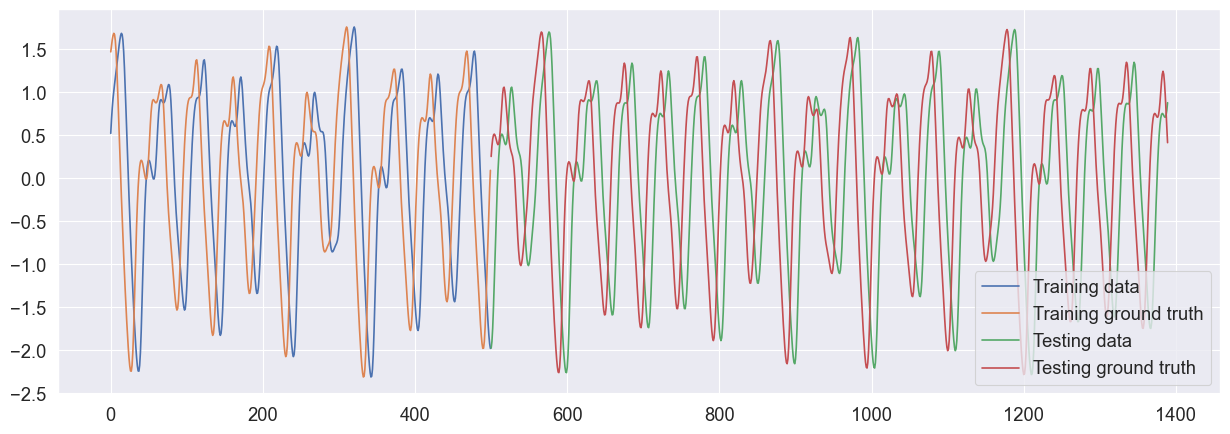

In [252]:
from reservoirpy.datasets import to_forecasting

X, Y = to_forecasting(X, forecast=10)
X_train1, Y_train1 = X[:1500], Y[:1500]
X_test1, Y_test1 = X[1500:], Y[1500:]

plot_train_test(X_train1, Y_train1, X_test1, Y_test1)

####
残りのパラメータは最終的にhyperopt(PythonにおけるBaysian optimization用のライブラリ)を用いて決定する。しかし、ここではhyperoptの中身に当たる部分を理解するために、先に定義しておく。

In [253]:
units = 500
leak_rate = 0.17113764962939737
spectral_radius = 1.182082887824895
input_scaling = 0.9697295578201843
connectivity = 0.10407566959031667      # - density of reservoir internal matrix
input_connectivity = 0.2  # and of reservoir input matrix
regularization = 5.602814683095597e-09
noise_rc = 3.297333463106559e-05
seed = 1234             # for reproducibility

In [254]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

In [255]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed, 
                      noise_rc=noise_rc, noise_type="normal")

readout   = Ridge(1, ridge=regularization)

esn = reservoir >> readout

In [256]:
y = esn(X[0])  # initialisation
reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None

(True, True, True)

In [257]:
np.all(readout.Wout == 0.0)

True

In [258]:
esn = esn.fit(X_train1, Y_train1, warmup=100)

Running Model-1061:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-1061: 1500it [00:00, 12707.11it/s]
Running Model-1061: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


Fitting node Ridge-1061...


In [259]:
def plot_readout(readout):
    Wout = readout.Wout
    bias = readout.bias
    Wout = np.r_[bias, Wout]

    fig = plt.figure(figsize=(15, 5))

    ax = fig.add_subplot(111)
    ax.grid(axis="y")
    ax.set_ylabel("Coefs. of $W_{out}$")
    ax.set_xlabel("reservoir neurons index")
    ax.bar(np.arange(Wout.size), Wout.ravel()[::-1])

    plt.show()

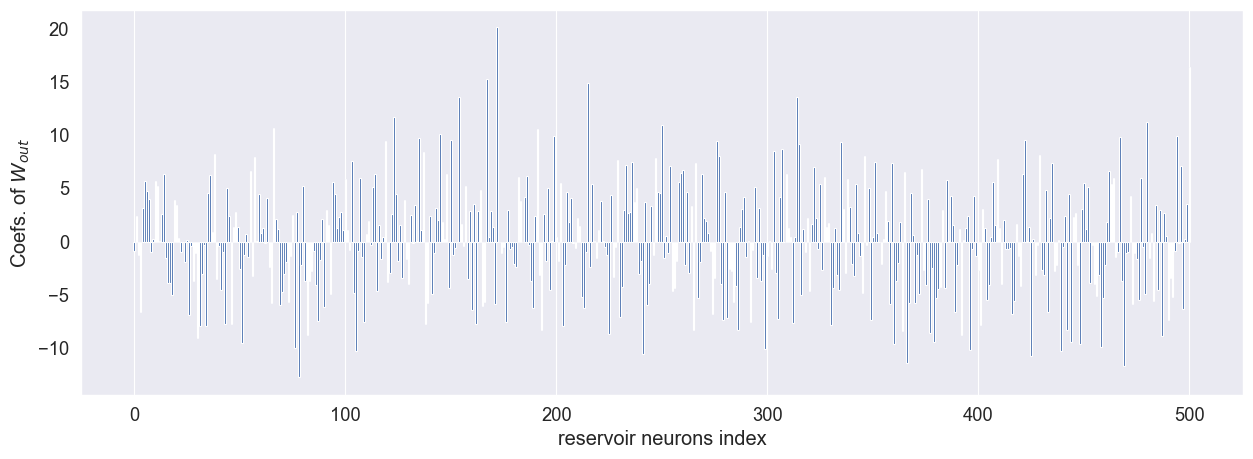

In [260]:
plot_readout(readout)

In [261]:
def plot_results(y_pred, y_test, sample=500):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
    plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [262]:
Y_pred1 = esn.run(X_test1)

Running Model-1061: 890it [00:00, 11929.65it/s]          


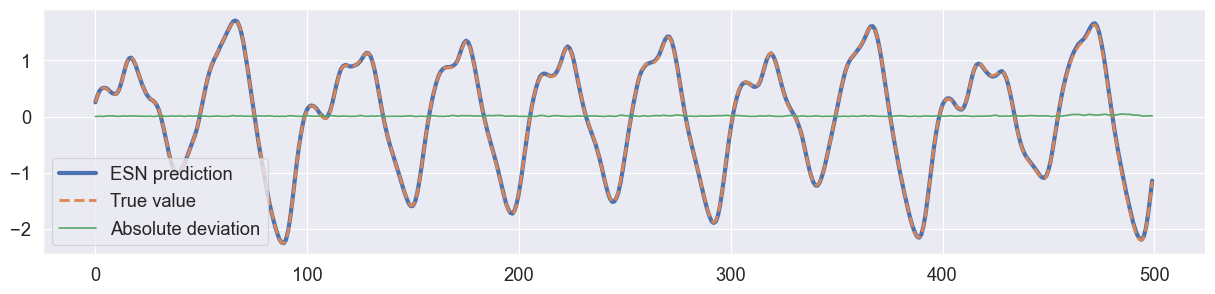

In [263]:
plot_results(Y_pred1, Y_test1)

In [264]:
rsquare(Y_test1, Y_pred1), nrmse(Y_test1, Y_pred1)

(0.9998089588189509, 0.0034038372324457266)

それでは、Baysian Optimizationを使ってみる。

In [221]:
def objective(dataset, config, *, cell_number, leak_rate, spectral_radius, input_connectivity, input_scaling, connectivity, regularization, noise_rc, seed):
    
    X, Y = to_forecasting(dataset, forecast=10)
    X_train1, Y_train1 = X[:1500], Y[:1500]
    X_test1, Y_test1 = X[1500:], Y[1500:]
    
    instances = config["instances_per_trial"]

    variable_seed = seed 
        
    losses = []; r2s = [];
    for n in range(instances):
        reservoir = Reservoir(cell_number, input_scaling=input_scaling, sr=spectral_radius,
                        lr=leak_rate, rc_connectivity=connectivity, 
                        noise_rc=noise_rc, noise_type="normal",
                        input_connectivity=input_connectivity, seed=seed)

        readout   = Ridge(1, ridge=regularization)

        esn = reservoir >> readout
            
        esn = esn.fit(X_train1, Y_train1, warmup=100)
        
        Y_pred1 = esn.run(X_test1)
        
        loss = nrmse(Y_test1, Y_pred1)
        r2 = rsquare(Y_test1, Y_pred1)
        
        losses.append(loss)
        r2s.append(r2)
        
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [222]:
hyperopt_config = {
    "exp": f"hyperopt-MG-onestep-prediction", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "cell_number": ["choice", 500],             # the number of neurons is fixed to 500
        "spectral_radius": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "leak_rate": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "input_connectivity": ["choice", 0.2], # the number of neurons is fixed to 0.2
        "regularization": ["loguniform", 1e-10, 1],  # the regularization parameter is log-uniformly distributed between 1e-10 and 1.
        "connectivity": ["uniform", 0, 1], # the connectivity of the random network in the hidden layer uniformly distributed between 0 and 1.
        "noise_rc": ["loguniform", 1e-5, 1], #noise amplitude is log-uniformly distributed between 1e-5 and 1
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [223]:
#パラメータ設定
#実行が終わらないので、いくつかのパラメータの桁数を減らした

from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

tau = 17
timesteps = 2400 
#warmup:10000 timesteps, training: 150000, 
#teseting data(Baysian optimization, short-term prediction) : 900


X = mackey_glass(timesteps, tau=tau)
#ここではz-score normalizationを使用。
X = (X - np.mean(X)) / np.std(X) 

In [224]:
from reservoirpy.hyper import research

best = research(objective, X, f"{hyperopt_config['exp']}.config.json", ".")

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

Running Model-460:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-460: 1152it [00:00, 11515.76it/s]         
Running Model-460: 1500it [00:00, 11784.29it/s]
Running Model-460: 100%|##########| 1/1 [00:00<00:00,  6.99it/s]


Fitting node Ridge-460...                              
  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

Running Model-460:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-460: 890it [00:00, 13448.85it/s]          
Running Model-461:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-461: 1269it [00:00, 12686.84it/s]         
Running Model-461: 1500it [00:00, 12487.63it/s]
Running Model-461: 100%|##########| 1/1 [00:00<00:00,  7.05it/s]


Fitting node Ridge-461...                              
  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

Running Model-461:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-461: 890it [00:00, 13182.09it/s]          
Running Model-462:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-462: 1356it [00:00, 13551.58it/s]         
Running Model-462: 1500it [00:00, 13306.46it/s]
Running Model-462: 100%|##########| 1/1 [00:00<00:00,  7.90it/s]


Fitting node Ridge-462...                              
  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

Running Model-462:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-462: 890it [00:00, 13005.23it/s]          


  0%|          | 1/200 [00:01<03:50,  1.16s/trial, best loss: 0.3043412768399459]

Running Model-463:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-463: 1172it [00:00, 11717.75it/s]         
Running Model-463: 1500it [00:00, 12001.99it/s]
Running Model-463: 100%|##########| 1/1 [00:00<00:00,  7.35it/s]


Fitting node Ridge-463...                                                        
  0%|          | 1/200 [00:01<03:50,  1.16s/trial, best loss: 0.3043412768399459]

Running Model-463:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-463: 890it [00:00, 14416.48it/s]          
Running Model-464:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-464: 1442it [00:00, 14411.97it/s]         
Running Model-464: 1500it [00:00, 14170.62it/s]
Running Model-464: 100%|##########| 1/1 [00:00<00:00,  8.46it/s]


Fitting node Ridge-464...                                                        
  0%|          | 1/200 [00:01<03:50,  1.16s/trial, best loss: 0.3043412768399459]

Running Model-464:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-464: 890it [00:00, 14448.79it/s]          
Running Model-465:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-465: 1402it [00:00, 14016.20it/s]         
Running Model-465: 1500it [00:00, 13746.08it/s]
Running Model-465: 100%|##########| 1/1 [00:00<00:00,  7.94it/s]


Fitting node Ridge-465...                                                        
  0%|          | 1/200 [00:02<03:50,  1.16s/trial, best loss: 0.3043412768399459]

Running Model-465:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-465: 890it [00:00, 14399.96it/s]          


  1%|          | 2/200 [00:02<03:39,  1.11s/trial, best loss: 0.3043412768399459]

Running Model-466:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-466: 349it [00:00, 3486.02it/s]           
Running Model-466: 698it [00:00, 3473.25it/s]
Running Model-466: 1046it [00:00, 3236.37it/s]
Running Model-466: 1385it [00:00, 3291.48it/s]
Running Model-466: 1500it [00:00, 3313.03it/s]
Running Model-466: 100%|##########| 1/1 [00:00<00:00,  2.08it/s]


Fitting node Ridge-466...                                                        
  1%|          | 2/200 [00:02<03:39,  1.11s/trial, best loss: 0.3043412768399459]

Running Model-466:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-466: 357it [00:00, 3563.41it/s]           
Running Model-466: 715it [00:00, 3568.78it/s]
Running Model-466: 890it [00:00, 3549.65it/s]
Running Model-467:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-467: 359it [00:00, 3580.51it/s]           
Running Model-467: 718it [00:00, 3509.05it/s]
Running Model-467: 1070it [00:00, 3479.28it/s]
Running Model-467: 1418it [00:00, 3470.90it/s]
Running Model-467: 1500it [00:00, 3468.65it/s]
Running Model-467: 100%|##########| 1/1 [00:00<00:00,  2.25it/s]


Fitting node Ridge-467...                                                        
  1%|          | 2/200 [00:04<03:39,  1.11s/trial, best loss: 0.3043412768399459]

Running Model-467:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-467: 355it [00:00, 3545.11it/s]           
Running Model-467: 710it [00:00, 3466.57it/s]
Running Model-467: 890it [00:00, 3477.71it/s]
Running Model-468:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-468: 346it [00:00, 3458.96it/s]           
Running Model-468: 693it [00:00, 3462.38it/s]
Running Model-468: 1050it [00:00, 3509.17it/s]
Running Model-468: 1406it [00:00, 3527.67it/s]
Running Model-468: 1500it [00:00, 3504.57it/s]
Running Model-468: 100%|##########| 1/1 [00:00<00:00,  2.27it/s]


Fitting node Ridge-468...                                                        
  1%|          | 2/200 [00:05<03:39,  1.11s/trial, best loss: 0.3043412768399459]

Running Model-468:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-468: 327it [00:00, 3264.35it/s]           
Running Model-468: 688it [00:00, 3463.39it/s]
Running Model-468: 890it [00:00, 3448.77it/s]


  2%|▏         | 3/200 [00:05<06:46,  2.06s/trial, best loss: 0.3043412768399459]

Running Model-469:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-469: 555it [00:00, 5549.38it/s]           
Running Model-469: 1110it [00:00, 5534.41it/s]
Running Model-469: 1500it [00:00, 5488.37it/s]
Running Model-469: 100%|##########| 1/1 [00:00<00:00,  3.47it/s]


Fitting node Ridge-469...                                                        
  2%|▏         | 3/200 [00:05<06:46,  2.06s/trial, best loss: 0.3043412768399459]

Running Model-469:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-469: 568it [00:00, 5676.70it/s]           
Running Model-469: 890it [00:00, 5622.48it/s]
Running Model-470:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-470: 552it [00:00, 5515.82it/s]           
Running Model-470: 1104it [00:00, 5488.42it/s]
Running Model-470: 1500it [00:00, 5489.52it/s]
Running Model-470: 100%|##########| 1/1 [00:00<00:00,  3.50it/s]


Fitting node Ridge-470...                                                        
  2%|▏         | 3/200 [00:06<06:46,  2.06s/trial, best loss: 0.3043412768399459]

Running Model-470:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-470: 560it [00:00, 5594.34it/s]           
Running Model-470: 890it [00:00, 5561.39it/s]
Running Model-471:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-471: 572it [00:00, 5712.46it/s]           
Running Model-471: 1144it [00:00, 5697.86it/s]
Running Model-471: 1500it [00:00, 5693.55it/s]
Running Model-471: 100%|##########| 1/1 [00:00<00:00,  3.63it/s]


Fitting node Ridge-471...                                                        
  2%|▏         | 3/200 [00:07<06:46,  2.06s/trial, best loss: 0.3043412768399459]

Running Model-471:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-471: 481it [00:00, 4804.80it/s]           
Running Model-471: 890it [00:00, 5138.54it/s]


  2%|▏         | 4/200 [00:07<07:11,  2.20s/trial, best loss: 0.2759356402394813]

Running Model-472:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-472: 682it [00:00, 6818.17it/s]           
Running Model-472: 1381it [00:00, 6917.16it/s]
Running Model-472: 1500it [00:00, 6873.26it/s]
Running Model-472: 100%|##########| 1/1 [00:00<00:00,  4.32it/s]


Fitting node Ridge-472...                                                        
  2%|▏         | 4/200 [00:08<07:11,  2.20s/trial, best loss: 0.2759356402394813]

Running Model-472:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-472: 708it [00:00, 7077.53it/s]           
Running Model-472: 890it [00:00, 6762.20it/s]
Running Model-473:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-473: 703it [00:00, 7021.49it/s]           
Running Model-473: 1406it [00:00, 7023.03it/s]
Running Model-473: 1500it [00:00, 6986.03it/s]
Running Model-473: 100%|##########| 1/1 [00:00<00:00,  4.38it/s]


Fitting node Ridge-473...                                                        
  2%|▏         | 4/200 [00:08<07:11,  2.20s/trial, best loss: 0.2759356402394813]

Running Model-473:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-473: 705it [00:00, 7045.22it/s]           
Running Model-473: 890it [00:00, 7000.12it/s]
Running Model-474:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-474: 669it [00:00, 6680.78it/s]           
Running Model-474: 1365it [00:00, 6840.99it/s]
Running Model-474: 1500it [00:00, 6778.26it/s]
Running Model-474: 100%|##########| 1/1 [00:00<00:00,  4.26it/s]


Fitting node Ridge-474...                                                        
  2%|▏         | 4/200 [00:09<07:11,  2.20s/trial, best loss: 0.2759356402394813]

Running Model-474:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-474: 709it [00:00, 7083.62it/s]           
Running Model-474: 890it [00:00, 7006.11it/s]


  2%|▎         | 5/200 [00:09<06:29,  2.00s/trial, best loss: 0.2759356402394813]

Running Model-475:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-475: 507it [00:00, 5067.11it/s]           
Running Model-475: 1018it [00:00, 5089.67it/s]
Running Model-475: 1500it [00:00, 5032.29it/s]
Running Model-475: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-475...                                                        
  2%|▎         | 5/200 [00:09<06:29,  2.00s/trial, best loss: 0.2759356402394813]

Running Model-475:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-475: 506it [00:00, 5058.99it/s]           
Running Model-475: 890it [00:00, 5106.08it/s]
Running Model-476:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-476: 516it [00:00, 5150.30it/s]           
Running Model-476: 1033it [00:00, 5156.15it/s]
Running Model-476: 1500it [00:00, 5161.68it/s]
Running Model-476: 100%|##########| 1/1 [00:00<00:00,  3.29it/s]


Fitting node Ridge-476...                                                        
  2%|▎         | 5/200 [00:10<06:29,  2.00s/trial, best loss: 0.2759356402394813]

Running Model-476:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-476: 508it [00:00, 5079.64it/s]           
Running Model-476: 890it [00:00, 5077.56it/s]
Running Model-477:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-477: 507it [00:00, 5069.26it/s]           
Running Model-477: 1014it [00:00, 5018.66it/s]
Running Model-477: 1500it [00:00, 5018.20it/s]
Running Model-477: 100%|##########| 1/1 [00:00<00:00,  3.18it/s]


Fitting node Ridge-477...                                                        
  2%|▎         | 5/200 [00:11<06:29,  2.00s/trial, best loss: 0.2759356402394813]

Running Model-477:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-477: 516it [00:00, 5154.74it/s]           
Running Model-477: 890it [00:00, 5140.41it/s]


  3%|▎         | 6/200 [00:11<06:39,  2.06s/trial, best loss: 0.2759356402394813]

Running Model-478:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-478: 315it [00:00, 3145.59it/s]           
Running Model-478: 630it [00:00, 3125.91it/s]
Running Model-478: 943it [00:00, 3122.06it/s]
Running Model-478: 1256it [00:00, 3115.69it/s]
Running Model-478: 1500it [00:00, 3114.38it/s]
Running Model-478: 100%|##########| 1/1 [00:00<00:00,  2.03it/s]


Fitting node Ridge-478...                                                        
  3%|▎         | 6/200 [00:12<06:39,  2.06s/trial, best loss: 0.2759356402394813]

Running Model-478:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-478: 316it [00:00, 3157.76it/s]           
Running Model-478: 632it [00:00, 3128.77it/s]
Running Model-478: 890it [00:00, 3096.55it/s]
Running Model-479:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-479: 293it [00:00, 2926.35it/s]           
Running Model-479: 586it [00:00, 2711.94it/s]
Running Model-479: 880it [00:00, 2808.80it/s]
Running Model-479: 1180it [00:00, 2880.89it/s]
Running Model-479: 1483it [00:00, 2930.57it/s]
Running Model-479: 1500it [00:00, 2879.21it/s]
Running Model-479: 100%|##########| 1/1 [00:00<00:00,  1.87it/s]


Fitting node Ridge-479...                                                        
  3%|▎         | 6/200 [00:13<06:39,  2.06s/trial, best loss: 0.2759356402394813]

Running Model-479:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-479: 300it [00:00, 2997.97it/s]           
Running Model-479: 608it [00:00, 3040.93it/s]
Running Model-479: 890it [00:00, 3040.50it/s]
Running Model-480:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-480: 304it [00:00, 3031.73it/s]           
Running Model-480: 608it [00:00, 3035.79it/s]
Running Model-480: 912it [00:00, 3010.97it/s]
Running Model-480: 1214it [00:00, 3007.44it/s]
Running Model-480: 1500it [00:00, 3020.56it/s]
Running Model-480: 100%|##########| 1/1 [00:00<00:00,  1.96it/s]


Fitting node Ridge-480...                                                        
  3%|▎         | 6/200 [00:15<06:39,  2.06s/trial, best loss: 0.2759356402394813]

Running Model-480:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-480: 304it [00:00, 3034.61it/s]           
Running Model-480: 608it [00:00, 3037.49it/s]
Running Model-480: 890it [00:00, 3036.34it/s]


  4%|▎         | 7/200 [00:15<08:33,  2.66s/trial, best loss: 0.007779825106957381]

Running Model-481:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-481: 381it [00:00, 3806.17it/s]           
Running Model-481: 763it [00:00, 3811.99it/s]
Running Model-481: 1145it [00:00, 3803.13it/s]
Running Model-481: 1500it [00:00, 3800.06it/s]
Running Model-481: 100%|##########| 1/1 [00:00<00:00,  2.45it/s]


Fitting node Ridge-481...                                                          
  4%|▎         | 7/200 [00:16<08:33,  2.66s/trial, best loss: 0.007779825106957381]

Running Model-481:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-481: 388it [00:00, 3875.31it/s]           
Running Model-481: 783it [00:00, 3915.82it/s]
Running Model-481: 890it [00:00, 3891.29it/s]
Running Model-482:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-482: 385it [00:00, 3846.43it/s]           
Running Model-482: 770it [00:00, 3838.15it/s]
Running Model-482: 1154it [00:00, 3834.72it/s]
Running Model-482: 1500it [00:00, 3822.28it/s]
Running Model-482: 100%|##########| 1/1 [00:00<00:00,  2.47it/s]


Fitting node Ridge-482...                                                          
  4%|▎         | 7/200 [00:17<08:33,  2.66s/trial, best loss: 0.007779825106957381]

Running Model-482:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-482: 393it [00:00, 3928.47it/s]           
Running Model-482: 786it [00:00, 3924.56it/s]
Running Model-482: 890it [00:00, 3906.28it/s]
Running Model-483:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-483: 393it [00:00, 3926.90it/s]           
Running Model-483: 793it [00:00, 3968.65it/s]
Running Model-483: 1191it [00:00, 3970.01it/s]
Running Model-483: 1500it [00:00, 3958.07it/s]
Running Model-483: 100%|##########| 1/1 [00:00<00:00,  2.55it/s]


Fitting node Ridge-483...                                                          
  4%|▎         | 7/200 [00:17<08:33,  2.66s/trial, best loss: 0.007779825106957381]

Running Model-483:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-483: 385it [00:00, 3843.05it/s]           
Running Model-483: 787it [00:00, 3945.65it/s]
Running Model-483: 890it [00:00, 3917.15it/s]


  4%|▍         | 8/200 [00:18<08:35,  2.68s/trial, best loss: 0.007779825106957381]

Running Model-484:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-484: 778it [00:00, 7773.24it/s]           
Running Model-484: 1500it [00:00, 7782.76it/s]
Running Model-484: 100%|##########| 1/1 [00:00<00:00,  4.84it/s]


Fitting node Ridge-484...                                                          
  4%|▍         | 8/200 [00:18<08:35,  2.68s/trial, best loss: 0.007779825106957381]

Running Model-484:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-484: 796it [00:00, 7958.17it/s]           
Running Model-484: 890it [00:00, 7779.37it/s]
Running Model-485:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-485: 786it [00:00, 7855.31it/s]           
Running Model-485: 1500it [00:00, 7806.85it/s]
Running Model-485: 100%|##########| 1/1 [00:00<00:00,  4.89it/s]


Fitting node Ridge-485...                                                          
  4%|▍         | 8/200 [00:19<08:35,  2.68s/trial, best loss: 0.007779825106957381]

Running Model-485:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-485: 753it [00:00, 7521.81it/s]           
Running Model-485: 890it [00:00, 7495.12it/s]
Running Model-486:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-486: 783it [00:00, 7827.25it/s]           
Running Model-486: 1500it [00:00, 7810.02it/s]
Running Model-486: 100%|##########| 1/1 [00:00<00:00,  4.81it/s]


Fitting node Ridge-486...                                                          
  4%|▍         | 8/200 [00:19<08:35,  2.68s/trial, best loss: 0.007779825106957381]

Running Model-486:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-486: 790it [00:00, 7898.26it/s]           
Running Model-486: 890it [00:00, 7784.61it/s]


  4%|▍         | 9/200 [00:19<07:24,  2.33s/trial, best loss: 0.007779825106957381]

Running Model-487:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-487: 418it [00:00, 4169.94it/s]           
Running Model-487: 837it [00:00, 4176.38it/s]
Running Model-487: 1257it [00:00, 4183.76it/s]
Running Model-487: 1500it [00:00, 4172.94it/s]
Running Model-487: 100%|##########| 1/1 [00:00<00:00,  2.66it/s]


Fitting node Ridge-487...                                                          
  4%|▍         | 9/200 [00:20<07:24,  2.33s/trial, best loss: 0.007779825106957381]

Running Model-487:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-487: 418it [00:00, 4174.16it/s]           
Running Model-487: 841it [00:00, 4205.46it/s]
Running Model-487: 890it [00:00, 4179.49it/s]
Running Model-488:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-488: 419it [00:00, 4182.15it/s]           
Running Model-488: 838it [00:00, 4166.24it/s]
Running Model-488: 1258it [00:00, 4177.86it/s]
Running Model-488: 1500it [00:00, 4166.11it/s]
Running Model-488: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Fitting node Ridge-488...                                                          
  4%|▍         | 9/200 [00:21<07:24,  2.33s/trial, best loss: 0.007779825106957381]

Running Model-488:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-488: 421it [00:00, 4204.33it/s]           
Running Model-488: 842it [00:00, 4162.06it/s]
Running Model-488: 890it [00:00, 4146.25it/s]
Running Model-489:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-489: 417it [00:00, 4162.60it/s]           
Running Model-489: 835it [00:00, 4167.75it/s]
Running Model-489: 1254it [00:00, 4177.64it/s]
Running Model-489: 1500it [00:00, 4163.30it/s]
Running Model-489: 100%|##########| 1/1 [00:00<00:00,  2.66it/s]


Fitting node Ridge-489...                                                          
  4%|▍         | 9/200 [00:22<07:24,  2.33s/trial, best loss: 0.007779825106957381]

Running Model-489:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-489: 418it [00:00, 4170.55it/s]           
Running Model-489: 840it [00:00, 4196.95it/s]
Running Model-489: 890it [00:00, 4171.32it/s]


  5%|▌         | 10/200 [00:22<07:35,  2.40s/trial, best loss: 0.007779825106957381]

Running Model-490:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-490: 523it [00:00, 5227.80it/s]           
Running Model-490: 1046it [00:00, 5222.95it/s]
Running Model-490: 1500it [00:00, 5216.88it/s]
Running Model-490: 100%|##########| 1/1 [00:00<00:00,  3.31it/s]


Fitting node Ridge-490...                                                           
  5%|▌         | 10/200 [00:22<07:35,  2.40s/trial, best loss: 0.007779825106957381]

Running Model-490:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-490: 510it [00:00, 5098.83it/s]           
Running Model-490: 890it [00:00, 5150.73it/s]
Running Model-491:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-491: 523it [00:00, 5221.64it/s]           
Running Model-491: 1046it [00:00, 5208.00it/s]
Running Model-491: 1500it [00:00, 5203.29it/s]
Running Model-491: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-491...                                                           
  5%|▌         | 10/200 [00:23<07:35,  2.40s/trial, best loss: 0.007779825106957381]

Running Model-491:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-491: 525it [00:00, 5240.62it/s]           
Running Model-491: 890it [00:00, 5232.77it/s]
Running Model-492:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-492: 505it [00:00, 5046.72it/s]           
Running Model-492: 1026it [00:00, 5140.17it/s]
Running Model-492: 1500it [00:00, 5153.79it/s]
Running Model-492: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-492...                                                           
  5%|▌         | 10/200 [00:24<07:35,  2.40s/trial, best loss: 0.007779825106957381]

Running Model-492:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-492: 526it [00:00, 5250.72it/s]           
Running Model-492: 890it [00:00, 5242.45it/s]


  6%|▌         | 11/200 [00:24<07:14,  2.30s/trial, best loss: 0.007779825106957381]

Running Model-493:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-493: 294it [00:00, 2937.54it/s]           
Running Model-493: 588it [00:00, 2892.30it/s]
Running Model-493: 889it [00:00, 2944.43it/s]
Running Model-493: 1186it [00:00, 2954.09it/s]
Running Model-493: 1482it [00:00, 2943.44it/s]
Running Model-493: 1500it [00:00, 2932.95it/s]
Running Model-493: 100%|##########| 1/1 [00:00<00:00,  1.91it/s]


Fitting node Ridge-493...                                                           
  6%|▌         | 11/200 [00:25<07:14,  2.30s/trial, best loss: 0.007779825106957381]

Running Model-493:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-493: 291it [00:00, 2909.79it/s]           
Running Model-493: 583it [00:00, 2912.94it/s]
Running Model-493: 883it [00:00, 2952.59it/s]
Running Model-493: 890it [00:00, 2929.77it/s]
Running Model-494:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-494: 296it [00:00, 2956.87it/s]           
Running Model-494: 592it [00:00, 2925.00it/s]
Running Model-494: 886it [00:00, 2928.43it/s]
Running Model-494: 1185it [00:00, 2952.36it/s]
Running Model-494: 1482it [00:00, 2957.64it/s]
Running Model-494: 1500it [00:00, 2943.78it/s]
Running Model-494: 100%|##########| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-494...                                                           
  6%|▌         | 11/200 [00:26<07:14,  2.30s/trial, best loss: 0.007779825106957381]

Running Model-494:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-494: 286it [00:00, 2851.84it/s]           
Running Model-494: 579it [00:00, 2894.21it/s]
Running Model-494: 869it [00:00, 2888.87it/s]
Running Model-494: 890it [00:00, 2877.33it/s]
Running Model-495:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-495: 299it [00:00, 2981.69it/s]           
Running Model-495: 602it [00:00, 3008.68it/s]
Running Model-495: 906it [00:00, 3018.31it/s]
Running Model-495: 1209it [00:00, 3020.58it/s]
Running Model-495: 1500it [00:00, 3010.56it/s]
Running Model-495: 100%|##########| 1/1 [00:00<00:00,  1.96it/s]


Fitting node Ridge-495...                                                           
  6%|▌         | 11/200 [00:27<07:14,  2.30s/trial, best loss: 0.007779825106957381]

Running Model-495:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-495: 288it [00:00, 2877.46it/s]           
Running Model-495: 581it [00:00, 2905.44it/s]
Running Model-495: 878it [00:00, 2932.54it/s]
Running Model-495: 890it [00:00, 2914.42it/s]


  6%|▌         | 12/200 [00:28<08:23,  2.68s/trial, best loss: 0.007779825106957381]

Running Model-496:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-496: 400it [00:00, 3992.85it/s]           
Running Model-496: 857it [00:00, 4327.63it/s]
Running Model-496: 1323it [00:00, 4475.55it/s]
Running Model-496: 1500it [00:00, 4406.76it/s]
Running Model-496: 100%|##########| 1/1 [00:00<00:00,  2.83it/s]


Fitting node Ridge-496...                                                           
  6%|▌         | 12/200 [00:28<08:23,  2.68s/trial, best loss: 0.007779825106957381]

Running Model-496:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-496: 457it [00:00, 4567.66it/s]           
Running Model-496: 890it [00:00, 4629.07it/s]
Running Model-497:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-497: 471it [00:00, 4703.98it/s]           
Running Model-497: 946it [00:00, 4730.95it/s]
Running Model-497: 1424it [00:00, 4749.33it/s]
Running Model-497: 1500it [00:00, 4723.10it/s]
Running Model-497: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-497...                                                           
  6%|▌         | 12/200 [00:29<08:23,  2.68s/trial, best loss: 0.007779825106957381]

Running Model-497:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-497: 443it [00:00, 4420.32it/s]           
Running Model-497: 890it [00:00, 4563.14it/s]
Running Model-498:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-498: 473it [00:00, 4725.84it/s]           
Running Model-498: 946it [00:00, 4707.50it/s]
Running Model-498: 1417it [00:00, 4700.61it/s]
Running Model-498: 1500it [00:00, 4669.20it/s]
Running Model-498: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-498...                                                           
  6%|▌         | 12/200 [00:30<08:23,  2.68s/trial, best loss: 0.007779825106957381]

Running Model-498:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-498: 475it [00:00, 4742.32it/s]           
Running Model-498: 890it [00:00, 4658.71it/s]


  6%|▋         | 13/200 [00:30<08:00,  2.57s/trial, best loss: 0.007779825106957381]

Running Model-499:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-499: 1108it [00:00, 11079.67it/s]         
Running Model-499: 1500it [00:00, 10940.60it/s]
Running Model-499: 100%|##########| 1/1 [00:00<00:00,  6.56it/s]


Fitting node Ridge-499...                                                           
  6%|▋         | 13/200 [00:30<08:00,  2.57s/trial, best loss: 0.007779825106957381]

Running Model-499:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-499: 890it [00:00, 11046.69it/s]          
Running Model-500:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-500: 1097it [00:00, 10963.74it/s]         
Running Model-500: 1500it [00:00, 10854.54it/s]
Running Model-500: 100%|##########| 1/1 [00:00<00:00,  5.45it/s]


Fitting node Ridge-500...                                                           
  6%|▋         | 13/200 [00:30<08:00,  2.57s/trial, best loss: 0.007779825106957381]

Running Model-500:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-500: 890it [00:00, 11258.69it/s]          
Running Model-501:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-501: 1132it [00:00, 11315.94it/s]         
Running Model-501: 1500it [00:00, 11185.94it/s]
Running Model-501: 100%|##########| 1/1 [00:00<00:00,  6.85it/s]


Fitting node Ridge-501...                                                           
  6%|▋         | 13/200 [00:31<08:00,  2.57s/trial, best loss: 0.007779825106957381]

Running Model-501:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-501: 890it [00:00, 10966.92it/s]          


  7%|▋         | 14/200 [00:31<06:45,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-502:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-502: 930it [00:00, 9290.62it/s]           
Running Model-502: 1500it [00:00, 9218.91it/s]
Running Model-502: 100%|##########| 1/1 [00:00<00:00,  5.72it/s]


Fitting node Ridge-502...                                                           
  7%|▋         | 14/200 [00:31<06:45,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-502:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-502: 890it [00:00, 9686.84it/s]           
Running Model-503:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-503: 960it [00:00, 9591.34it/s]           
Running Model-503: 1500it [00:00, 9491.92it/s]
Running Model-503: 100%|##########| 1/1 [00:00<00:00,  5.90it/s]


Fitting node Ridge-503...                                                           
  7%|▋         | 14/200 [00:32<06:45,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-503:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-503: 890it [00:00, 9681.69it/s]           
Running Model-504:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-504: 952it [00:00, 9519.06it/s]           
Running Model-504: 1500it [00:00, 9157.68it/s]
Running Model-504: 100%|##########| 1/1 [00:00<00:00,  5.68it/s]


Fitting node Ridge-504...                                                           
  7%|▋         | 14/200 [00:32<06:45,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-504:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-504: 890it [00:00, 9557.33it/s]           


  8%|▊         | 15/200 [00:32<05:55,  1.92s/trial, best loss: 0.007779825106957381]

Running Model-505:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-505: 1311it [00:00, 13101.61it/s]         
Running Model-505: 1500it [00:00, 12923.47it/s]
Running Model-505: 100%|##########| 1/1 [00:00<00:00,  7.71it/s]


Fitting node Ridge-505...                                                           
  8%|▊         | 15/200 [00:33<05:55,  1.92s/trial, best loss: 0.007779825106957381]

Running Model-505:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-505: 890it [00:00, 12759.45it/s]          
Running Model-506:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-506: 1355it [00:00, 13543.39it/s]         
Running Model-506: 1500it [00:00, 13342.59it/s]
Running Model-506: 100%|##########| 1/1 [00:00<00:00,  7.97it/s]


Fitting node Ridge-506...                                                           
  8%|▊         | 15/200 [00:33<05:55,  1.92s/trial, best loss: 0.007779825106957381]

Running Model-506:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-506: 890it [00:00, 13734.76it/s]          
Running Model-507:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-507: 1305it [00:00, 13048.33it/s]         
Running Model-507: 1500it [00:00, 12835.44it/s]
Running Model-507: 100%|##########| 1/1 [00:00<00:00,  7.77it/s]


Fitting node Ridge-507...                                                           
  8%|▊         | 15/200 [00:33<05:55,  1.92s/trial, best loss: 0.007779825106957381]

Running Model-507:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-507: 890it [00:00, 13671.94it/s]          


  8%|▊         | 16/200 [00:34<05:11,  1.69s/trial, best loss: 0.007779825106957381]

Running Model-508:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-508: 751it [00:00, 7506.54it/s]           
Running Model-508: 1500it [00:00, 7473.73it/s]
Running Model-508: 100%|##########| 1/1 [00:00<00:00,  4.68it/s]


Fitting node Ridge-508...                                                           
  8%|▊         | 16/200 [00:34<05:11,  1.69s/trial, best loss: 0.007779825106957381]

Running Model-508:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-508: 758it [00:00, 7575.46it/s]           
Running Model-508: 890it [00:00, 7499.29it/s]
Running Model-509:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-509: 750it [00:00, 7493.54it/s]           
Running Model-509: 1500it [00:00, 7524.37it/s]
Running Model-509: 100%|##########| 1/1 [00:00<00:00,  4.74it/s]


Fitting node Ridge-509...                                                           
  8%|▊         | 16/200 [00:35<05:11,  1.69s/trial, best loss: 0.007779825106957381]

Running Model-509:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-509: 770it [00:00, 7697.93it/s]           
Running Model-509: 890it [00:00, 7606.20it/s]
Running Model-510:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-510: 747it [00:00, 7461.86it/s]           
Running Model-510: 1500it [00:00, 7511.79it/s]
Running Model-510: 100%|##########| 1/1 [00:00<00:00,  4.53it/s]


Fitting node Ridge-510...                                                           
  8%|▊         | 16/200 [00:35<05:11,  1.69s/trial, best loss: 0.007779825106957381]

Running Model-510:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-510: 755it [00:00, 7548.73it/s]           
Running Model-510: 890it [00:00, 7436.26it/s]


  8%|▊         | 17/200 [00:35<05:12,  1.71s/trial, best loss: 0.007779825106957381]

Running Model-511:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-511: 1107it [00:00, 11065.37it/s]         
Running Model-511: 1500it [00:00, 11118.36it/s]
Running Model-511: 100%|##########| 1/1 [00:00<00:00,  6.75it/s]


Fitting node Ridge-511...                                                           
  8%|▊         | 17/200 [00:36<05:12,  1.71s/trial, best loss: 0.007779825106957381]

Running Model-511:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-511: 890it [00:00, 11503.60it/s]          
Running Model-512:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-512: 1147it [00:00, 11465.45it/s]         
Running Model-512: 1500it [00:00, 11334.45it/s]
Running Model-512: 100%|##########| 1/1 [00:00<00:00,  6.92it/s]


Fitting node Ridge-512...                                                           
  8%|▊         | 17/200 [00:36<05:12,  1.71s/trial, best loss: 0.007779825106957381]

Running Model-512:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-512: 890it [00:00, 11427.96it/s]          
Running Model-513:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-513: 1124it [00:00, 11235.27it/s]         
Running Model-513: 1500it [00:00, 8920.56it/s] 
Running Model-513: 100%|##########| 1/1 [00:00<00:00,  5.55it/s]


Fitting node Ridge-513...                                                           
  8%|▊         | 17/200 [00:36<05:12,  1.71s/trial, best loss: 0.007779825106957381]

Running Model-513:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-513: 890it [00:00, 11325.91it/s]          


  9%|▉         | 18/200 [00:36<04:40,  1.54s/trial, best loss: 0.007779825106957381]

Running Model-514:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-514: 416it [00:00, 4153.61it/s]           
Running Model-514: 843it [00:00, 4218.11it/s]
Running Model-514: 1277it [00:00, 4271.19it/s]
Running Model-514: 1500it [00:00, 4264.25it/s]
Running Model-514: 100%|##########| 1/1 [00:00<00:00,  2.75it/s]


Fitting node Ridge-514...                                                           
  9%|▉         | 18/200 [00:37<04:40,  1.54s/trial, best loss: 0.007779825106957381]

Running Model-514:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-514: 422it [00:00, 4219.49it/s]           
Running Model-514: 853it [00:00, 4271.92it/s]
Running Model-514: 890it [00:00, 4237.99it/s]
Running Model-515:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-515: 437it [00:00, 4363.72it/s]           
Running Model-515: 883it [00:00, 4415.73it/s]
Running Model-515: 1325it [00:00, 4415.72it/s]
Running Model-515: 1500it [00:00, 4398.13it/s]
Running Model-515: 100%|##########| 1/1 [00:00<00:00,  2.79it/s]


Fitting node Ridge-515...                                                           
  9%|▉         | 18/200 [00:38<04:40,  1.54s/trial, best loss: 0.007779825106957381]

Running Model-515:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-515: 447it [00:00, 4467.14it/s]           
Running Model-515: 890it [00:00, 4451.11it/s]
Running Model-516:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-516: 423it [00:00, 4229.66it/s]           
Running Model-516: 847it [00:00, 4229.30it/s]
Running Model-516: 1282it [00:00, 4281.95it/s]
Running Model-516: 1500it [00:00, 4268.15it/s]
Running Model-516: 100%|##########| 1/1 [00:00<00:00,  2.75it/s]


Fitting node Ridge-516...                                                           
  9%|▉         | 18/200 [00:39<04:40,  1.54s/trial, best loss: 0.007779825106957381]

Running Model-516:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-516: 449it [00:00, 4481.08it/s]           
Running Model-516: 890it [00:00, 4480.89it/s]


 10%|▉         | 19/200 [00:39<05:29,  1.82s/trial, best loss: 0.007779825106957381]

Running Model-517:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-517: 525it [00:00, 5246.49it/s]           
Running Model-517: 1056it [00:00, 5281.08it/s]
Running Model-517: 1500it [00:00, 5262.92it/s]
Running Model-517: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-517...                                                           
 10%|▉         | 19/200 [00:39<05:29,  1.82s/trial, best loss: 0.007779825106957381]

Running Model-517:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-517: 509it [00:00, 5081.61it/s]           
Running Model-517: 890it [00:00, 5128.17it/s]
Running Model-518:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-518: 527it [00:00, 5264.26it/s]           
Running Model-518: 1063it [00:00, 5318.06it/s]
Running Model-518: 1500it [00:00, 5311.65it/s]
Running Model-518: 100%|##########| 1/1 [00:00<00:00,  3.35it/s]


Fitting node Ridge-518...                                                           
 10%|▉         | 19/200 [00:40<05:29,  1.82s/trial, best loss: 0.007779825106957381]

Running Model-518:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-518: 429it [00:00, 4286.45it/s]           
Running Model-518: 890it [00:00, 4695.13it/s]
Running Model-519:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-519: 529it [00:00, 5281.13it/s]           
Running Model-519: 1062it [00:00, 5304.37it/s]
Running Model-519: 1500it [00:00, 5291.98it/s]
Running Model-519: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-519...                                                           
 10%|▉         | 19/200 [00:41<05:29,  1.82s/trial, best loss: 0.007779825106957381]

Running Model-519:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-519: 472it [00:00, 4712.78it/s]           
Running Model-519: 890it [00:00, 4864.10it/s]


 10%|█         | 20/200 [00:41<05:51,  1.95s/trial, best loss: 0.007779825106957381]

Running Model-520:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-520: 721it [00:00, 7207.12it/s]           
Running Model-520: 1442it [00:00, 7142.68it/s]
Running Model-520: 1500it [00:00, 7102.27it/s]
Running Model-520: 100%|##########| 1/1 [00:00<00:00,  4.32it/s]


Fitting node Ridge-520...                                                           
 10%|█         | 20/200 [00:42<05:51,  1.95s/trial, best loss: 0.007779825106957381]

Running Model-520:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-520: 728it [00:00, 7275.05it/s]           
Running Model-520: 890it [00:00, 7194.71it/s]
Running Model-521:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-521: 728it [00:00, 7269.82it/s]           
Running Model-521: 1455it [00:00, 7127.04it/s]
Running Model-521: 1500it [00:00, 7107.16it/s]
Running Model-521: 100%|##########| 1/1 [00:00<00:00,  4.41it/s]


Fitting node Ridge-521...                                                           
 10%|█         | 20/200 [00:42<05:51,  1.95s/trial, best loss: 0.007779825106957381]

Running Model-521:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-521: 681it [00:00, 6806.60it/s]           
Running Model-521: 890it [00:00, 6825.57it/s]
Running Model-522:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-522: 701it [00:00, 7004.96it/s]           
Running Model-522: 1414it [00:00, 7075.03it/s]
Running Model-522: 1500it [00:00, 7029.25it/s]
Running Model-522: 100%|##########| 1/1 [00:00<00:00,  4.45it/s]


Fitting node Ridge-522...                                                           
 10%|█         | 20/200 [00:43<05:51,  1.95s/trial, best loss: 0.007779825106957381]

Running Model-522:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-522: 737it [00:00, 7364.63it/s]           
Running Model-522: 890it [00:00, 7280.27it/s]


 10%|█         | 21/200 [00:43<05:37,  1.89s/trial, best loss: 0.007779825106957381]

Running Model-523:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-523: 516it [00:00, 5159.60it/s]           
Running Model-523: 1040it [00:00, 5203.28it/s]
Running Model-523: 1500it [00:00, 5220.88it/s]
Running Model-523: 100%|##########| 1/1 [00:00<00:00,  3.30it/s]


Fitting node Ridge-523...                                                           
 10%|█         | 21/200 [00:43<05:37,  1.89s/trial, best loss: 0.007779825106957381]

Running Model-523:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-523: 515it [00:00, 5147.12it/s]           
Running Model-523: 890it [00:00, 5200.33it/s]
Running Model-524:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-524: 529it [00:00, 5283.39it/s]           
Running Model-524: 1059it [00:00, 5292.81it/s]
Running Model-524: 1500it [00:00, 5300.75it/s]
Running Model-524: 100%|##########| 1/1 [00:00<00:00,  3.39it/s]


Fitting node Ridge-524...                                                           
 10%|█         | 21/200 [00:44<05:37,  1.89s/trial, best loss: 0.007779825106957381]

Running Model-524:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-524: 544it [00:00, 5434.07it/s]           
Running Model-524: 890it [00:00, 5398.42it/s]
Running Model-525:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-525: 537it [00:00, 5360.57it/s]           
Running Model-525: 1074it [00:00, 5287.23it/s]
Running Model-525: 1500it [00:00, 5291.26it/s]
Running Model-525: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-525...                                                           
 10%|█         | 21/200 [00:45<05:37,  1.89s/trial, best loss: 0.007779825106957381]

Running Model-525:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-525: 536it [00:00, 5355.03it/s]           
Running Model-525: 890it [00:00, 5323.15it/s]


 11%|█         | 22/200 [00:45<05:47,  1.95s/trial, best loss: 0.007779825106957381]

Running Model-526:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-526: 667it [00:00, 6667.05it/s]           
Running Model-526: 1355it [00:00, 6788.46it/s]
Running Model-526: 1500it [00:00, 6766.18it/s]
Running Model-526: 100%|##########| 1/1 [00:00<00:00,  4.27it/s]


Fitting node Ridge-526...                                                           
 11%|█         | 22/200 [00:45<05:47,  1.95s/trial, best loss: 0.007779825106957381]

Running Model-526:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-526: 721it [00:00, 7202.16it/s]           
Running Model-526: 890it [00:00, 7139.02it/s]
Running Model-527:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-527: 702it [00:00, 7016.61it/s]           
Running Model-527: 1429it [00:00, 7164.70it/s]
Running Model-527: 1500it [00:00, 7091.56it/s]
Running Model-527: 100%|##########| 1/1 [00:00<00:00,  4.45it/s]


Fitting node Ridge-527...                                                           
 11%|█         | 22/200 [00:46<05:47,  1.95s/trial, best loss: 0.007779825106957381]

Running Model-527:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-527: 716it [00:00, 7152.83it/s]           
Running Model-527: 890it [00:00, 7081.92it/s]
Running Model-528:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-528: 683it [00:00, 6826.91it/s]           
Running Model-528: 1390it [00:00, 6965.33it/s]
Running Model-528: 1500it [00:00, 6874.29it/s]
Running Model-528: 100%|##########| 1/1 [00:00<00:00,  4.21it/s]


Fitting node Ridge-528...                                                           
 11%|█         | 22/200 [00:47<05:47,  1.95s/trial, best loss: 0.007779825106957381]

Running Model-528:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-528: 613it [00:00, 6122.59it/s]           
Running Model-528: 890it [00:00, 6250.00it/s]


 12%|█▏        | 23/200 [00:47<05:34,  1.89s/trial, best loss: 0.007779825106957381]

Running Model-529:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-529: 1433it [00:00, 14320.25it/s]         
Running Model-529: 1500it [00:00, 13989.25it/s]
Running Model-529: 100%|##########| 1/1 [00:00<00:00,  8.50it/s]


Fitting node Ridge-529...                                                           
 12%|█▏        | 23/200 [00:47<05:34,  1.89s/trial, best loss: 0.007779825106957381]

Running Model-529:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-529: 890it [00:00, 14643.48it/s]          
Running Model-530:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-530: 1479it [00:00, 14781.45it/s]         
Running Model-530: 1500it [00:00, 14468.74it/s]
Running Model-530: 100%|##########| 1/1 [00:00<00:00,  8.61it/s]


Fitting node Ridge-530...                                                           
 12%|█▏        | 23/200 [00:47<05:34,  1.89s/trial, best loss: 0.007779825106957381]

Running Model-530:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-530: 890it [00:00, 15077.61it/s]          
Running Model-531:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-531: 1500it [00:00, 15064.16it/s]         
Running Model-531: 100%|##########| 1/1 [00:00<00:00,  8.60it/s]


Fitting node Ridge-531...                                                           
 12%|█▏        | 23/200 [00:48<05:34,  1.89s/trial, best loss: 0.007779825106957381]

Running Model-531:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-531: 890it [00:00, 14730.91it/s]          


 12%|█▏        | 24/200 [00:48<04:49,  1.65s/trial, best loss: 0.007779825106957381]

Running Model-532:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-532: 318it [00:00, 3177.08it/s]           
Running Model-532: 636it [00:00, 3130.57it/s]
Running Model-532: 950it [00:00, 3123.95it/s]
Running Model-532: 1269it [00:00, 3149.30it/s]
Running Model-532: 1500it [00:00, 3090.51it/s]
Running Model-532: 100%|##########| 1/1 [00:00<00:00,  1.95it/s]


Fitting node Ridge-532...                                                           
 12%|█▏        | 24/200 [00:49<04:49,  1.65s/trial, best loss: 0.007779825106957381]

Running Model-532:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-532: 315it [00:00, 3144.37it/s]           
Running Model-532: 631it [00:00, 3151.26it/s]
Running Model-532: 890it [00:00, 3170.33it/s]
Running Model-533:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-533: 320it [00:00, 3194.44it/s]           
Running Model-533: 640it [00:00, 3017.22it/s]
Running Model-533: 947it [00:00, 3037.51it/s]
Running Model-533: 1256it [00:00, 3057.73it/s]
Running Model-533: 1500it [00:00, 3064.15it/s]
Running Model-533: 100%|##########| 1/1 [00:00<00:00,  1.99it/s]


Fitting node Ridge-533...                                                           
 12%|█▏        | 24/200 [00:50<04:49,  1.65s/trial, best loss: 0.007779825106957381]

Running Model-533:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-533: 313it [00:00, 3121.70it/s]           
Running Model-533: 629it [00:00, 3139.52it/s]
Running Model-533: 890it [00:00, 3128.13it/s]
Running Model-534:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-534: 305it [00:00, 3045.37it/s]           
Running Model-534: 619it [00:00, 3096.00it/s]
Running Model-534: 929it [00:00, 3092.70it/s]
Running Model-534: 1239it [00:00, 3075.98it/s]
Running Model-534: 1500it [00:00, 3071.71it/s]
Running Model-534: 100%|##########| 1/1 [00:00<00:00,  2.00it/s]


Fitting node Ridge-534...                                                           
 12%|█▏        | 24/200 [00:51<04:49,  1.65s/trial, best loss: 0.007779825106957381]

Running Model-534:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-534: 317it [00:00, 3163.26it/s]           
Running Model-534: 634it [00:00, 3132.95it/s]
Running Model-534: 890it [00:00, 3099.16it/s]


 12%|█▎        | 25/200 [00:51<06:28,  2.22s/trial, best loss: 0.007779825106957381]

Running Model-535:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-535: 388it [00:00, 3873.53it/s]           
Running Model-535: 776it [00:00, 3869.62it/s]
Running Model-535: 1163it [00:00, 3866.67it/s]
Running Model-535: 1500it [00:00, 3852.85it/s]
Running Model-535: 100%|##########| 1/1 [00:00<00:00,  2.48it/s]


Fitting node Ridge-535...                                                           
 12%|█▎        | 25/200 [00:52<06:28,  2.22s/trial, best loss: 0.007779825106957381]

Running Model-535:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-535: 394it [00:00, 3931.86it/s]           
Running Model-535: 790it [00:00, 3948.17it/s]
Running Model-535: 890it [00:00, 3932.27it/s]
Running Model-536:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-536: 392it [00:00, 3914.91it/s]           
Running Model-536: 785it [00:00, 3923.62it/s]
Running Model-536: 1183it [00:00, 3947.14it/s]
Running Model-536: 1500it [00:00, 3920.36it/s]
Running Model-536: 100%|##########| 1/1 [00:00<00:00,  2.50it/s]


Fitting node Ridge-536...                                                           
 12%|█▎        | 25/200 [00:53<06:28,  2.22s/trial, best loss: 0.007779825106957381]

Running Model-536:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-536: 396it [00:00, 3952.10it/s]           
Running Model-536: 794it [00:00, 3962.81it/s]
Running Model-536: 890it [00:00, 3931.34it/s]
Running Model-537:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-537: 395it [00:00, 3943.57it/s]           
Running Model-537: 790it [00:00, 3939.50it/s]
Running Model-537: 1184it [00:00, 3934.89it/s]
Running Model-537: 1500it [00:00, 3925.50it/s]
Running Model-537: 100%|##########| 1/1 [00:00<00:00,  2.51it/s]


Fitting node Ridge-537...                                                           
 12%|█▎        | 25/200 [00:54<06:28,  2.22s/trial, best loss: 0.007779825106957381]

Running Model-537:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-537: 397it [00:00, 3964.92it/s]           
Running Model-537: 794it [00:00, 3960.80it/s]
Running Model-537: 890it [00:00, 3938.66it/s]


 13%|█▎        | 26/200 [00:54<06:54,  2.38s/trial, best loss: 0.007779825106957381]

Running Model-538:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-538: 339it [00:00, 3386.07it/s]           
Running Model-538: 678it [00:00, 3370.54it/s]
Running Model-538: 1016it [00:00, 3372.61it/s]
Running Model-538: 1356it [00:00, 3381.63it/s]
Running Model-538: 1500it [00:00, 3370.63it/s]
Running Model-538: 100%|##########| 1/1 [00:00<00:00,  2.19it/s]


Fitting node Ridge-538...                                                           
 13%|█▎        | 26/200 [00:55<06:54,  2.38s/trial, best loss: 0.007779825106957381]

Running Model-538:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-538: 341it [00:00, 3402.31it/s]           
Running Model-538: 682it [00:00, 3404.29it/s]
Running Model-538: 890it [00:00, 3397.03it/s]
Running Model-539:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-539: 340it [00:00, 3390.37it/s]           
Running Model-539: 680it [00:00, 3382.22it/s]
Running Model-539: 1019it [00:00, 3378.27it/s]
Running Model-539: 1357it [00:00, 3373.56it/s]
Running Model-539: 1500it [00:00, 3363.89it/s]
Running Model-539: 100%|##########| 1/1 [00:00<00:00,  2.18it/s]


Fitting node Ridge-539...                                                           
 13%|█▎        | 26/200 [00:56<06:54,  2.38s/trial, best loss: 0.007779825106957381]

Running Model-539:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-539: 339it [00:00, 3383.94it/s]           
Running Model-539: 678it [00:00, 3380.75it/s]
Running Model-539: 890it [00:00, 3374.78it/s]
Running Model-540:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-540: 339it [00:00, 3386.45it/s]           
Running Model-540: 678it [00:00, 3372.24it/s]
Running Model-540: 1016it [00:00, 3365.60it/s]
Running Model-540: 1353it [00:00, 3353.55it/s]
Running Model-540: 1500it [00:00, 3339.98it/s]
Running Model-540: 100%|##########| 1/1 [00:00<00:00,  2.13it/s]


Fitting node Ridge-540...                                                           
 13%|█▎        | 26/200 [00:57<06:54,  2.38s/trial, best loss: 0.007779825106957381]

Running Model-540:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-540: 333it [00:00, 3329.27it/s]           
Running Model-540: 666it [00:00, 3328.97it/s]
Running Model-540: 890it [00:00, 3291.96it/s]


 14%|█▎        | 27/200 [00:57<07:27,  2.59s/trial, best loss: 0.007779825106957381]

Running Model-541:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-541: 1212it [00:00, 12111.52it/s]         
Running Model-541: 1500it [00:00, 11991.56it/s]
Running Model-541: 100%|##########| 1/1 [00:00<00:00,  7.01it/s]


Fitting node Ridge-541...                                                           
 14%|█▎        | 27/200 [00:57<07:27,  2.59s/trial, best loss: 0.007779825106957381]

Running Model-541:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-541: 890it [00:00, 12446.55it/s]          
Running Model-542:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-542: 1249it [00:00, 12485.25it/s]         
Running Model-542: 1500it [00:00, 12304.87it/s]
Running Model-542: 100%|##########| 1/1 [00:00<00:00,  7.43it/s]


Fitting node Ridge-542...                                                           
 14%|█▎        | 27/200 [00:58<07:27,  2.59s/trial, best loss: 0.007779825106957381]

Running Model-542:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-542: 890it [00:00, 12289.93it/s]          
Running Model-543:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-543: 1194it [00:00, 11938.08it/s]         
Running Model-543: 1500it [00:00, 11932.31it/s]
Running Model-543: 100%|##########| 1/1 [00:00<00:00,  7.14it/s]


Fitting node Ridge-543...                                                           
 14%|█▎        | 27/200 [00:58<07:27,  2.59s/trial, best loss: 0.007779825106957381]

Running Model-543:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-543: 890it [00:00, 12625.20it/s]          


 14%|█▍        | 28/200 [00:58<06:14,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-544:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-544: 1348it [00:00, 13471.41it/s]         
Running Model-544: 1500it [00:00, 13252.20it/s]
Running Model-544: 100%|##########| 1/1 [00:00<00:00,  7.85it/s]


Fitting node Ridge-544...                                                           
 14%|█▍        | 28/200 [00:59<06:14,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-544:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-544: 890it [00:00, 12966.02it/s]          
Running Model-545:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-545: 1351it [00:00, 13505.96it/s]         
Running Model-545: 1500it [00:00, 13296.59it/s]
Running Model-545: 100%|##########| 1/1 [00:00<00:00,  7.93it/s]


Fitting node Ridge-545...                                                           
 14%|█▍        | 28/200 [00:59<06:14,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-545:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-545: 890it [00:00, 13628.86it/s]          
Running Model-546:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-546: 1354it [00:00, 13532.17it/s]         
Running Model-546: 1500it [00:00, 13275.52it/s]
Running Model-546: 100%|##########| 1/1 [00:00<00:00,  6.22it/s]


Fitting node Ridge-546...                                                           
 14%|█▍        | 28/200 [01:00<06:14,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-546:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-546: 890it [00:00, 13342.76it/s]          


 14%|█▍        | 29/200 [01:00<05:21,  1.88s/trial, best loss: 0.007779825106957381]

Running Model-547:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-547: 839it [00:00, 8381.69it/s]           
Running Model-547: 1500it [00:00, 8381.67it/s]
Running Model-547: 100%|##########| 1/1 [00:00<00:00,  5.22it/s]


Fitting node Ridge-547...                                                           
 14%|█▍        | 29/200 [01:00<05:21,  1.88s/trial, best loss: 0.007779825106957381]

Running Model-547:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-547: 818it [00:00, 8173.71it/s]           
Running Model-547: 890it [00:00, 8072.70it/s]
Running Model-548:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-548: 846it [00:00, 8451.04it/s]           
Running Model-548: 1500it [00:00, 8381.66it/s]
Running Model-548: 100%|##########| 1/1 [00:00<00:00,  5.26it/s]


Fitting node Ridge-548...                                                           
 14%|█▍        | 29/200 [01:00<05:21,  1.88s/trial, best loss: 0.007779825106957381]

Running Model-548:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-548: 841it [00:00, 8401.86it/s]           
Running Model-548: 890it [00:00, 8288.09it/s]
Running Model-549:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-549: 813it [00:00, 8123.91it/s]           
Running Model-549: 1500it [00:00, 8211.34it/s]
Running Model-549: 100%|##########| 1/1 [00:00<00:00,  5.14it/s]


Fitting node Ridge-549...                                                           
 14%|█▍        | 29/200 [01:01<05:21,  1.88s/trial, best loss: 0.007779825106957381]

Running Model-549:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-549: 854it [00:00, 8531.89it/s]           
Running Model-549: 890it [00:00, 8387.44it/s]


 15%|█▌        | 30/200 [01:01<04:58,  1.75s/trial, best loss: 0.007779825106957381]

Running Model-550:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-550: 837it [00:00, 8366.06it/s]           
Running Model-550: 1500it [00:00, 8332.36it/s]
Running Model-550: 100%|##########| 1/1 [00:00<00:00,  5.19it/s]


Fitting node Ridge-550...                                                           
 15%|█▌        | 30/200 [01:01<04:58,  1.75s/trial, best loss: 0.007779825106957381]

Running Model-550:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-550: 847it [00:00, 8466.03it/s]           
Running Model-550: 890it [00:00, 8354.46it/s]
Running Model-551:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-551: 832it [00:00, 8310.20it/s]           
Running Model-551: 1500it [00:00, 8300.95it/s]
Running Model-551: 100%|##########| 1/1 [00:00<00:00,  5.14it/s]


Fitting node Ridge-551...                                                           
 15%|█▌        | 30/200 [01:02<04:58,  1.75s/trial, best loss: 0.007779825106957381]

Running Model-551:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-551: 837it [00:00, 8361.38it/s]           
Running Model-551: 890it [00:00, 8195.06it/s]
Running Model-552:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-552: 835it [00:00, 8349.65it/s]           
Running Model-552: 1500it [00:00, 8316.64it/s]
Running Model-552: 100%|##########| 1/1 [00:00<00:00,  5.17it/s]


Fitting node Ridge-552...                                                           
 15%|█▌        | 30/200 [01:03<04:58,  1.75s/trial, best loss: 0.007779825106957381]

Running Model-552:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-552: 846it [00:00, 8459.32it/s]           
Running Model-552: 890it [00:00, 8347.94it/s]


 16%|█▌        | 31/200 [01:03<04:47,  1.70s/trial, best loss: 0.007779825106957381]

Running Model-553:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-553: 663it [00:00, 6620.58it/s]           
Running Model-553: 1331it [00:00, 6650.75it/s]
Running Model-553: 1500it [00:00, 6626.02it/s]
Running Model-553: 100%|##########| 1/1 [00:00<00:00,  4.17it/s]


Fitting node Ridge-553...                                                           
 16%|█▌        | 31/200 [01:03<04:47,  1.70s/trial, best loss: 0.007779825106957381]

Running Model-553:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-553: 674it [00:00, 6736.57it/s]           
Running Model-553: 890it [00:00, 6704.03it/s]
Running Model-554:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-554: 638it [00:00, 6374.38it/s]           
Running Model-554: 1299it [00:00, 6508.45it/s]
Running Model-554: 1500it [00:00, 6463.56it/s]
Running Model-554: 100%|##########| 1/1 [00:00<00:00,  4.08it/s]


Fitting node Ridge-554...                                                           
 16%|█▌        | 31/200 [01:04<04:47,  1.70s/trial, best loss: 0.007779825106957381]

Running Model-554:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-554: 672it [00:00, 6719.27it/s]           
Running Model-554: 890it [00:00, 6616.41it/s]
Running Model-555:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-555: 666it [00:00, 6655.74it/s]           
Running Model-555: 1337it [00:00, 6685.56it/s]
Running Model-555: 1500it [00:00, 6631.00it/s]
Running Model-555: 100%|##########| 1/1 [00:00<00:00,  4.22it/s]


Fitting node Ridge-555...                                                           
 16%|█▌        | 31/200 [01:04<04:47,  1.70s/trial, best loss: 0.007779825106957381]

Running Model-555:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-555: 676it [00:00, 6759.12it/s]           
Running Model-555: 890it [00:00, 6696.87it/s]


 16%|█▌        | 32/200 [01:04<04:46,  1.70s/trial, best loss: 0.007779825106957381]

Running Model-556:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-556: 309it [00:00, 3081.50it/s]           
Running Model-556: 618it [00:00, 3081.39it/s]
Running Model-556: 927it [00:00, 3081.56it/s]
Running Model-556: 1236it [00:00, 3077.03it/s]
Running Model-556: 1500it [00:00, 3080.33it/s]
Running Model-556: 100%|##########| 1/1 [00:00<00:00,  2.01it/s]


Fitting node Ridge-556...                                                           
 16%|█▌        | 32/200 [01:05<04:46,  1.70s/trial, best loss: 0.007779825106957381]

Running Model-556:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-556: 311it [00:00, 3101.26it/s]           
Running Model-556: 622it [00:00, 3101.24it/s]
Running Model-556: 890it [00:00, 3099.58it/s]
Running Model-557:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-557: 310it [00:00, 3099.19it/s]           
Running Model-557: 620it [00:00, 3091.43it/s]
Running Model-557: 930it [00:00, 3088.23it/s]
Running Model-557: 1239it [00:00, 3082.12it/s]
Running Model-557: 1500it [00:00, 3086.96it/s]
Running Model-557: 100%|##########| 1/1 [00:00<00:00,  1.99it/s]


Fitting node Ridge-557...                                                           
 16%|█▌        | 32/200 [01:06<04:46,  1.70s/trial, best loss: 0.007779825106957381]

Running Model-557:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-557: 306it [00:00, 3053.73it/s]           
Running Model-557: 617it [00:00, 3084.84it/s]
Running Model-557: 890it [00:00, 3070.92it/s]
Running Model-558:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-558: 311it [00:00, 3100.79it/s]           
Running Model-558: 622it [00:00, 3089.68it/s]
Running Model-558: 931it [00:00, 3081.25it/s]
Running Model-558: 1241it [00:00, 3085.30it/s]
Running Model-558: 1500it [00:00, 3030.49it/s]
Running Model-558: 100%|##########| 1/1 [00:00<00:00,  1.97it/s]


Fitting node Ridge-558...                                                           
 16%|█▌        | 32/200 [01:07<04:46,  1.70s/trial, best loss: 0.007779825106957381]

Running Model-558:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-558: 308it [00:00, 3071.95it/s]           
Running Model-558: 616it [00:00, 3069.50it/s]
Running Model-558: 890it [00:00, 3067.72it/s]


 16%|█▋        | 33/200 [01:08<06:11,  2.23s/trial, best loss: 0.007779825106957381]

Running Model-559:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-559: 1060it [00:00, 10593.87it/s]         
Running Model-559: 1500it [00:00, 10480.15it/s]
Running Model-559: 100%|##########| 1/1 [00:00<00:00,  6.44it/s]


Fitting node Ridge-559...                                                           
 16%|█▋        | 33/200 [01:08<06:11,  2.23s/trial, best loss: 0.007779825106957381]

Running Model-559:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-559: 890it [00:00, 10705.86it/s]          
Running Model-560:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-560: 1065it [00:00, 10649.12it/s]         
Running Model-560: 1500it [00:00, 10526.66it/s]
Running Model-560: 100%|##########| 1/1 [00:00<00:00,  6.46it/s]


Fitting node Ridge-560...                                                           
 16%|█▋        | 33/200 [01:09<06:11,  2.23s/trial, best loss: 0.007779825106957381]

Running Model-560:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-560: 890it [00:00, 10549.77it/s]          
Running Model-561:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-561: 998it [00:00, 9977.80it/s]           
Running Model-561: 1500it [00:00, 10075.03it/s]
Running Model-561: 100%|##########| 1/1 [00:00<00:00,  6.16it/s]


Fitting node Ridge-561...                                                           
 16%|█▋        | 33/200 [01:09<06:11,  2.23s/trial, best loss: 0.007779825106957381]

Running Model-561:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-561: 890it [00:00, 10707.12it/s]          


 17%|█▋        | 34/200 [01:09<05:22,  1.94s/trial, best loss: 0.007779825106957381]

Running Model-562:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-562: 434it [00:00, 4331.09it/s]           
Running Model-562: 870it [00:00, 4343.30it/s]
Running Model-562: 1305it [00:00, 4259.07it/s]
Running Model-562: 1500it [00:00, 4277.15it/s]
Running Model-562: 100%|##########| 1/1 [00:00<00:00,  2.75it/s]


Fitting node Ridge-562...                                                           
 17%|█▋        | 34/200 [01:10<05:22,  1.94s/trial, best loss: 0.007779825106957381]

Running Model-562:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-562: 437it [00:00, 4362.24it/s]           
Running Model-562: 877it [00:00, 4379.18it/s]
Running Model-562: 890it [00:00, 4350.93it/s]
Running Model-563:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-563: 437it [00:00, 4365.42it/s]           
Running Model-563: 874it [00:00, 4366.70it/s]
Running Model-563: 1311it [00:00, 4276.41it/s]
Running Model-563: 1500it [00:00, 4278.78it/s]
Running Model-563: 100%|##########| 1/1 [00:00<00:00,  2.73it/s]


Fitting node Ridge-563...                                                           
 17%|█▋        | 34/200 [01:11<05:22,  1.94s/trial, best loss: 0.007779825106957381]

Running Model-563:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-563: 436it [00:00, 4358.03it/s]           
Running Model-563: 874it [00:00, 4366.13it/s]
Running Model-563: 890it [00:00, 4339.30it/s]
Running Model-564:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-564: 436it [00:00, 4359.00it/s]           
Running Model-564: 872it [00:00, 4344.64it/s]
Running Model-564: 1310it [00:00, 4356.45it/s]
Running Model-564: 1500it [00:00, 4331.67it/s]
Running Model-564: 100%|##########| 1/1 [00:00<00:00,  2.79it/s]


Fitting node Ridge-564...                                                           
 17%|█▋        | 34/200 [01:11<05:22,  1.94s/trial, best loss: 0.007779825106957381]

Running Model-564:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-564: 432it [00:00, 4319.26it/s]           
Running Model-564: 867it [00:00, 4335.28it/s]
Running Model-564: 890it [00:00, 4307.67it/s]


 18%|█▊        | 35/200 [01:12<05:53,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-565:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-565: 431it [00:00, 4308.84it/s]           
Running Model-565: 863it [00:00, 4312.31it/s]
Running Model-565: 1295it [00:00, 4244.07it/s]
Running Model-565: 1500it [00:00, 4070.18it/s]
Running Model-565: 100%|##########| 1/1 [00:00<00:00,  2.47it/s]


Fitting node Ridge-565...                                                           
 18%|█▊        | 35/200 [01:12<05:53,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-565:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-565: 440it [00:00, 4395.04it/s]           
Running Model-565: 880it [00:00, 4396.71it/s]
Running Model-565: 890it [00:00, 4371.55it/s]
Running Model-566:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-566: 422it [00:00, 4211.24it/s]           
Running Model-566: 860it [00:00, 4310.29it/s]
Running Model-566: 1292it [00:00, 4294.56it/s]
Running Model-566: 1500it [00:00, 4284.92it/s]
Running Model-566: 100%|##########| 1/1 [00:00<00:00,  2.73it/s]


Fitting node Ridge-566...                                                           
 18%|█▊        | 35/200 [01:13<05:53,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-566:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-566: 445it [00:00, 4441.52it/s]           
Running Model-566: 890it [00:00, 4436.39it/s]
Running Model-566: 890it [00:00, 4421.75it/s]
Running Model-567:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-567: 441it [00:00, 4400.72it/s]           
Running Model-567: 885it [00:00, 4419.86it/s]
Running Model-567: 1327it [00:00, 4316.48it/s]
Running Model-567: 1500it [00:00, 4324.10it/s]
Running Model-567: 100%|##########| 1/1 [00:00<00:00,  2.78it/s]


Fitting node Ridge-567...                                                           
 18%|█▊        | 35/200 [01:14<05:53,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-567:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-567: 445it [00:00, 4446.94it/s]           
Running Model-567: 890it [00:00, 4455.82it/s]


 18%|█▊        | 36/200 [01:14<06:11,  2.27s/trial, best loss: 0.007779825106957381]

Running Model-568:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-568: 484it [00:00, 4838.80it/s]           
Running Model-568: 968it [00:00, 4707.70it/s]
Running Model-568: 1452it [00:00, 4763.46it/s]
Running Model-568: 1500it [00:00, 4748.90it/s]
Running Model-568: 100%|##########| 1/1 [00:00<00:00,  3.05it/s]


Fitting node Ridge-568...                                                           
 18%|█▊        | 36/200 [01:15<06:11,  2.27s/trial, best loss: 0.007779825106957381]

Running Model-568:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-568: 488it [00:00, 4874.19it/s]           
Running Model-568: 890it [00:00, 4856.01it/s]
Running Model-569:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-569: 487it [00:00, 4869.85it/s]           
Running Model-569: 977it [00:00, 4882.39it/s]
Running Model-569: 1466it [00:00, 4747.44it/s]
Running Model-569: 1500it [00:00, 4763.37it/s]
Running Model-569: 100%|##########| 1/1 [00:00<00:00,  2.82it/s]


Fitting node Ridge-569...                                                           
 18%|█▊        | 36/200 [01:16<06:11,  2.27s/trial, best loss: 0.007779825106957381]

Running Model-569:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-569: 489it [00:00, 4882.48it/s]           
Running Model-569: 890it [00:00, 4867.96it/s]
Running Model-570:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-570: 489it [00:00, 4884.62it/s]           
Running Model-570: 978it [00:00, 4872.97it/s]
Running Model-570: 1466it [00:00, 4865.04it/s]
Running Model-570: 1500it [00:00, 4848.03it/s]
Running Model-570: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-570...                                                           
 18%|█▊        | 36/200 [01:16<06:11,  2.27s/trial, best loss: 0.007779825106957381]

Running Model-570:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-570: 486it [00:00, 4853.30it/s]           
Running Model-570: 890it [00:00, 4858.98it/s]


 18%|█▊        | 37/200 [01:17<06:07,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-571:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-571: 353it [00:00, 3529.85it/s]           
Running Model-571: 706it [00:00, 3501.33it/s]
Running Model-571: 1057it [00:00, 3493.40it/s]
Running Model-571: 1407it [00:00, 3469.34it/s]
Running Model-571: 1500it [00:00, 3478.20it/s]
Running Model-571: 100%|##########| 1/1 [00:00<00:00,  2.26it/s]


Fitting node Ridge-571...                                                           
 18%|█▊        | 37/200 [01:17<06:07,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-571:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-571: 357it [00:00, 3565.97it/s]           
Running Model-571: 716it [00:00, 3576.80it/s]
Running Model-571: 890it [00:00, 3558.26it/s]
Running Model-572:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-572: 358it [00:00, 3577.21it/s]           
Running Model-572: 716it [00:00, 3549.67it/s]
Running Model-572: 1071it [00:00, 3508.01it/s]
Running Model-572: 1424it [00:00, 3512.93it/s]
Running Model-572: 1500it [00:00, 3515.36it/s]
Running Model-572: 100%|##########| 1/1 [00:00<00:00,  2.28it/s]


Fitting node Ridge-572...                                                           
 18%|█▊        | 37/200 [01:18<06:07,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-572:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-572: 358it [00:00, 3571.56it/s]           
Running Model-572: 716it [00:00, 3561.45it/s]
Running Model-572: 890it [00:00, 3554.56it/s]
Running Model-573:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-573: 358it [00:00, 3571.33it/s]           
Running Model-573: 716it [00:00, 3462.11it/s]
Running Model-573: 1071it [00:00, 3501.01it/s]
Running Model-573: 1425it [00:00, 3514.01it/s]
Running Model-573: 1500it [00:00, 3501.92it/s]
Running Model-573: 100%|##########| 1/1 [00:00<00:00,  2.26it/s]


Fitting node Ridge-573...                                                           
 18%|█▊        | 37/200 [01:19<06:07,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-573:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-573: 355it [00:00, 3549.75it/s]           
Running Model-573: 713it [00:00, 3564.93it/s]
Running Model-573: 890it [00:00, 3551.70it/s]


 19%|█▉        | 38/200 [01:19<06:38,  2.46s/trial, best loss: 0.007779825106957381]

Running Model-574:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-574: 284it [00:00, 2836.49it/s]           
Running Model-574: 597it [00:00, 3007.37it/s]
Running Model-574: 913it [00:00, 3074.48it/s]
Running Model-574: 1230it [00:00, 3109.23it/s]
Running Model-574: 1500it [00:00, 3080.73it/s]
Running Model-574: 100%|##########| 1/1 [00:00<00:00,  2.00it/s]


Fitting node Ridge-574...                                                           
 19%|█▉        | 38/200 [01:20<06:38,  2.46s/trial, best loss: 0.007779825106957381]

Running Model-574:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-574: 316it [00:00, 3152.43it/s]           
Running Model-574: 634it [00:00, 3165.86it/s]
Running Model-574: 890it [00:00, 3141.36it/s]
Running Model-575:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-575: 307it [00:00, 3066.08it/s]           
Running Model-575: 623it [00:00, 3121.18it/s]
Running Model-575: 938it [00:00, 3132.82it/s]
Running Model-575: 1253it [00:00, 3137.57it/s]
Running Model-575: 1500it [00:00, 3130.69it/s]
Running Model-575: 100%|##########| 1/1 [00:00<00:00,  2.03it/s]


Fitting node Ridge-575...                                                           
 19%|█▉        | 38/200 [01:21<06:38,  2.46s/trial, best loss: 0.007779825106957381]

Running Model-575:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-575: 314it [00:00, 3131.83it/s]           
Running Model-575: 629it [00:00, 3137.36it/s]
Running Model-575: 890it [00:00, 3145.59it/s]
Running Model-576:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-576: 310it [00:00, 3094.86it/s]           
Running Model-576: 620it [00:00, 3075.43it/s]
Running Model-576: 934it [00:00, 3103.95it/s]
Running Model-576: 1245it [00:00, 3100.71it/s]
Running Model-576: 1500it [00:00, 3105.26it/s]
Running Model-576: 100%|##########| 1/1 [00:00<00:00,  2.02it/s]


Fitting node Ridge-576...                                                           
 19%|█▉        | 38/200 [01:23<06:38,  2.46s/trial, best loss: 0.007779825106957381]

Running Model-576:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-576: 316it [00:00, 3159.78it/s]           
Running Model-576: 632it [00:00, 3149.68it/s]
Running Model-576: 890it [00:00, 3027.13it/s]


 20%|█▉        | 39/200 [01:23<07:24,  2.76s/trial, best loss: 0.007779825106957381]

Running Model-577:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-577: 430it [00:00, 4295.35it/s]           
Running Model-577: 860it [00:00, 4282.86it/s]
Running Model-577: 1292it [00:00, 4295.32it/s]
Running Model-577: 1500it [00:00, 4280.03it/s]
Running Model-577: 100%|##########| 1/1 [00:00<00:00,  2.75it/s]


Fitting node Ridge-577...                                                           
 20%|█▉        | 39/200 [01:23<07:24,  2.76s/trial, best loss: 0.007779825106957381]

Running Model-577:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-577: 416it [00:00, 4156.22it/s]           
Running Model-577: 849it [00:00, 4254.91it/s]
Running Model-577: 890it [00:00, 4215.87it/s]
Running Model-578:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-578: 431it [00:00, 4303.42it/s]           
Running Model-578: 862it [00:00, 4302.89it/s]
Running Model-578: 1293it [00:00, 4299.31it/s]
Running Model-578: 1500it [00:00, 4283.98it/s]
Running Model-578: 100%|##########| 1/1 [00:00<00:00,  2.74it/s]


Fitting node Ridge-578...                                                           
 20%|█▉        | 39/200 [01:24<07:24,  2.76s/trial, best loss: 0.007779825106957381]

Running Model-578:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-578: 412it [00:00, 4113.83it/s]           
Running Model-578: 847it [00:00, 4251.15it/s]
Running Model-578: 890it [00:00, 4213.84it/s]
Running Model-579:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-579: 436it [00:00, 4355.00it/s]           
Running Model-579: 872it [00:00, 4320.20it/s]
Running Model-579: 1305it [00:00, 4313.89it/s]
Running Model-579: 1500it [00:00, 4305.56it/s]
Running Model-579: 100%|##########| 1/1 [00:00<00:00,  2.77it/s]


Fitting node Ridge-579...                                                           
 20%|█▉        | 39/200 [01:25<07:24,  2.76s/trial, best loss: 0.007779825106957381]

Running Model-579:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-579: 411it [00:00, 4100.85it/s]           
Running Model-579: 846it [00:00, 4244.53it/s]
Running Model-579: 890it [00:00, 4204.48it/s]


 20%|██        | 40/200 [01:25<07:07,  2.67s/trial, best loss: 0.007779825106957381]

Running Model-580:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-580: 432it [00:00, 4312.71it/s]           
Running Model-580: 864it [00:00, 4292.07it/s]
Running Model-580: 1296it [00:00, 4301.37it/s]
Running Model-580: 1500it [00:00, 4270.27it/s]
Running Model-580: 100%|##########| 1/1 [00:00<00:00,  2.75it/s]


Fitting node Ridge-580...                                                           
 20%|██        | 40/200 [01:26<07:07,  2.67s/trial, best loss: 0.007779825106957381]

Running Model-580:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-580: 435it [00:00, 4347.27it/s]           
Running Model-580: 870it [00:00, 4346.93it/s]
Running Model-580: 890it [00:00, 4320.41it/s]
Running Model-581:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-581: 428it [00:00, 4275.05it/s]           
Running Model-581: 857it [00:00, 4278.79it/s]
Running Model-581: 1286it [00:00, 4283.43it/s]
Running Model-581: 1500it [00:00, 4262.16it/s]
Running Model-581: 100%|##########| 1/1 [00:00<00:00,  2.72it/s]


Fitting node Ridge-581...                                                           
 20%|██        | 40/200 [01:27<07:07,  2.67s/trial, best loss: 0.007779825106957381]

Running Model-581:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-581: 419it [00:00, 4187.44it/s]           
Running Model-581: 838it [00:00, 4178.30it/s]
Running Model-581: 890it [00:00, 4148.12it/s]
Running Model-582:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-582: 425it [00:00, 4247.02it/s]           
Running Model-582: 850it [00:00, 4236.69it/s]
Running Model-582: 1274it [00:00, 4235.49it/s]
Running Model-582: 1500it [00:00, 4219.51it/s]
Running Model-582: 100%|##########| 1/1 [00:00<00:00,  2.62it/s]


Fitting node Ridge-582...                                                           
 20%|██        | 40/200 [01:28<07:07,  2.67s/trial, best loss: 0.007779825106957381]

Running Model-582:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-582: 428it [00:00, 4272.60it/s]           
Running Model-582: 860it [00:00, 4299.48it/s]
Running Model-582: 890it [00:00, 4271.68it/s]


 20%|██        | 41/200 [01:28<07:02,  2.65s/trial, best loss: 0.007779825106957381]

Running Model-583:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-583: 1500it [00:00, 15007.67it/s]         
Running Model-583: 100%|##########| 1/1 [00:00<00:00,  8.99it/s]


Fitting node Ridge-583...                                                           
 20%|██        | 41/200 [01:28<07:02,  2.65s/trial, best loss: 0.007779825106957381]

Running Model-583:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-583: 890it [00:00, 14939.25it/s]          
Running Model-584:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-584: 1500it [00:00, 15099.95it/s]         
Running Model-584: 100%|##########| 1/1 [00:00<00:00,  9.01it/s]


Fitting node Ridge-584...                                                           
 20%|██        | 41/200 [01:28<07:02,  2.65s/trial, best loss: 0.007779825106957381]

Running Model-584:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-584: 890it [00:00, 15434.77it/s]          
Running Model-585:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-585: 1500it [00:00, 15223.34it/s]         
Running Model-585: 100%|##########| 1/1 [00:00<00:00,  8.11it/s]


Fitting node Ridge-585...                                                           
 20%|██        | 41/200 [01:29<07:02,  2.65s/trial, best loss: 0.007779825106957381]

Running Model-585:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-585: 890it [00:00, 15428.07it/s]          


 21%|██        | 42/200 [01:29<05:40,  2.15s/trial, best loss: 0.007779825106957381]

Running Model-586:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-586: 1382it [00:00, 13812.80it/s]         
Running Model-586: 1500it [00:00, 13627.81it/s]
Running Model-586: 100%|##########| 1/1 [00:00<00:00,  8.15it/s]


Fitting node Ridge-586...                                                           
 21%|██        | 42/200 [01:29<05:40,  2.15s/trial, best loss: 0.007779825106957381]

Running Model-586:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-586: 890it [00:00, 13866.14it/s]          
Running Model-587:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-587: 1396it [00:00, 13951.20it/s]         
Running Model-587: 1500it [00:00, 13707.26it/s]
Running Model-587: 100%|##########| 1/1 [00:00<00:00,  8.13it/s]


Fitting node Ridge-587...                                                           
 21%|██        | 42/200 [01:30<05:40,  2.15s/trial, best loss: 0.007779825106957381]

Running Model-587:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-587: 890it [00:00, 14088.76it/s]          
Running Model-588:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-588: 1341it [00:00, 13407.58it/s]         
Running Model-588: 1500it [00:00, 13263.18it/s]
Running Model-588: 100%|##########| 1/1 [00:00<00:00,  7.38it/s]


Fitting node Ridge-588...                                                           
 21%|██        | 42/200 [01:30<05:40,  2.15s/trial, best loss: 0.007779825106957381]

Running Model-588:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-588: 890it [00:00, 14038.69it/s]          


 22%|██▏       | 43/200 [01:30<04:46,  1.83s/trial, best loss: 0.007779825106957381]

Running Model-589:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-589: 1060it [00:00, 10599.66it/s]         
Running Model-589: 1500it [00:00, 10433.83it/s]
Running Model-589: 100%|##########| 1/1 [00:00<00:00,  6.44it/s]


Fitting node Ridge-589...                                                           
 22%|██▏       | 43/200 [01:30<04:46,  1.83s/trial, best loss: 0.007779825106957381]

Running Model-589:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-589: 890it [00:00, 10762.84it/s]          
Running Model-590:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-590: 1038it [00:00, 10378.75it/s]         
Running Model-590: 1500it [00:00, 10311.06it/s]
Running Model-590: 100%|##########| 1/1 [00:00<00:00,  6.36it/s]


Fitting node Ridge-590...                                                           
 22%|██▏       | 43/200 [01:31<04:46,  1.83s/trial, best loss: 0.007779825106957381]

Running Model-590:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-590: 890it [00:00, 10690.81it/s]          
Running Model-591:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-591: 1066it [00:00, 10652.42it/s]         
Running Model-591: 1500it [00:00, 10341.96it/s]
Running Model-591: 100%|##########| 1/1 [00:00<00:00,  5.86it/s]


Fitting node Ridge-591...                                                           
 22%|██▏       | 43/200 [01:31<04:46,  1.83s/trial, best loss: 0.007779825106957381]

Running Model-591:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-591: 890it [00:00, 10651.91it/s]          


 22%|██▏       | 44/200 [01:31<04:23,  1.69s/trial, best loss: 0.007779825106957381]

Running Model-592:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-592: 297it [00:00, 2966.56it/s]           
Running Model-592: 598it [00:00, 2987.76it/s]
Running Model-592: 898it [00:00, 2989.17it/s]
Running Model-592: 1197it [00:00, 2959.31it/s]
Running Model-592: 1493it [00:00, 2925.69it/s]
Running Model-592: 1500it [00:00, 2940.39it/s]
Running Model-592: 100%|##########| 1/1 [00:00<00:00,  1.91it/s]


Fitting node Ridge-592...                                                           
 22%|██▏       | 44/200 [01:32<04:23,  1.69s/trial, best loss: 0.007779825106957381]

Running Model-592:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-592: 302it [00:00, 3015.05it/s]           
Running Model-592: 604it [00:00, 3011.23it/s]
Running Model-592: 890it [00:00, 3019.08it/s]
Running Model-593:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-593: 301it [00:00, 3002.22it/s]           
Running Model-593: 602it [00:00, 3003.56it/s]
Running Model-593: 904it [00:00, 3008.14it/s]
Running Model-593: 1205it [00:00, 3000.05it/s]
Running Model-593: 1500it [00:00, 3001.50it/s]
Running Model-593: 100%|##########| 1/1 [00:00<00:00,  1.95it/s]


Fitting node Ridge-593...                                                           
 22%|██▏       | 44/200 [01:33<04:23,  1.69s/trial, best loss: 0.007779825106957381]

Running Model-593:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-593: 305it [00:00, 3041.06it/s]           
Running Model-593: 610it [00:00, 3006.70it/s]
Running Model-593: 890it [00:00, 2972.97it/s]
Running Model-594:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-594: 303it [00:00, 3027.69it/s]           
Running Model-594: 606it [00:00, 3015.18it/s]
Running Model-594: 909it [00:00, 3018.07it/s]
Running Model-594: 1211it [00:00, 3018.48it/s]
Running Model-594: 1500it [00:00, 3012.13it/s]
Running Model-594: 100%|##########| 1/1 [00:00<00:00,  1.96it/s]


Fitting node Ridge-594...                                                           
 22%|██▏       | 44/200 [01:35<04:23,  1.69s/trial, best loss: 0.007779825106957381]

Running Model-594:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-594: 303it [00:00, 3025.13it/s]           
Running Model-594: 606it [00:00, 2963.16it/s]
Running Model-594: 890it [00:00, 2985.26it/s]


 22%|██▎       | 45/200 [01:35<05:48,  2.25s/trial, best loss: 0.007779825106957381]

Running Model-595:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-595: 1146it [00:00, 11458.48it/s]         
Running Model-595: 1500it [00:00, 11367.33it/s]
Running Model-595: 100%|##########| 1/1 [00:00<00:00,  6.91it/s]


Fitting node Ridge-595...                                                           
 22%|██▎       | 45/200 [01:35<05:48,  2.25s/trial, best loss: 0.007779825106957381]

Running Model-595:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-595: 890it [00:00, 11667.85it/s]          
Running Model-596:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-596: 1084it [00:00, 10838.12it/s]         
Running Model-596: 1500it [00:00, 10902.98it/s]
Running Model-596: 100%|##########| 1/1 [00:00<00:00,  6.64it/s]


Fitting node Ridge-596...                                                           
 22%|██▎       | 45/200 [01:36<05:48,  2.25s/trial, best loss: 0.007779825106957381]

Running Model-596:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-596: 890it [00:00, 11570.74it/s]          
Running Model-597:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-597: 1150it [00:00, 11491.71it/s]         
Running Model-597: 1500it [00:00, 11384.32it/s]
Running Model-597: 100%|##########| 1/1 [00:00<00:00,  6.93it/s]


Fitting node Ridge-597...                                                           
 22%|██▎       | 45/200 [01:36<05:48,  2.25s/trial, best loss: 0.007779825106957381]

Running Model-597:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-597: 890it [00:00, 11462.87it/s]          


 23%|██▎       | 46/200 [01:36<04:58,  1.94s/trial, best loss: 0.007779825106957381]

Running Model-598:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-598: 822it [00:00, 8210.55it/s]           
Running Model-598: 1500it [00:00, 8180.85it/s]
Running Model-598: 100%|##########| 1/1 [00:00<00:00,  5.13it/s]


Fitting node Ridge-598...                                                           
 23%|██▎       | 46/200 [01:36<04:58,  1.94s/trial, best loss: 0.007779825106957381]

Running Model-598:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-598: 802it [00:00, 8019.51it/s]           
Running Model-598: 890it [00:00, 7912.02it/s]
Running Model-599:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-599: 821it [00:00, 8207.46it/s]           
Running Model-599: 1500it [00:00, 8155.85it/s]
Running Model-599: 100%|##########| 1/1 [00:00<00:00,  5.10it/s]


Fitting node Ridge-599...                                                           
 23%|██▎       | 46/200 [01:37<04:58,  1.94s/trial, best loss: 0.007779825106957381]

Running Model-599:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-599: 823it [00:00, 8224.15it/s]           
Running Model-599: 890it [00:00, 8070.07it/s]
Running Model-600:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-600: 818it [00:00, 8170.27it/s]           
Running Model-600: 1500it [00:00, 8158.34it/s]
Running Model-600: 100%|##########| 1/1 [00:00<00:00,  5.04it/s]


Fitting node Ridge-600...                                                           
 23%|██▎       | 46/200 [01:38<04:58,  1.94s/trial, best loss: 0.007779825106957381]

Running Model-600:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-600: 829it [00:00, 8289.51it/s]           
Running Model-600: 890it [00:00, 8166.12it/s]


 24%|██▎       | 47/200 [01:38<04:39,  1.83s/trial, best loss: 0.007779825106957381]

Running Model-601:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-601: 1043it [00:00, 10422.28it/s]         
Running Model-601: 1500it [00:00, 10468.35it/s]
Running Model-601: 100%|##########| 1/1 [00:00<00:00,  6.45it/s]


Fitting node Ridge-601...                                                           
 24%|██▎       | 47/200 [01:38<04:39,  1.83s/trial, best loss: 0.007779825106957381]

Running Model-601:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-601: 890it [00:00, 11238.79it/s]          
Running Model-602:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-602: 1115it [00:00, 11146.32it/s]         
Running Model-602: 1500it [00:00, 11045.01it/s]
Running Model-602: 100%|##########| 1/1 [00:00<00:00,  6.72it/s]


Fitting node Ridge-602...                                                           
 24%|██▎       | 47/200 [01:38<04:39,  1.83s/trial, best loss: 0.007779825106957381]

Running Model-602:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-602: 890it [00:00, 11063.62it/s]          
Running Model-603:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-603: 1112it [00:00, 11119.11it/s]         
Running Model-603: 1500it [00:00, 10966.74it/s]
Running Model-603: 100%|##########| 1/1 [00:00<00:00,  6.55it/s]


Fitting node Ridge-603...                                                           
 24%|██▎       | 47/200 [01:39<04:39,  1.83s/trial, best loss: 0.007779825106957381]

Running Model-603:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-603: 890it [00:00, 11236.52it/s]          


 24%|██▍       | 48/200 [01:39<04:10,  1.65s/trial, best loss: 0.007779825106957381]

Running Model-604:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-604: 266it [00:00, 2652.15it/s]           
Running Model-604: 577it [00:00, 2919.43it/s]
Running Model-604: 887it [00:00, 2997.70it/s]
Running Model-604: 1201it [00:00, 3050.49it/s]
Running Model-604: 1500it [00:00, 3021.73it/s]
Running Model-604: 100%|##########| 1/1 [00:00<00:00,  1.97it/s]


Fitting node Ridge-604...                                                           
 24%|██▍       | 48/200 [01:40<04:10,  1.65s/trial, best loss: 0.007779825106957381]

Running Model-604:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-604: 315it [00:00, 3146.29it/s]           
Running Model-604: 633it [00:00, 3163.67it/s]
Running Model-604: 890it [00:00, 3145.77it/s]
Running Model-605:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-605: 286it [00:00, 2857.00it/s]           
Running Model-605: 596it [00:00, 2994.70it/s]
Running Model-605: 906it [00:00, 3041.92it/s]
Running Model-605: 1216it [00:00, 3063.90it/s]
Running Model-605: 1500it [00:00, 3052.50it/s]
Running Model-605: 100%|##########| 1/1 [00:00<00:00,  1.97it/s]


Fitting node Ridge-605...                                                           
 24%|██▍       | 48/200 [01:41<04:10,  1.65s/trial, best loss: 0.007779825106957381]

Running Model-605:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-605: 315it [00:00, 3145.25it/s]           
Running Model-605: 633it [00:00, 3160.72it/s]
Running Model-605: 890it [00:00, 3154.23it/s]
Running Model-606:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-606: 295it [00:00, 2948.64it/s]           
Running Model-606: 600it [00:00, 3005.58it/s]
Running Model-606: 907it [00:00, 3032.28it/s]
Running Model-606: 1214it [00:00, 3043.77it/s]
Running Model-606: 1500it [00:00, 2957.95it/s]
Running Model-606: 100%|##########| 1/1 [00:00<00:00,  1.86it/s]


Fitting node Ridge-606...                                                           
 24%|██▍       | 48/200 [01:42<04:10,  1.65s/trial, best loss: 0.007779825106957381]

Running Model-606:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-606: 301it [00:00, 3003.79it/s]           
Running Model-606: 609it [00:00, 3046.66it/s]
Running Model-606: 890it [00:00, 3022.65it/s]


 24%|██▍       | 49/200 [01:43<05:41,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-607:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-607: 1027it [00:00, 10263.43it/s]         
Running Model-607: 1500it [00:00, 10187.78it/s]
Running Model-607: 100%|##########| 1/1 [00:00<00:00,  6.27it/s]


Fitting node Ridge-607...                                                           
 24%|██▍       | 49/200 [01:43<05:41,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-607:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-607: 878it [00:00, 8773.69it/s]           
Running Model-607: 890it [00:00, 8647.67it/s]
Running Model-608:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-608: 1032it [00:00, 10317.23it/s]         
Running Model-608: 1500it [00:00, 10202.70it/s]
Running Model-608: 100%|##########| 1/1 [00:00<00:00,  6.17it/s]


Fitting node Ridge-608...                                                           
 24%|██▍       | 49/200 [01:43<05:41,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-608:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-608: 890it [00:00, 10359.21it/s]          
Running Model-609:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-609: 1034it [00:00, 10337.62it/s]         
Running Model-609: 1500it [00:00, 10100.06it/s]
Running Model-609: 100%|##########| 1/1 [00:00<00:00,  5.58it/s]


Fitting node Ridge-609...                                                           
 24%|██▍       | 49/200 [01:44<05:41,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-609:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-609: 890it [00:00, 10477.87it/s]          


 25%|██▌       | 50/200 [01:44<04:57,  1.98s/trial, best loss: 0.007779825106957381]

Running Model-610:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-610: 298it [00:00, 2979.02it/s]           
Running Model-610: 597it [00:00, 2979.99it/s]
Running Model-610: 898it [00:00, 2990.38it/s]
Running Model-610: 1198it [00:00, 2982.63it/s]
Running Model-610: 1498it [00:00, 2987.43it/s]
Running Model-610: 1500it [00:00, 2978.13it/s]
Running Model-610: 100%|##########| 1/1 [00:00<00:00,  1.94it/s]


Fitting node Ridge-610...                                                           
 25%|██▌       | 50/200 [01:45<04:57,  1.98s/trial, best loss: 0.007779825106957381]

Running Model-610:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-610: 296it [00:00, 2959.27it/s]           
Running Model-610: 595it [00:00, 2975.53it/s]
Running Model-610: 890it [00:00, 2978.68it/s]
Running Model-611:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-611: 298it [00:00, 2974.70it/s]           
Running Model-611: 596it [00:00, 2973.83it/s]
Running Model-611: 894it [00:00, 2973.07it/s]
Running Model-611: 1193it [00:00, 2976.72it/s]
Running Model-611: 1491it [00:00, 2975.20it/s]
Running Model-611: 1500it [00:00, 2968.15it/s]
Running Model-611: 100%|##########| 1/1 [00:00<00:00,  1.93it/s]


Fitting node Ridge-611...                                                           
 25%|██▌       | 50/200 [01:46<04:57,  1.98s/trial, best loss: 0.007779825106957381]

Running Model-611:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-611: 297it [00:00, 2966.91it/s]           
Running Model-611: 599it [00:00, 2994.92it/s]
Running Model-611: 890it [00:00, 2996.75it/s]
Running Model-612:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-612: 300it [00:00, 2991.54it/s]           
Running Model-612: 600it [00:00, 2971.39it/s]
Running Model-612: 898it [00:00, 2964.39it/s]
Running Model-612: 1195it [00:00, 2850.43it/s]
Running Model-612: 1492it [00:00, 2890.67it/s]
Running Model-612: 1500it [00:00, 2901.92it/s]
Running Model-612: 100%|##########| 1/1 [00:00<00:00,  1.89it/s]


Fitting node Ridge-612...                                                           
 25%|██▌       | 50/200 [01:48<04:57,  1.98s/trial, best loss: 0.007779825106957381]

Running Model-612:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-612: 293it [00:00, 2926.49it/s]           
Running Model-612: 594it [00:00, 2972.28it/s]
Running Model-612: 890it [00:00, 2975.63it/s]


 26%|██▌       | 51/200 [01:48<06:22,  2.57s/trial, best loss: 0.007779825106957381]

Running Model-613:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-613: 1298it [00:00, 12972.31it/s]         
Running Model-613: 1500it [00:00, 12883.04it/s]
Running Model-613: 100%|##########| 1/1 [00:00<00:00,  7.75it/s]


Fitting node Ridge-613...                                                           
 26%|██▌       | 51/200 [01:48<06:22,  2.57s/trial, best loss: 0.007779825106957381]

Running Model-613:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-613: 890it [00:00, 13638.22it/s]          
Running Model-614:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-614: 1360it [00:00, 13593.08it/s]         
Running Model-614: 1500it [00:00, 13383.17it/s]
Running Model-614: 100%|##########| 1/1 [00:00<00:00,  8.06it/s]


Fitting node Ridge-614...                                                           
 26%|██▌       | 51/200 [01:49<06:22,  2.57s/trial, best loss: 0.007779825106957381]

Running Model-614:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-614: 890it [00:00, 13510.67it/s]          
Running Model-615:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-615: 1372it [00:00, 13709.29it/s]         
Running Model-615: 1500it [00:00, 13485.44it/s]
Running Model-615: 100%|##########| 1/1 [00:00<00:00,  5.65it/s]


Fitting node Ridge-615...                                                           
 26%|██▌       | 51/200 [01:49<06:22,  2.57s/trial, best loss: 0.007779825106957381]

Running Model-615:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-615: 890it [00:00, 13393.55it/s]          


 26%|██▌       | 52/200 [01:49<05:22,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-616:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-616: 941it [00:00, 9405.30it/s]           
Running Model-616: 1500it [00:00, 9476.53it/s]
Running Model-616: 100%|##########| 1/1 [00:00<00:00,  5.37it/s]


Fitting node Ridge-616...                                                           
 26%|██▌       | 52/200 [01:49<05:22,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-616:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-616: 890it [00:00, 9981.71it/s]           
Running Model-617:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-617: 999it [00:00, 9983.92it/s]           
Running Model-617: 1500it [00:00, 9854.42it/s]
Running Model-617: 100%|##########| 1/1 [00:00<00:00,  6.10it/s]


Fitting node Ridge-617...                                                           
 26%|██▌       | 52/200 [01:50<05:22,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-617:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-617: 890it [00:00, 10060.56it/s]          
Running Model-618:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-618: 998it [00:00, 9975.23it/s]           
Running Model-618: 1500it [00:00, 9825.90it/s]
Running Model-618: 100%|##########| 1/1 [00:00<00:00,  6.00it/s]


Fitting node Ridge-618...                                                           
 26%|██▌       | 52/200 [01:50<05:22,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-618:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-618: 890it [00:00, 9981.85it/s]           


 26%|██▋       | 53/200 [01:51<04:41,  1.92s/trial, best loss: 0.007779825106957381]

Running Model-619:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-619: 469it [00:00, 4689.07it/s]           
Running Model-619: 1065it [00:00, 5431.73it/s]
Running Model-619: 1500it [00:00, 5485.44it/s]
Running Model-619: 100%|##########| 1/1 [00:00<00:00,  3.51it/s]


Fitting node Ridge-619...                                                           
 26%|██▋       | 53/200 [01:51<04:41,  1.92s/trial, best loss: 0.007779825106957381]

Running Model-619:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-619: 605it [00:00, 6049.34it/s]           
Running Model-619: 890it [00:00, 5987.10it/s]
Running Model-620:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-620: 598it [00:00, 5973.43it/s]           
Running Model-620: 1196it [00:00, 5973.02it/s]
Running Model-620: 1500it [00:00, 5921.27it/s]
Running Model-620: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-620...                                                           
 26%|██▋       | 53/200 [01:52<04:41,  1.92s/trial, best loss: 0.007779825106957381]

Running Model-620:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-620: 595it [00:00, 5945.72it/s]           
Running Model-620: 890it [00:00, 5940.28it/s]
Running Model-621:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-621: 579it [00:00, 5780.12it/s]           
Running Model-621: 1158it [00:00, 5396.89it/s]
Running Model-621: 1500it [00:00, 5533.30it/s]
Running Model-621: 100%|##########| 1/1 [00:00<00:00,  3.54it/s]


Fitting node Ridge-621...                                                           
 26%|██▋       | 53/200 [01:53<04:41,  1.92s/trial, best loss: 0.007779825106957381]

Running Model-621:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-621: 606it [00:00, 6053.15it/s]           
Running Model-621: 890it [00:00, 6029.65it/s]


 27%|██▋       | 54/200 [01:53<04:55,  2.02s/trial, best loss: 0.007779825106957381]

Running Model-622:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-622: 607it [00:00, 6065.02it/s]           
Running Model-622: 1227it [00:00, 6143.09it/s]
Running Model-622: 1500it [00:00, 6123.98it/s]
Running Model-622: 100%|##########| 1/1 [00:00<00:00,  3.82it/s]


Fitting node Ridge-622...                                                           
 27%|██▋       | 54/200 [01:53<04:55,  2.02s/trial, best loss: 0.007779825106957381]

Running Model-622:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-622: 625it [00:00, 6249.25it/s]           
Running Model-622: 890it [00:00, 6211.09it/s]
Running Model-623:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-623: 629it [00:00, 6281.77it/s]           
Running Model-623: 1258it [00:00, 6255.82it/s]
Running Model-623: 1500it [00:00, 6229.78it/s]
Running Model-623: 100%|##########| 1/1 [00:00<00:00,  3.90it/s]


Fitting node Ridge-623...                                                           
 27%|██▋       | 54/200 [01:54<04:55,  2.02s/trial, best loss: 0.007779825106957381]

Running Model-623:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-623: 624it [00:00, 6231.46it/s]           
Running Model-623: 890it [00:00, 6161.94it/s]
Running Model-624:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-624: 622it [00:00, 6210.74it/s]           
Running Model-624: 1244it [00:00, 6194.99it/s]
Running Model-624: 1500it [00:00, 6172.33it/s]
Running Model-624: 100%|##########| 1/1 [00:00<00:00,  3.90it/s]


Fitting node Ridge-624...                                                           
 27%|██▋       | 54/200 [01:54<04:55,  2.02s/trial, best loss: 0.007779825106957381]

Running Model-624:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-624: 609it [00:00, 6087.32it/s]           
Running Model-624: 890it [00:00, 6122.85it/s]


 28%|██▊       | 55/200 [01:55<04:45,  1.97s/trial, best loss: 0.007779825106957381]

Running Model-625:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-625: 488it [00:00, 4878.73it/s]           
Running Model-625: 998it [00:00, 5003.40it/s]
Running Model-625: 1500it [00:00, 5034.32it/s]
Running Model-625: 100%|##########| 1/1 [00:00<00:00,  3.22it/s]


Fitting node Ridge-625...                                                           
 28%|██▊       | 55/200 [01:55<04:45,  1.97s/trial, best loss: 0.007779825106957381]

Running Model-625:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-625: 491it [00:00, 4907.49it/s]           
Running Model-625: 890it [00:00, 4996.77it/s]
Running Model-626:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-626: 512it [00:00, 5115.35it/s]           
Running Model-626: 1024it [00:00, 5115.29it/s]
Running Model-626: 1500it [00:00, 5102.56it/s]
Running Model-626: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-626...                                                           
 28%|██▊       | 55/200 [01:56<04:45,  1.97s/trial, best loss: 0.007779825106957381]

Running Model-626:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-626: 515it [00:00, 5149.38it/s]           
Running Model-626: 890it [00:00, 5148.44it/s]
Running Model-627:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-627: 504it [00:00, 5036.38it/s]           
Running Model-627: 1008it [00:00, 5029.48it/s]
Running Model-627: 1500it [00:00, 5039.17it/s]
Running Model-627: 100%|##########| 1/1 [00:00<00:00,  3.23it/s]


Fitting node Ridge-627...                                                           
 28%|██▊       | 55/200 [01:57<04:45,  1.97s/trial, best loss: 0.007779825106957381]

Running Model-627:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-627: 433it [00:00, 4329.87it/s]           
Running Model-627: 890it [00:00, 4589.35it/s]


 28%|██▊       | 56/200 [01:57<05:01,  2.09s/trial, best loss: 0.007779825106957381]

Running Model-628:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-628: 896it [00:00, 8957.19it/s]           
Running Model-628: 1500it [00:00, 9938.84it/s]
Running Model-628: 100%|##########| 1/1 [00:00<00:00,  5.99it/s]


Fitting node Ridge-628...                                                           
 28%|██▊       | 56/200 [01:57<05:01,  2.09s/trial, best loss: 0.007779825106957381]

Running Model-628:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-628: 890it [00:00, 12402.79it/s]          
Running Model-629:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-629: 1134it [00:00, 11332.63it/s]         
Running Model-629: 1500it [00:00, 11425.86it/s]
Running Model-629: 100%|##########| 1/1 [00:00<00:00,  6.58it/s]


Fitting node Ridge-629...                                                           
 28%|██▊       | 56/200 [01:58<05:01,  2.09s/trial, best loss: 0.007779825106957381]

Running Model-629:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-629: 890it [00:00, 12627.89it/s]          
Running Model-630:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-630: 1256it [00:00, 12552.74it/s]         
Running Model-630: 1500it [00:00, 12398.86it/s]
Running Model-630: 100%|##########| 1/1 [00:00<00:00,  6.85it/s]


Fitting node Ridge-630...                                                           
 28%|██▊       | 56/200 [01:58<05:01,  2.09s/trial, best loss: 0.007779825106957381]

Running Model-630:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-630: 890it [00:00, 12659.11it/s]          


 28%|██▊       | 57/200 [01:58<04:24,  1.85s/trial, best loss: 0.007779825106957381]

Running Model-631:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-631: 1277it [00:00, 12769.34it/s]         
Running Model-631: 1500it [00:00, 12562.49it/s]
Running Model-631: 100%|##########| 1/1 [00:00<00:00,  7.53it/s]


Fitting node Ridge-631...                                                           
 28%|██▊       | 57/200 [01:58<04:24,  1.85s/trial, best loss: 0.007779825106957381]

Running Model-631:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-631: 890it [00:00, 10147.86it/s]          
Running Model-632:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-632: 1268it [00:00, 12670.98it/s]         
Running Model-632: 1500it [00:00, 12536.55it/s]
Running Model-632: 100%|##########| 1/1 [00:00<00:00,  7.63it/s]


Fitting node Ridge-632...                                                           
 28%|██▊       | 57/200 [01:59<04:24,  1.85s/trial, best loss: 0.007779825106957381]

Running Model-632:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-632: 890it [00:00, 12847.90it/s]          
Running Model-633:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-633: 1284it [00:00, 12833.43it/s]         
Running Model-633: 1500it [00:00, 12579.77it/s]
Running Model-633: 100%|##########| 1/1 [00:00<00:00,  7.57it/s]


Fitting node Ridge-633...                                                           
 28%|██▊       | 57/200 [01:59<04:24,  1.85s/trial, best loss: 0.007779825106957381]

Running Model-633:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-633: 890it [00:00, 12793.08it/s]          


 29%|██▉       | 58/200 [01:59<03:52,  1.64s/trial, best loss: 0.007779825106957381]

Running Model-634:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-634: 653it [00:00, 6526.60it/s]           
Running Model-634: 1306it [00:00, 6515.07it/s]
Running Model-634: 1500it [00:00, 6486.99it/s]
Running Model-634: 100%|##########| 1/1 [00:00<00:00,  4.07it/s]


Fitting node Ridge-634...                                                           
 29%|██▉       | 58/200 [02:00<03:52,  1.64s/trial, best loss: 0.007779825106957381]

Running Model-634:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-634: 636it [00:00, 6357.82it/s]           
Running Model-634: 890it [00:00, 6376.69it/s]
Running Model-635:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-635: 653it [00:00, 6525.49it/s]           
Running Model-635: 1306it [00:00, 6524.96it/s]
Running Model-635: 1500it [00:00, 6508.81it/s]
Running Model-635: 100%|##########| 1/1 [00:00<00:00,  4.13it/s]


Fitting node Ridge-635...                                                           
 29%|██▉       | 58/200 [02:00<03:52,  1.64s/trial, best loss: 0.007779825106957381]

Running Model-635:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-635: 659it [00:00, 6580.64it/s]           
Running Model-635: 890it [00:00, 6561.53it/s]
Running Model-636:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-636: 648it [00:00, 6473.18it/s]           
Running Model-636: 1301it [00:00, 6504.11it/s]
Running Model-636: 1500it [00:00, 6477.82it/s]
Running Model-636: 100%|##########| 1/1 [00:00<00:00,  4.10it/s]


Fitting node Ridge-636...                                                           
 29%|██▉       | 58/200 [02:01<03:52,  1.64s/trial, best loss: 0.007779825106957381]

Running Model-636:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-636: 660it [00:00, 6591.83it/s]           
Running Model-636: 890it [00:00, 6553.22it/s]


 30%|██▉       | 59/200 [02:01<03:56,  1.68s/trial, best loss: 0.007779825106957381]

Running Model-637:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-637: 805it [00:00, 8040.02it/s]           
Running Model-637: 1500it [00:00, 8036.94it/s]
Running Model-637: 100%|##########| 1/1 [00:00<00:00,  5.02it/s]


Fitting node Ridge-637...                                                           
 30%|██▉       | 59/200 [02:02<03:56,  1.68s/trial, best loss: 0.007779825106957381]

Running Model-637:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-637: 804it [00:00, 8034.36it/s]           
Running Model-637: 890it [00:00, 7922.23it/s]
Running Model-638:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-638: 770it [00:00, 7694.39it/s]           
Running Model-638: 1500it [00:00, 7809.13it/s]
Running Model-638: 100%|##########| 1/1 [00:00<00:00,  4.90it/s]


Fitting node Ridge-638...                                                           
 30%|██▉       | 59/200 [02:02<03:56,  1.68s/trial, best loss: 0.007779825106957381]

Running Model-638:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-638: 822it [00:00, 8216.64it/s]           
Running Model-638: 890it [00:00, 8103.79it/s]
Running Model-639:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-639: 813it [00:00, 8121.57it/s]           
Running Model-639: 1500it [00:00, 8068.15it/s]
Running Model-639: 100%|##########| 1/1 [00:00<00:00,  4.47it/s]


Fitting node Ridge-639...                                                           
 30%|██▉       | 59/200 [02:03<03:56,  1.68s/trial, best loss: 0.007779825106957381]

Running Model-639:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-639: 822it [00:00, 8211.78it/s]           
Running Model-639: 890it [00:00, 8107.63it/s]


 30%|███       | 60/200 [02:03<03:47,  1.63s/trial, best loss: 0.007779825106957381]

Running Model-640:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-640: 398it [00:00, 3973.29it/s]           
Running Model-640: 799it [00:00, 3993.32it/s]
Running Model-640: 1199it [00:00, 3995.18it/s]
Running Model-640: 1500it [00:00, 3983.54it/s]
Running Model-640: 100%|##########| 1/1 [00:00<00:00,  2.56it/s]


Fitting node Ridge-640...                                                           
 30%|███       | 60/200 [02:03<03:47,  1.63s/trial, best loss: 0.007779825106957381]

Running Model-640:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-640: 405it [00:00, 4040.34it/s]           
Running Model-640: 811it [00:00, 4047.40it/s]
Running Model-640: 890it [00:00, 4036.50it/s]
Running Model-641:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-641: 395it [00:00, 3947.19it/s]           
Running Model-641: 794it [00:00, 3966.98it/s]
Running Model-641: 1194it [00:00, 3977.72it/s]
Running Model-641: 1500it [00:00, 3966.77it/s]
Running Model-641: 100%|##########| 1/1 [00:00<00:00,  2.56it/s]


Fitting node Ridge-641...                                                           
 30%|███       | 60/200 [02:04<03:47,  1.63s/trial, best loss: 0.007779825106957381]

Running Model-641:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-641: 394it [00:00, 3938.47it/s]           
Running Model-641: 798it [00:00, 3995.90it/s]
Running Model-641: 890it [00:00, 3961.74it/s]
Running Model-642:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-642: 397it [00:00, 3960.26it/s]           
Running Model-642: 795it [00:00, 3971.37it/s]
Running Model-642: 1194it [00:00, 3978.04it/s]
Running Model-642: 1500it [00:00, 3966.20it/s]
Running Model-642: 100%|##########| 1/1 [00:00<00:00,  2.57it/s]


Fitting node Ridge-642...                                                           
 30%|███       | 60/200 [02:05<03:47,  1.63s/trial, best loss: 0.007779825106957381]

Running Model-642:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-642: 400it [00:00, 3998.61it/s]           
Running Model-642: 805it [00:00, 4026.18it/s]
Running Model-642: 890it [00:00, 4000.85it/s]


 30%|███       | 61/200 [02:05<04:31,  1.95s/trial, best loss: 0.007779825106957381]

Running Model-643:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-643: 1235it [00:00, 12340.60it/s]         
Running Model-643: 1500it [00:00, 12124.04it/s]
Running Model-643: 100%|##########| 1/1 [00:00<00:00,  7.37it/s]


Fitting node Ridge-643...                                                           
 30%|███       | 61/200 [02:06<04:31,  1.95s/trial, best loss: 0.007779825106957381]

Running Model-643:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-643: 890it [00:00, 12182.08it/s]          
Running Model-644:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-644: 1238it [00:00, 12372.67it/s]         
Running Model-644: 1500it [00:00, 12240.69it/s]
Running Model-644: 100%|##########| 1/1 [00:00<00:00,  7.40it/s]


Fitting node Ridge-644...                                                           
 30%|███       | 61/200 [02:06<04:31,  1.95s/trial, best loss: 0.007779825106957381]

Running Model-644:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-644: 890it [00:00, 12059.96it/s]          
Running Model-645:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-645: 1178it [00:00, 11779.08it/s]         
Running Model-645: 1500it [00:00, 11719.03it/s]
Running Model-645: 100%|##########| 1/1 [00:00<00:00,  6.95it/s]


Fitting node Ridge-645...                                                           
 30%|███       | 61/200 [02:06<04:31,  1.95s/trial, best loss: 0.007779825106957381]

Running Model-645:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-645: 890it [00:00, 12436.26it/s]          


 31%|███       | 62/200 [02:07<03:57,  1.72s/trial, best loss: 0.007779825106957381]

Running Model-646:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-646: 325it [00:00, 3243.55it/s]           
Running Model-646: 650it [00:00, 3210.34it/s]
Running Model-646: 976it [00:00, 3229.88it/s]
Running Model-646: 1303it [00:00, 3242.78it/s]
Running Model-646: 1500it [00:00, 3231.04it/s]
Running Model-646: 100%|##########| 1/1 [00:00<00:00,  2.09it/s]


Fitting node Ridge-646...                                                           
 31%|███       | 62/200 [02:07<03:57,  1.72s/trial, best loss: 0.007779825106957381]

Running Model-646:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-646: 324it [00:00, 3237.57it/s]           
Running Model-646: 648it [00:00, 3190.35it/s]
Running Model-646: 890it [00:00, 3198.24it/s]
Running Model-647:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-647: 325it [00:00, 3244.69it/s]           
Running Model-647: 651it [00:00, 3248.51it/s]
Running Model-647: 978it [00:00, 3254.69it/s]
Running Model-647: 1306it [00:00, 3262.83it/s]
Running Model-647: 1500it [00:00, 3251.95it/s]
Running Model-647: 100%|##########| 1/1 [00:00<00:00,  2.11it/s]


Fitting node Ridge-647...                                                           
 31%|███       | 62/200 [02:08<03:57,  1.72s/trial, best loss: 0.007779825106957381]

Running Model-647:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-647: 329it [00:00, 3283.43it/s]           
Running Model-647: 658it [00:00, 3224.56it/s]
Running Model-647: 890it [00:00, 3251.26it/s]
Running Model-648:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-648: 331it [00:00, 3304.61it/s]           
Running Model-648: 662it [00:00, 3302.09it/s]
Running Model-648: 994it [00:00, 3308.93it/s]
Running Model-648: 1325it [00:00, 3282.57it/s]
Running Model-648: 1500it [00:00, 3287.45it/s]
Running Model-648: 100%|##########| 1/1 [00:00<00:00,  2.13it/s]


Fitting node Ridge-648...                                                           
 31%|███       | 62/200 [02:09<03:57,  1.72s/trial, best loss: 0.007779825106957381]

Running Model-648:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-648: 331it [00:00, 3309.44it/s]           
Running Model-648: 663it [00:00, 3315.59it/s]
Running Model-648: 890it [00:00, 3273.53it/s]


 32%|███▏      | 63/200 [02:10<04:53,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-649:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-649: 548it [00:00, 5470.81it/s]           
Running Model-649: 1098it [00:00, 5482.52it/s]
Running Model-649: 1500it [00:00, 5478.13it/s]
Running Model-649: 100%|##########| 1/1 [00:00<00:00,  3.50it/s]


Fitting node Ridge-649...                                                           
 32%|███▏      | 63/200 [02:10<04:53,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-649:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-649: 549it [00:00, 5482.05it/s]           
Running Model-649: 890it [00:00, 5169.76it/s]
Running Model-650:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-650: 551it [00:00, 5508.90it/s]           
Running Model-650: 1102it [00:00, 5492.11it/s]
Running Model-650: 1500it [00:00, 5475.93it/s]
Running Model-650: 100%|##########| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-650...                                                           
 32%|███▏      | 63/200 [02:11<04:53,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-650:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-650: 558it [00:00, 5576.32it/s]           
Running Model-650: 890it [00:00, 5537.68it/s]
Running Model-651:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-651: 546it [00:00, 5454.39it/s]           
Running Model-651: 1092it [00:00, 5249.82it/s]
Running Model-651: 1500it [00:00, 4831.17it/s]
Running Model-651: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-651...                                                           
 32%|███▏      | 63/200 [02:12<04:53,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-651:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-651: 546it [00:00, 5458.14it/s]           
Running Model-651: 890it [00:00, 5469.05it/s]


 32%|███▏      | 64/200 [02:12<04:56,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-652:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-652: 526it [00:00, 5257.64it/s]           
Running Model-652: 1065it [00:00, 5330.97it/s]
Running Model-652: 1500it [00:00, 5314.78it/s]
Running Model-652: 100%|##########| 1/1 [00:00<00:00,  3.36it/s]


Fitting node Ridge-652...                                                           
 32%|███▏      | 64/200 [02:12<04:56,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-652:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-652: 532it [00:00, 5316.76it/s]           
Running Model-652: 890it [00:00, 5347.88it/s]
Running Model-653:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-653: 542it [00:00, 5419.18it/s]           
Running Model-653: 1084it [00:00, 5397.06it/s]
Running Model-653: 1500it [00:00, 5401.37it/s]
Running Model-653: 100%|##########| 1/1 [00:00<00:00,  3.43it/s]


Fitting node Ridge-653...                                                           
 32%|███▏      | 64/200 [02:13<04:56,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-653:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-653: 526it [00:00, 5254.13it/s]           
Running Model-653: 890it [00:00, 5313.56it/s]
Running Model-654:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-654: 543it [00:00, 5426.96it/s]           
Running Model-654: 1086it [00:00, 5427.19it/s]
Running Model-654: 1500it [00:00, 5415.65it/s]
Running Model-654: 100%|##########| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-654...                                                           
 32%|███▏      | 64/200 [02:14<04:56,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-654:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-654: 550it [00:00, 5497.65it/s]           
Running Model-654: 890it [00:00, 5474.20it/s]


 32%|███▎      | 65/200 [02:14<04:51,  2.16s/trial, best loss: 0.007779825106957381]

Running Model-655:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-655: 1148it [00:00, 11476.45it/s]         
Running Model-655: 1500it [00:00, 11235.10it/s]
Running Model-655: 100%|##########| 1/1 [00:00<00:00,  6.84it/s]


Fitting node Ridge-655...                                                           
 32%|███▎      | 65/200 [02:14<04:51,  2.16s/trial, best loss: 0.007779825106957381]

Running Model-655:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-655: 890it [00:00, 11698.82it/s]          
Running Model-656:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-656: 1155it [00:00, 11541.45it/s]         
Running Model-656: 1500it [00:00, 11417.53it/s]
Running Model-656: 100%|##########| 1/1 [00:00<00:00,  6.94it/s]


Fitting node Ridge-656...                                                           
 32%|███▎      | 65/200 [02:15<04:51,  2.16s/trial, best loss: 0.007779825106957381]

Running Model-656:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-656: 890it [00:00, 11615.75it/s]          
Running Model-657:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-657: 1158it [00:00, 11574.55it/s]         
Running Model-657: 1500it [00:00, 11439.61it/s]
Running Model-657: 100%|##########| 1/1 [00:00<00:00,  6.97it/s]


Fitting node Ridge-657...                                                           
 32%|███▎      | 65/200 [02:15<04:51,  2.16s/trial, best loss: 0.007779825106957381]

Running Model-657:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-657: 890it [00:00, 11687.14it/s]          


 33%|███▎      | 66/200 [02:15<04:11,  1.88s/trial, best loss: 0.007779825106957381]

Running Model-658:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-658: 398it [00:00, 3976.61it/s]           
Running Model-658: 843it [00:00, 4252.63it/s]
Running Model-658: 1289it [00:00, 4344.82it/s]
Running Model-658: 1500it [00:00, 4306.98it/s]
Running Model-658: 100%|##########| 1/1 [00:00<00:00,  2.78it/s]


Fitting node Ridge-658...                                                           
 33%|███▎      | 66/200 [02:16<04:11,  1.88s/trial, best loss: 0.007779825106957381]

Running Model-658:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-658: 448it [00:00, 4474.19it/s]           
Running Model-658: 890it [00:00, 4492.98it/s]
Running Model-659:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-659: 449it [00:00, 4485.12it/s]           
Running Model-659: 898it [00:00, 4473.55it/s]
Running Model-659: 1346it [00:00, 4467.33it/s]
Running Model-659: 1500it [00:00, 4431.72it/s]
Running Model-659: 100%|##########| 1/1 [00:00<00:00,  2.73it/s]


Fitting node Ridge-659...                                                           
 33%|███▎      | 66/200 [02:17<04:11,  1.88s/trial, best loss: 0.007779825106957381]

Running Model-659:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-659: 447it [00:00, 4467.14it/s]           
Running Model-659: 890it [00:00, 4481.23it/s]
Running Model-660:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-660: 447it [00:00, 4465.97it/s]           
Running Model-660: 896it [00:00, 4475.26it/s]
Running Model-660: 1344it [00:00, 4467.72it/s]
Running Model-660: 1500it [00:00, 4456.22it/s]
Running Model-660: 100%|##########| 1/1 [00:00<00:00,  2.86it/s]


Fitting node Ridge-660...                                                           
 33%|███▎      | 66/200 [02:17<04:11,  1.88s/trial, best loss: 0.007779825106957381]

Running Model-660:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-660: 445it [00:00, 4446.71it/s]           
Running Model-660: 890it [00:00, 4394.99it/s]
Running Model-660: 890it [00:00, 4387.69it/s]


 34%|███▎      | 67/200 [02:18<04:27,  2.01s/trial, best loss: 0.007779825106957381]

Running Model-661:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-661: 1292it [00:00, 12910.19it/s]         
Running Model-661: 1500it [00:00, 12689.50it/s]
Running Model-661: 100%|##########| 1/1 [00:00<00:00,  7.70it/s]


Fitting node Ridge-661...                                                           
 34%|███▎      | 67/200 [02:18<04:27,  2.01s/trial, best loss: 0.007779825106957381]

Running Model-661:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-661: 890it [00:00, 13125.08it/s]          
Running Model-662:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-662: 1292it [00:00, 12912.75it/s]         
Running Model-662: 1500it [00:00, 12675.98it/s]
Running Model-662: 100%|##########| 1/1 [00:00<00:00,  7.71it/s]


Fitting node Ridge-662...                                                           
 34%|███▎      | 67/200 [02:18<04:27,  2.01s/trial, best loss: 0.007779825106957381]

Running Model-662:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-662: 890it [00:00, 13215.55it/s]          
Running Model-663:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-663: 1306it [00:00, 13053.23it/s]         
Running Model-663: 1500it [00:00, 12246.81it/s]
Running Model-663: 100%|##########| 1/1 [00:00<00:00,  6.75it/s]


Fitting node Ridge-663...                                                           
 34%|███▎      | 67/200 [02:19<04:27,  2.01s/trial, best loss: 0.007779825106957381]

Running Model-663:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-663: 890it [00:00, 13155.38it/s]          


 34%|███▍      | 68/200 [02:19<03:48,  1.73s/trial, best loss: 0.007779825106957381]

Running Model-664:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-664: 494it [00:00, 4935.22it/s]           
Running Model-664: 988it [00:00, 4930.66it/s]
Running Model-664: 1485it [00:00, 4945.29it/s]
Running Model-664: 1500it [00:00, 4921.29it/s]
Running Model-664: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-664...                                                           
 34%|███▍      | 68/200 [02:19<03:48,  1.73s/trial, best loss: 0.007779825106957381]

Running Model-664:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-664: 498it [00:00, 4979.79it/s]           
Running Model-664: 890it [00:00, 4967.95it/s]
Running Model-665:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-665: 500it [00:00, 4995.44it/s]           
Running Model-665: 1000it [00:00, 4957.23it/s]
Running Model-665: 1497it [00:00, 4961.27it/s]
Running Model-665: 1500it [00:00, 4943.23it/s]
Running Model-665: 100%|##########| 1/1 [00:00<00:00,  3.17it/s]


Fitting node Ridge-665...                                                           
 34%|███▍      | 68/200 [02:20<03:48,  1.73s/trial, best loss: 0.007779825106957381]

Running Model-665:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-665: 488it [00:00, 4875.32it/s]           
Running Model-665: 890it [00:00, 4928.40it/s]
Running Model-666:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-666: 498it [00:00, 4971.45it/s]           
Running Model-666: 996it [00:00, 4960.15it/s]
Running Model-666: 1493it [00:00, 4964.32it/s]
Running Model-666: 1500it [00:00, 4944.14it/s]
Running Model-666: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-666...                                                           
 34%|███▍      | 68/200 [02:21<03:48,  1.73s/trial, best loss: 0.007779825106957381]

Running Model-666:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-666: 500it [00:00, 4997.80it/s]           
Running Model-666: 890it [00:00, 4885.87it/s]


 34%|███▍      | 69/200 [02:21<04:05,  1.87s/trial, best loss: 0.007779825106957381]

Running Model-667:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-667: 509it [00:00, 5085.88it/s]           
Running Model-667: 1018it [00:00, 5082.83it/s]
Running Model-667: 1500it [00:00, 5094.82it/s]
Running Model-667: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-667...                                                           
 34%|███▍      | 69/200 [02:21<04:05,  1.87s/trial, best loss: 0.007779825106957381]

Running Model-667:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-667: 516it [00:00, 5157.30it/s]           
Running Model-667: 890it [00:00, 5149.05it/s]
Running Model-668:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-668: 507it [00:00, 5068.01it/s]           
Running Model-668: 1019it [00:00, 5098.44it/s]
Running Model-668: 1500it [00:00, 5096.66it/s]
Running Model-668: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-668...                                                           
 34%|███▍      | 69/200 [02:22<04:05,  1.87s/trial, best loss: 0.007779825106957381]

Running Model-668:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-668: 513it [00:00, 5128.67it/s]           
Running Model-668: 890it [00:00, 5128.18it/s]
Running Model-669:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-669: 482it [00:00, 4811.54it/s]           
Running Model-669: 993it [00:00, 4985.98it/s]
Running Model-669: 1500it [00:00, 5006.49it/s]
Running Model-669: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-669...                                                           
 34%|███▍      | 69/200 [02:23<04:05,  1.87s/trial, best loss: 0.007779825106957381]

Running Model-669:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-669: 517it [00:00, 5167.93it/s]           
Running Model-669: 890it [00:00, 5151.02it/s]


 35%|███▌      | 70/200 [02:23<04:18,  1.99s/trial, best loss: 0.007779825106957381]

Running Model-670:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-670: 371it [00:00, 3702.01it/s]           
Running Model-670: 765it [00:00, 3838.24it/s]
Running Model-670: 1161it [00:00, 3891.49it/s]
Running Model-670: 1500it [00:00, 3889.99it/s]
Running Model-670: 100%|##########| 1/1 [00:00<00:00,  2.50it/s]


Fitting node Ridge-670...                                                           
 35%|███▌      | 70/200 [02:24<04:18,  1.99s/trial, best loss: 0.007779825106957381]

Running Model-670:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-670: 398it [00:00, 3972.85it/s]           
Running Model-670: 799it [00:00, 3993.11it/s]
Running Model-670: 890it [00:00, 3977.83it/s]
Running Model-671:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-671: 386it [00:00, 3853.75it/s]           
Running Model-671: 783it [00:00, 3918.52it/s]
Running Model-671: 1181it [00:00, 3943.78it/s]
Running Model-671: 1500it [00:00, 3937.56it/s]
Running Model-671: 100%|##########| 1/1 [00:00<00:00,  2.55it/s]


Fitting node Ridge-671...                                                           
 35%|███▌      | 70/200 [02:25<04:18,  1.99s/trial, best loss: 0.007779825106957381]

Running Model-671:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-671: 403it [00:00, 4024.15it/s]           
Running Model-671: 806it [00:00, 4019.01it/s]
Running Model-671: 890it [00:00, 4001.38it/s]
Running Model-672:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-672: 400it [00:00, 3989.95it/s]           
Running Model-672: 799it [00:00, 3986.53it/s]
Running Model-672: 1198it [00:00, 3923.17it/s]
Running Model-672: 1500it [00:00, 3947.08it/s]
Running Model-672: 100%|##########| 1/1 [00:00<00:00,  2.55it/s]


Fitting node Ridge-672...                                                           
 35%|███▌      | 70/200 [02:25<04:18,  1.99s/trial, best loss: 0.007779825106957381]

Running Model-672:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-672: 400it [00:00, 3992.53it/s]           
Running Model-672: 800it [00:00, 3995.76it/s]
Running Model-672: 890it [00:00, 3979.72it/s]


 36%|███▌      | 71/200 [02:26<04:37,  2.15s/trial, best loss: 0.007779825106957381]

Running Model-673:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-673: 350it [00:00, 3496.09it/s]           
Running Model-673: 703it [00:00, 3515.69it/s]
Running Model-673: 1055it [00:00, 3515.14it/s]
Running Model-673: 1411it [00:00, 3531.24it/s]
Running Model-673: 1500it [00:00, 3508.37it/s]
Running Model-673: 100%|##########| 1/1 [00:00<00:00,  2.27it/s]


Fitting node Ridge-673...                                                           
 36%|███▌      | 71/200 [02:26<04:37,  2.15s/trial, best loss: 0.007779825106957381]

Running Model-673:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-673: 356it [00:00, 3559.28it/s]           
Running Model-673: 720it [00:00, 3605.70it/s]
Running Model-673: 890it [00:00, 3595.49it/s]
Running Model-674:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-674: 363it [00:00, 3621.66it/s]           
Running Model-674: 726it [00:00, 3509.15it/s]
Running Model-674: 1086it [00:00, 3549.73it/s]
Running Model-674: 1448it [00:00, 3576.42it/s]
Running Model-674: 1500it [00:00, 3558.27it/s]
Running Model-674: 100%|##########| 1/1 [00:00<00:00,  2.31it/s]


Fitting node Ridge-674...                                                           
 36%|███▌      | 71/200 [02:27<04:37,  2.15s/trial, best loss: 0.007779825106957381]

Running Model-674:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-674: 356it [00:00, 3554.38it/s]           
Running Model-674: 712it [00:00, 3530.95it/s]
Running Model-674: 890it [00:00, 3408.85it/s]
Running Model-675:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-675: 364it [00:00, 3636.19it/s]           
Running Model-675: 728it [00:00, 3627.36it/s]
Running Model-675: 1091it [00:00, 3625.36it/s]
Running Model-675: 1454it [00:00, 3618.82it/s]
Running Model-675: 1500it [00:00, 3608.35it/s]
Running Model-675: 100%|##########| 1/1 [00:00<00:00,  2.34it/s]


Fitting node Ridge-675...                                                           
 36%|███▌      | 71/200 [02:28<04:37,  2.15s/trial, best loss: 0.007779825106957381]

Running Model-675:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-675: 365it [00:00, 3640.76it/s]           
Running Model-675: 730it [00:00, 3642.96it/s]
Running Model-675: 890it [00:00, 3629.39it/s]


 36%|███▌      | 72/200 [02:29<05:10,  2.43s/trial, best loss: 0.007779825106957381]

Running Model-676:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-676: 857it [00:00, 8565.54it/s]           
Running Model-676: 1500it [00:00, 8546.51it/s]
Running Model-676: 100%|##########| 1/1 [00:00<00:00,  5.34it/s]


Fitting node Ridge-676...                                                           
 36%|███▌      | 72/200 [02:29<05:10,  2.43s/trial, best loss: 0.007779825106957381]

Running Model-676:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-676: 873it [00:00, 8722.85it/s]           
Running Model-676: 890it [00:00, 8569.06it/s]
Running Model-677:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-677: 864it [00:00, 8629.91it/s]           
Running Model-677: 1500it [00:00, 8586.30it/s]
Running Model-677: 100%|##########| 1/1 [00:00<00:00,  4.57it/s]


Fitting node Ridge-677...                                                           
 36%|███▌      | 72/200 [02:30<05:10,  2.43s/trial, best loss: 0.007779825106957381]

Running Model-677:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-677: 878it [00:00, 8779.11it/s]           
Running Model-677: 890it [00:00, 8632.39it/s]
Running Model-678:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-678: 865it [00:00, 8641.97it/s]           
Running Model-678: 1500it [00:00, 8603.97it/s]
Running Model-678: 100%|##########| 1/1 [00:00<00:00,  5.35it/s]


Fitting node Ridge-678...                                                           
 36%|███▌      | 72/200 [02:30<05:10,  2.43s/trial, best loss: 0.007779825106957381]

Running Model-678:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-678: 850it [00:00, 8497.70it/s]           
Running Model-678: 890it [00:00, 8364.02it/s]


 36%|███▋      | 73/200 [02:30<04:32,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-679:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-679: 1260it [00:00, 12596.83it/s]         
Running Model-679: 1500it [00:00, 12450.59it/s]
Running Model-679: 100%|##########| 1/1 [00:00<00:00,  7.50it/s]


Fitting node Ridge-679...                                                           
 36%|███▋      | 73/200 [02:31<04:32,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-679:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-679: 890it [00:00, 12857.41it/s]          
Running Model-680:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-680: 1153it [00:00, 11525.28it/s]         
Running Model-680: 1500it [00:00, 11605.86it/s]
Running Model-680: 100%|##########| 1/1 [00:00<00:00,  7.09it/s]


Fitting node Ridge-680...                                                           
 36%|███▋      | 73/200 [02:31<04:32,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-680:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-680: 890it [00:00, 12767.00it/s]          
Running Model-681:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-681: 1268it [00:00, 12673.79it/s]         
Running Model-681: 1500it [00:00, 12524.42it/s]
Running Model-681: 100%|##########| 1/1 [00:00<00:00,  7.58it/s]


Fitting node Ridge-681...                                                           
 36%|███▋      | 73/200 [02:31<04:32,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-681:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-681: 890it [00:00, 12873.73it/s]          


 37%|███▋      | 74/200 [02:32<03:58,  1.89s/trial, best loss: 0.007779825106957381]

Running Model-682:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-682: 307it [00:00, 3060.51it/s]           
Running Model-682: 614it [00:00, 3034.78it/s]
Running Model-682: 918it [00:00, 3036.35it/s]
Running Model-682: 1223it [00:00, 3039.22it/s]
Running Model-682: 1500it [00:00, 3042.45it/s]
Running Model-682: 100%|##########| 1/1 [00:00<00:00,  1.98it/s]


Fitting node Ridge-682...                                                           
 37%|███▋      | 74/200 [02:32<03:58,  1.89s/trial, best loss: 0.007779825106957381]

Running Model-682:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-682: 285it [00:00, 2840.82it/s]           
Running Model-682: 591it [00:00, 2968.43it/s]
Running Model-682: 890it [00:00, 2970.60it/s]
Running Model-683:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-683: 304it [00:00, 3039.16it/s]           
Running Model-683: 608it [00:00, 3034.49it/s]
Running Model-683: 912it [00:00, 3032.73it/s]
Running Model-683: 1217it [00:00, 3035.47it/s]
Running Model-683: 1500it [00:00, 3032.40it/s]
Running Model-683: 100%|##########| 1/1 [00:00<00:00,  1.97it/s]


Fitting node Ridge-683...                                                           
 37%|███▋      | 74/200 [02:33<03:58,  1.89s/trial, best loss: 0.007779825106957381]

Running Model-683:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-683: 305it [00:00, 3040.99it/s]           
Running Model-683: 611it [00:00, 3047.43it/s]
Running Model-683: 890it [00:00, 3056.96it/s]
Running Model-684:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-684: 302it [00:00, 3019.61it/s]           
Running Model-684: 608it [00:00, 3040.50it/s]
Running Model-684: 913it [00:00, 3041.92it/s]
Running Model-684: 1218it [00:00, 3043.46it/s]
Running Model-684: 1500it [00:00, 3037.56it/s]
Running Model-684: 100%|##########| 1/1 [00:00<00:00,  1.97it/s]


Fitting node Ridge-684...                                                           
 37%|███▋      | 74/200 [02:34<03:58,  1.89s/trial, best loss: 0.007779825106957381]

Running Model-684:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-684: 282it [00:00, 2819.30it/s]           
Running Model-684: 588it [00:00, 2957.42it/s]
Running Model-684: 890it [00:00, 2974.18it/s]


 38%|███▊      | 75/200 [02:35<04:46,  2.29s/trial, best loss: 0.007779825106957381]

Running Model-685:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-685: 593it [00:00, 5923.85it/s]           
Running Model-685: 1187it [00:00, 5931.42it/s]
Running Model-685: 1500it [00:00, 5911.40it/s]
Running Model-685: 100%|##########| 1/1 [00:00<00:00,  3.76it/s]


Fitting node Ridge-685...                                                           
 38%|███▊      | 75/200 [02:35<04:46,  2.29s/trial, best loss: 0.007779825106957381]

Running Model-685:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-685: 570it [00:00, 5693.96it/s]           
Running Model-685: 890it [00:00, 5757.24it/s]
Running Model-686:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-686: 596it [00:00, 5954.34it/s]           
Running Model-686: 1192it [00:00, 5946.55it/s]
Running Model-686: 1500it [00:00, 5925.93it/s]
Running Model-686: 100%|##########| 1/1 [00:00<00:00,  3.78it/s]


Fitting node Ridge-686...                                                           
 38%|███▊      | 75/200 [02:36<04:46,  2.29s/trial, best loss: 0.007779825106957381]

Running Model-686:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-686: 602it [00:00, 6011.58it/s]           
Running Model-686: 890it [00:00, 5981.39it/s]
Running Model-687:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-687: 597it [00:00, 5969.00it/s]           
Running Model-687: 1194it [00:00, 5851.33it/s]
Running Model-687: 1500it [00:00, 5864.85it/s]
Running Model-687: 100%|##########| 1/1 [00:00<00:00,  3.74it/s]


Fitting node Ridge-687...                                                           
 38%|███▊      | 75/200 [02:36<04:46,  2.29s/trial, best loss: 0.007779825106957381]

Running Model-687:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-687: 601it [00:00, 6008.33it/s]           
Running Model-687: 890it [00:00, 5986.18it/s]


 38%|███▊      | 76/200 [02:37<04:25,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-688:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-688: 1500it [00:00, 17441.87it/s]         
Running Model-688: 100%|##########| 1/1 [00:00<00:00, 10.25it/s]


Fitting node Ridge-688...                                                           
 38%|███▊      | 76/200 [02:37<04:25,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-688:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-688: 890it [00:00, 17568.39it/s]          
Running Model-689:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-689: 1500it [00:00, 17397.98it/s]         
Running Model-689: 100%|##########| 1/1 [00:00<00:00, 10.38it/s]


Fitting node Ridge-689...                                                           
 38%|███▊      | 76/200 [02:37<04:25,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-689:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-689: 890it [00:00, 17607.75it/s]          
Running Model-690:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-690: 1500it [00:00, 17526.27it/s]         
Running Model-690: 100%|##########| 1/1 [00:00<00:00, 10.37it/s]


Fitting node Ridge-690...                                                           
 38%|███▊      | 76/200 [02:37<04:25,  2.14s/trial, best loss: 0.007779825106957381]

Running Model-690:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-690: 890it [00:00, 17581.62it/s]          


 38%|███▊      | 77/200 [02:38<03:38,  1.78s/trial, best loss: 0.007779825106957381]

Running Model-691:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-691: 353it [00:00, 3523.27it/s]           
Running Model-691: 708it [00:00, 3535.14it/s]
Running Model-691: 1067it [00:00, 3556.46it/s]
Running Model-691: 1423it [00:00, 3520.21it/s]
Running Model-691: 1500it [00:00, 3521.37it/s]
Running Model-691: 100%|##########| 1/1 [00:00<00:00,  2.29it/s]


Fitting node Ridge-691...                                                           
 38%|███▊      | 77/200 [02:38<03:38,  1.78s/trial, best loss: 0.007779825106957381]

Running Model-691:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-691: 362it [00:00, 3611.94it/s]           
Running Model-691: 724it [00:00, 3603.36it/s]
Running Model-691: 890it [00:00, 3597.06it/s]
Running Model-692:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-692: 362it [00:00, 3618.92it/s]           
Running Model-692: 724it [00:00, 3606.97it/s]
Running Model-692: 1085it [00:00, 3607.95it/s]
Running Model-692: 1446it [00:00, 3521.39it/s]
Running Model-692: 1500it [00:00, 3539.32it/s]
Running Model-692: 100%|##########| 1/1 [00:00<00:00,  2.28it/s]


Fitting node Ridge-692...                                                           
 38%|███▊      | 77/200 [02:39<03:38,  1.78s/trial, best loss: 0.007779825106957381]

Running Model-692:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-692: 361it [00:00, 3603.36it/s]           
Running Model-692: 724it [00:00, 3615.30it/s]
Running Model-692: 890it [00:00, 3602.19it/s]
Running Model-693:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-693: 363it [00:00, 3623.34it/s]           
Running Model-693: 726it [00:00, 3601.13it/s]
Running Model-693: 1087it [00:00, 3537.92it/s]
Running Model-693: 1443it [00:00, 3542.87it/s]
Running Model-693: 1500it [00:00, 3548.76it/s]
Running Model-693: 100%|##########| 1/1 [00:00<00:00,  2.30it/s]


Fitting node Ridge-693...                                                           
 38%|███▊      | 77/200 [02:40<03:38,  1.78s/trial, best loss: 0.007779825106957381]

Running Model-693:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-693: 361it [00:00, 3609.11it/s]           
Running Model-693: 723it [00:00, 3612.54it/s]
Running Model-693: 890it [00:00, 3599.06it/s]


 39%|███▉      | 78/200 [02:40<04:11,  2.06s/trial, best loss: 0.007779825106957381]

Running Model-694:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-694: 1433it [00:00, 14326.53it/s]         
Running Model-694: 1500it [00:00, 14047.94it/s]
Running Model-694: 100%|##########| 1/1 [00:00<00:00,  8.43it/s]


Fitting node Ridge-694...                                                           
 39%|███▉      | 78/200 [02:40<04:11,  2.06s/trial, best loss: 0.007779825106957381]

Running Model-694:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-694: 890it [00:00, 15132.68it/s]          
Running Model-695:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-695: 1497it [00:00, 14963.88it/s]         
Running Model-695: 1500it [00:00, 14790.55it/s]
Running Model-695: 100%|##########| 1/1 [00:00<00:00,  8.83it/s]


Fitting node Ridge-695...                                                           
 39%|███▉      | 78/200 [02:41<04:11,  2.06s/trial, best loss: 0.007779825106957381]

Running Model-695:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-695: 890it [00:00, 14955.23it/s]          
Running Model-696:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-696: 1478it [00:00, 14773.04it/s]         
Running Model-696: 1500it [00:00, 14464.38it/s]
Running Model-696: 100%|##########| 1/1 [00:00<00:00,  8.23it/s]


Fitting node Ridge-696...                                                           
 39%|███▉      | 78/200 [02:41<04:11,  2.06s/trial, best loss: 0.007779825106957381]

Running Model-696:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-696: 890it [00:00, 14606.18it/s]          


 40%|███▉      | 79/200 [02:41<03:29,  1.74s/trial, best loss: 0.007779825106957381]

Running Model-697:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-697: 276it [00:00, 2755.76it/s]           
Running Model-697: 603it [00:00, 3056.75it/s]
Running Model-697: 929it [00:00, 3148.33it/s]
Running Model-697: 1254it [00:00, 3186.36it/s]
Running Model-697: 1500it [00:00, 3149.90it/s]
Running Model-697: 100%|##########| 1/1 [00:00<00:00,  2.04it/s]


Fitting node Ridge-697...                                                           
 40%|███▉      | 79/200 [02:42<03:29,  1.74s/trial, best loss: 0.007779825106957381]

Running Model-697:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-697: 334it [00:00, 3332.27it/s]           
Running Model-697: 668it [00:00, 3317.65it/s]
Running Model-697: 890it [00:00, 3323.86it/s]
Running Model-698:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-698: 328it [00:00, 3270.19it/s]           
Running Model-698: 656it [00:00, 3204.39it/s]
Running Model-698: 977it [00:00, 3198.43it/s]
Running Model-698: 1302it [00:00, 3217.72it/s]
Running Model-698: 1500it [00:00, 3218.27it/s]
Running Model-698: 100%|##########| 1/1 [00:00<00:00,  2.09it/s]


Fitting node Ridge-698...                                                           
 40%|███▉      | 79/200 [02:43<03:29,  1.74s/trial, best loss: 0.007779825106957381]

Running Model-698:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-698: 333it [00:00, 3329.37it/s]           
Running Model-698: 666it [00:00, 3252.10it/s]
Running Model-698: 890it [00:00, 3273.04it/s]
Running Model-699:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-699: 333it [00:00, 3328.10it/s]           
Running Model-699: 666it [00:00, 3325.89it/s]
Running Model-699: 999it [00:00, 3319.94it/s]
Running Model-699: 1332it [00:00, 3322.11it/s]
Running Model-699: 1500it [00:00, 3315.16it/s]
Running Model-699: 100%|##########| 1/1 [00:00<00:00,  2.15it/s]


Fitting node Ridge-699...                                                           
 40%|███▉      | 79/200 [02:44<03:29,  1.74s/trial, best loss: 0.007779825106957381]

Running Model-699:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-699: 333it [00:00, 3326.31it/s]           
Running Model-699: 666it [00:00, 3265.05it/s]
Running Model-699: 890it [00:00, 3289.21it/s]


 40%|████      | 80/200 [02:44<04:17,  2.15s/trial, best loss: 0.007779825106957381]

Running Model-700:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-700: 1253it [00:00, 12520.49it/s]         
Running Model-700: 1500it [00:00, 12372.46it/s]
Running Model-700: 100%|##########| 1/1 [00:00<00:00,  7.46it/s]


Fitting node Ridge-700...                                                           
 40%|████      | 80/200 [02:45<04:17,  2.15s/trial, best loss: 0.007779825106957381]

Running Model-700:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-700: 890it [00:00, 12794.92it/s]          
Running Model-701:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-701: 1186it [00:00, 11857.07it/s]         
Running Model-701: 1500it [00:00, 11799.98it/s]
Running Model-701: 100%|##########| 1/1 [00:00<00:00,  7.25it/s]


Fitting node Ridge-701...                                                           
 40%|████      | 80/200 [02:45<04:17,  2.15s/trial, best loss: 0.007779825106957381]

Running Model-701:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-701: 890it [00:00, 12828.07it/s]          
Running Model-702:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-702: 1207it [00:00, 12062.74it/s]         
Running Model-702: 1500it [00:00, 11992.43it/s]
Running Model-702: 100%|##########| 1/1 [00:00<00:00,  7.15it/s]


Fitting node Ridge-702...                                                           
 40%|████      | 80/200 [02:45<04:17,  2.15s/trial, best loss: 0.007779825106957381]

Running Model-702:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-702: 890it [00:00, 12300.01it/s]          


 40%|████      | 81/200 [02:45<03:37,  1.83s/trial, best loss: 0.007779825106957381]

Running Model-703:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-703: 335it [00:00, 3344.56it/s]           
Running Model-703: 671it [00:00, 3347.88it/s]
Running Model-703: 1009it [00:00, 3359.73it/s]
Running Model-703: 1345it [00:00, 3352.89it/s]
Running Model-703: 1500it [00:00, 3345.74it/s]
Running Model-703: 100%|##########| 1/1 [00:00<00:00,  2.16it/s]


Fitting node Ridge-703...                                                           
 40%|████      | 81/200 [02:46<03:37,  1.83s/trial, best loss: 0.007779825106957381]

Running Model-703:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-703: 323it [00:00, 3220.66it/s]           
Running Model-703: 661it [00:00, 3310.66it/s]
Running Model-703: 890it [00:00, 3283.01it/s]
Running Model-704:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-704: 337it [00:00, 3361.59it/s]           
Running Model-704: 674it [00:00, 3353.33it/s]
Running Model-704: 1010it [00:00, 3354.29it/s]
Running Model-704: 1346it [00:00, 3354.88it/s]
Running Model-704: 1500it [00:00, 3350.81it/s]
Running Model-704: 100%|##########| 1/1 [00:00<00:00,  2.18it/s]


Fitting node Ridge-704...                                                           
 40%|████      | 81/200 [02:47<03:37,  1.83s/trial, best loss: 0.007779825106957381]

Running Model-704:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-704: 324it [00:00, 3235.89it/s]           
Running Model-704: 661it [00:00, 3314.49it/s]
Running Model-704: 890it [00:00, 3312.92it/s]
Running Model-705:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-705: 338it [00:00, 3372.72it/s]           
Running Model-705: 676it [00:00, 3328.46it/s]
Running Model-705: 1009it [00:00, 3319.71it/s]
Running Model-705: 1341it [00:00, 3315.52it/s]
Running Model-705: 1500it [00:00, 3319.73it/s]
Running Model-705: 100%|##########| 1/1 [00:00<00:00,  2.16it/s]


Fitting node Ridge-705...                                                           
 40%|████      | 81/200 [02:48<03:37,  1.83s/trial, best loss: 0.007779825106957381]

Running Model-705:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-705: 337it [00:00, 3365.53it/s]           
Running Model-705: 674it [00:00, 3365.35it/s]
Running Model-705: 890it [00:00, 3356.96it/s]


 41%|████      | 82/200 [02:48<04:18,  2.19s/trial, best loss: 0.007779825106957381]

Running Model-706:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-706: 333it [00:00, 3328.66it/s]           
Running Model-706: 666it [00:00, 3320.57it/s]
Running Model-706: 999it [00:00, 3311.85it/s]
Running Model-706: 1333it [00:00, 3319.20it/s]
Running Model-706: 1500it [00:00, 3314.84it/s]
Running Model-706: 100%|##########| 1/1 [00:00<00:00,  2.14it/s]


Fitting node Ridge-706...                                                           
 41%|████      | 82/200 [02:49<04:18,  2.19s/trial, best loss: 0.007779825106957381]

Running Model-706:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-706: 334it [00:00, 3337.07it/s]           
Running Model-706: 670it [00:00, 3344.48it/s]
Running Model-706: 890it [00:00, 3340.56it/s]
Running Model-707:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-707: 334it [00:00, 3338.40it/s]           
Running Model-707: 668it [00:00, 3315.63it/s]
Running Model-707: 1003it [00:00, 3328.89it/s]
Running Model-707: 1336it [00:00, 3327.34it/s]
Running Model-707: 1500it [00:00, 3321.37it/s]
Running Model-707: 100%|##########| 1/1 [00:00<00:00,  2.16it/s]


Fitting node Ridge-707...                                                           
 41%|████      | 82/200 [02:50<04:18,  2.19s/trial, best loss: 0.007779825106957381]

Running Model-707:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-707: 322it [00:00, 3216.53it/s]           
Running Model-707: 658it [00:00, 3300.67it/s]
Running Model-707: 890it [00:00, 3297.52it/s]
Running Model-708:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-708: 334it [00:00, 3339.67it/s]           
Running Model-708: 668it [00:00, 3331.55it/s]
Running Model-708: 1002it [00:00, 3332.95it/s]
Running Model-708: 1336it [00:00, 3331.79it/s]
Running Model-708: 1500it [00:00, 3324.17it/s]
Running Model-708: 100%|##########| 1/1 [00:00<00:00,  2.09it/s]


Fitting node Ridge-708...                                                           
 41%|████      | 82/200 [02:51<04:18,  2.19s/trial, best loss: 0.007779825106957381]

Running Model-708:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-708: 301it [00:00, 3009.61it/s]           
Running Model-708: 634it [00:00, 3196.75it/s]
Running Model-708: 890it [00:00, 3211.61it/s]


 42%|████▏     | 83/200 [02:52<04:59,  2.56s/trial, best loss: 0.007779825106957381]

Running Model-709:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-709: 369it [00:00, 3685.69it/s]           
Running Model-709: 739it [00:00, 3692.80it/s]
Running Model-709: 1109it [00:00, 3687.62it/s]
Running Model-709: 1478it [00:00, 3682.52it/s]
Running Model-709: 1500it [00:00, 3672.70it/s]
Running Model-709: 100%|##########| 1/1 [00:00<00:00,  2.38it/s]


Fitting node Ridge-709...                                                           
 42%|████▏     | 83/200 [02:53<04:59,  2.56s/trial, best loss: 0.007779825106957381]

Running Model-709:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-709: 353it [00:00, 3528.23it/s]           
Running Model-709: 718it [00:00, 3597.92it/s]
Running Model-709: 890it [00:00, 3581.75it/s]
Running Model-710:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-710: 368it [00:00, 3679.81it/s]           
Running Model-710: 736it [00:00, 3668.10it/s]
Running Model-710: 1108it [00:00, 3688.02it/s]
Running Model-710: 1478it [00:00, 3690.69it/s]
Running Model-710: 1500it [00:00, 3674.53it/s]
Running Model-710: 100%|##########| 1/1 [00:00<00:00,  2.38it/s]


Fitting node Ridge-710...                                                           
 42%|████▏     | 83/200 [02:54<04:59,  2.56s/trial, best loss: 0.007779825106957381]

Running Model-710:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-710: 368it [00:00, 3676.91it/s]           
Running Model-710: 739it [00:00, 3690.45it/s]
Running Model-710: 890it [00:00, 3678.38it/s]
Running Model-711:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-711: 370it [00:00, 3695.10it/s]           
Running Model-711: 740it [00:00, 3697.13it/s]
Running Model-711: 1110it [00:00, 3690.05it/s]
Running Model-711: 1480it [00:00, 3687.60it/s]
Running Model-711: 1500it [00:00, 3678.11it/s]
Running Model-711: 100%|##########| 1/1 [00:00<00:00,  2.38it/s]


Fitting node Ridge-711...                                                           
 42%|████▏     | 83/200 [02:55<04:59,  2.56s/trial, best loss: 0.007779825106957381]

Running Model-711:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-711: 371it [00:00, 3705.19it/s]           
Running Model-711: 743it [00:00, 3708.60it/s]
Running Model-711: 890it [00:00, 3695.31it/s]


 42%|████▏     | 84/200 [02:55<05:26,  2.82s/trial, best loss: 0.007779825106957381]

Running Model-712:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-712: 309it [00:00, 3085.61it/s]           
Running Model-712: 618it [00:00, 3050.07it/s]
Running Model-712: 924it [00:00, 3048.23it/s]
Running Model-712: 1229it [00:00, 3046.36it/s]
Running Model-712: 1500it [00:00, 2957.84it/s]
Running Model-712: 100%|##########| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-712...                                                           
 42%|████▏     | 84/200 [02:56<05:26,  2.82s/trial, best loss: 0.007779825106957381]

Running Model-712:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-712: 308it [00:00, 3079.81it/s]           
Running Model-712: 620it [00:00, 3101.83it/s]
Running Model-712: 890it [00:00, 3069.44it/s]
Running Model-713:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-713: 313it [00:00, 3120.58it/s]           
Running Model-713: 626it [00:00, 3110.00it/s]
Running Model-713: 938it [00:00, 3099.98it/s]
Running Model-713: 1250it [00:00, 3105.44it/s]
Running Model-713: 1500it [00:00, 3106.64it/s]
Running Model-713: 100%|##########| 1/1 [00:00<00:00,  2.01it/s]


Fitting node Ridge-713...                                                           
 42%|████▏     | 84/200 [02:57<05:26,  2.82s/trial, best loss: 0.007779825106957381]

Running Model-713:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-713: 299it [00:00, 2985.77it/s]           
Running Model-713: 611it [00:00, 3060.20it/s]
Running Model-713: 890it [00:00, 3069.05it/s]
Running Model-714:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-714: 294it [00:00, 2934.40it/s]           
Running Model-714: 588it [00:00, 2918.46it/s]
Running Model-714: 883it [00:00, 2929.33it/s]
Running Model-714: 1187it [00:00, 2972.57it/s]
Running Model-714: 1485it [00:00, 2926.01it/s]
Running Model-714: 1500it [00:00, 2927.76it/s]
Running Model-714: 100%|##########| 1/1 [00:00<00:00,  1.91it/s]


Fitting node Ridge-714...                                                           
 42%|████▏     | 84/200 [02:58<05:26,  2.82s/trial, best loss: 0.007779825106957381]

Running Model-714:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-714: 306it [00:00, 3050.98it/s]           
Running Model-714: 612it [00:00, 3005.03it/s]
Running Model-714: 890it [00:00, 2993.22it/s]


 42%|████▎     | 85/200 [02:59<05:49,  3.04s/trial, best loss: 0.007779825106957381]

Running Model-715:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-715: 375it [00:00, 3744.75it/s]           
Running Model-715: 764it [00:00, 3828.10it/s]
Running Model-715: 1151it [00:00, 3843.11it/s]
Running Model-715: 1500it [00:00, 3823.22it/s]
Running Model-715: 100%|##########| 1/1 [00:00<00:00,  2.47it/s]


Fitting node Ridge-715...                                                           
 42%|████▎     | 85/200 [02:59<05:49,  3.04s/trial, best loss: 0.007779825106957381]

Running Model-715:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-715: 390it [00:00, 3891.01it/s]           
Running Model-715: 784it [00:00, 3914.58it/s]
Running Model-715: 890it [00:00, 3896.86it/s]
Running Model-716:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-716: 403it [00:00, 4024.09it/s]           
Running Model-716: 806it [00:00, 4008.67it/s]
Running Model-716: 1207it [00:00, 3869.82it/s]
Running Model-716: 1500it [00:00, 3907.86it/s]
Running Model-716: 100%|##########| 1/1 [00:00<00:00,  2.52it/s]


Fitting node Ridge-716...                                                           
 42%|████▎     | 85/200 [03:00<05:49,  3.04s/trial, best loss: 0.007779825106957381]

Running Model-716:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-716: 403it [00:00, 4029.64it/s]           
Running Model-716: 806it [00:00, 3967.86it/s]
Running Model-716: 890it [00:00, 3957.25it/s]
Running Model-717:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-717: 396it [00:00, 3957.79it/s]           
Running Model-717: 796it [00:00, 3980.30it/s]
Running Model-717: 1198it [00:00, 3994.54it/s]
Running Model-717: 1500it [00:00, 3926.83it/s]
Running Model-717: 100%|##########| 1/1 [00:00<00:00,  2.53it/s]


Fitting node Ridge-717...                                                           
 42%|████▎     | 85/200 [03:01<05:49,  3.04s/trial, best loss: 0.007779825106957381]

Running Model-717:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-717: 391it [00:00, 3901.85it/s]           
Running Model-717: 782it [00:00, 3906.25it/s]
Running Model-717: 890it [00:00, 3879.45it/s]


 43%|████▎     | 86/200 [03:01<05:30,  2.90s/trial, best loss: 0.007779825106957381]

Running Model-718:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-718: 374it [00:00, 3728.93it/s]           
Running Model-718: 747it [00:00, 3460.63it/s]
Running Model-718: 1122it [00:00, 3583.59it/s]
Running Model-718: 1500it [00:00, 3627.41it/s]
Running Model-718: 100%|##########| 1/1 [00:00<00:00,  2.35it/s]


Fitting node Ridge-718...                                                           
 43%|████▎     | 86/200 [03:02<05:30,  2.90s/trial, best loss: 0.007779825106957381]

Running Model-718:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-718: 380it [00:00, 3794.00it/s]           
Running Model-718: 761it [00:00, 3800.10it/s]
Running Model-718: 890it [00:00, 3774.82it/s]
Running Model-719:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-719: 381it [00:00, 3805.70it/s]           
Running Model-719: 762it [00:00, 3716.09it/s]
Running Model-719: 1139it [00:00, 3739.65it/s]
Running Model-719: 1500it [00:00, 3741.52it/s]
Running Model-719: 100%|##########| 1/1 [00:00<00:00,  2.42it/s]


Fitting node Ridge-719...                                                           
 43%|████▎     | 86/200 [03:03<05:30,  2.90s/trial, best loss: 0.007779825106957381]

Running Model-719:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-719: 382it [00:00, 3813.06it/s]           
Running Model-719: 764it [00:00, 3677.18it/s]
Running Model-719: 890it [00:00, 3695.71it/s]
Running Model-720:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-720: 384it [00:00, 3838.91it/s]           
Running Model-720: 769it [00:00, 3841.51it/s]
Running Model-720: 1157it [00:00, 3855.25it/s]
Running Model-720: 1500it [00:00, 3836.25it/s]
Running Model-720: 100%|##########| 1/1 [00:00<00:00,  2.47it/s]


Fitting node Ridge-720...                                                           
 43%|████▎     | 86/200 [03:04<05:30,  2.90s/trial, best loss: 0.007779825106957381]

Running Model-720:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-720: 384it [00:00, 3834.29it/s]           
Running Model-720: 768it [00:00, 3716.73it/s]
Running Model-720: 890it [00:00, 3708.87it/s]


 44%|████▎     | 87/200 [03:04<05:25,  2.88s/trial, best loss: 0.007779825106957381]

Running Model-721:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-721: 318it [00:00, 3171.85it/s]           
Running Model-721: 636it [00:00, 3159.11it/s]
Running Model-721: 954it [00:00, 3166.62it/s]
Running Model-721: 1273it [00:00, 3171.83it/s]
Running Model-721: 1500it [00:00, 3165.58it/s]
Running Model-721: 100%|##########| 1/1 [00:00<00:00,  2.06it/s]


Fitting node Ridge-721...                                                           
 44%|████▎     | 87/200 [03:05<05:25,  2.88s/trial, best loss: 0.007779825106957381]

Running Model-721:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-721: 319it [00:00, 3182.04it/s]           
Running Model-721: 639it [00:00, 3190.98it/s]
Running Model-721: 890it [00:00, 3191.53it/s]
Running Model-722:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-722: 322it [00:00, 3210.95it/s]           
Running Model-722: 644it [00:00, 3180.76it/s]
Running Model-722: 963it [00:00, 3180.33it/s]
Running Model-722: 1283it [00:00, 3186.66it/s]
Running Model-722: 1500it [00:00, 3184.48it/s]
Running Model-722: 100%|##########| 1/1 [00:00<00:00,  2.06it/s]


Fitting node Ridge-722...                                                           
 44%|████▎     | 87/200 [03:06<05:25,  2.88s/trial, best loss: 0.007779825106957381]

Running Model-722:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-722: 277it [00:00, 2762.95it/s]           
Running Model-722: 597it [00:00, 3015.04it/s]
Running Model-722: 890it [00:00, 3040.00it/s]
Running Model-723:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-723: 318it [00:00, 3172.45it/s]           
Running Model-723: 636it [00:00, 3174.01it/s]
Running Model-723: 954it [00:00, 3160.84it/s]
Running Model-723: 1271it [00:00, 3110.71it/s]
Running Model-723: 1500it [00:00, 3122.42it/s]
Running Model-723: 100%|##########| 1/1 [00:00<00:00,  2.03it/s]


Fitting node Ridge-723...                                                           
 44%|████▎     | 87/200 [03:07<05:25,  2.88s/trial, best loss: 0.007779825106957381]

Running Model-723:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-723: 300it [00:00, 2994.67it/s]           
Running Model-723: 603it [00:00, 3014.92it/s]
Running Model-723: 890it [00:00, 3050.01it/s]


 44%|████▍     | 88/200 [03:07<05:33,  2.98s/trial, best loss: 0.007779825106957381]

Running Model-724:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-724: 361it [00:00, 3605.06it/s]           
Running Model-724: 726it [00:00, 3627.20it/s]
Running Model-724: 1095it [00:00, 3654.98it/s]
Running Model-724: 1462it [00:00, 3658.39it/s]
Running Model-724: 1500it [00:00, 3640.45it/s]
Running Model-724: 100%|##########| 1/1 [00:00<00:00,  2.36it/s]


Fitting node Ridge-724...                                                           
 44%|████▍     | 88/200 [03:08<05:33,  2.98s/trial, best loss: 0.007779825106957381]

Running Model-724:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-724: 374it [00:00, 3738.54it/s]           
Running Model-724: 748it [00:00, 3737.00it/s]
Running Model-724: 890it [00:00, 3713.18it/s]
Running Model-725:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-725: 373it [00:00, 3726.79it/s]           
Running Model-725: 757it [00:00, 3792.85it/s]
Running Model-725: 1140it [00:00, 3807.88it/s]
Running Model-725: 1500it [00:00, 3706.70it/s]
Running Model-725: 100%|##########| 1/1 [00:00<00:00,  2.38it/s]


Fitting node Ridge-725...                                                           
 44%|████▍     | 88/200 [03:09<05:33,  2.98s/trial, best loss: 0.007779825106957381]

Running Model-725:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-725: 382it [00:00, 3815.70it/s]           
Running Model-725: 764it [00:00, 3791.85it/s]
Running Model-725: 890it [00:00, 3769.11it/s]
Running Model-726:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-726: 375it [00:00, 3741.92it/s]           
Running Model-726: 760it [00:00, 3805.06it/s]
Running Model-726: 1145it [00:00, 3822.09it/s]
Running Model-726: 1500it [00:00, 3693.97it/s]
Running Model-726: 100%|##########| 1/1 [00:00<00:00,  2.37it/s]


Fitting node Ridge-726...                                                           
 44%|████▍     | 88/200 [03:10<05:33,  2.98s/trial, best loss: 0.007779825106957381]

Running Model-726:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-726: 373it [00:00, 3721.47it/s]           
Running Model-726: 746it [00:00, 3722.22it/s]
Running Model-726: 890it [00:00, 3707.98it/s]


 44%|████▍     | 89/200 [03:10<05:20,  2.89s/trial, best loss: 0.007779825106957381]

Running Model-727:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-727: 297it [00:00, 2961.24it/s]           
Running Model-727: 594it [00:00, 2868.67it/s]
Running Model-727: 882it [00:00, 2804.43it/s]
Running Model-727: 1163it [00:00, 2800.45it/s]
Running Model-727: 1457it [00:00, 2846.95it/s]
Running Model-727: 1500it [00:00, 2840.25it/s]
Running Model-727: 100%|##########| 1/1 [00:00<00:00,  1.85it/s]


Fitting node Ridge-727...                                                           
 44%|████▍     | 89/200 [03:11<05:20,  2.89s/trial, best loss: 0.007779825106957381]

Running Model-727:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-727: 298it [00:00, 2977.53it/s]           
Running Model-727: 596it [00:00, 2977.98it/s]
Running Model-727: 890it [00:00, 2993.41it/s]
Running Model-728:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-728: 290it [00:00, 2892.86it/s]           
Running Model-728: 592it [00:00, 2965.99it/s]
Running Model-728: 893it [00:00, 2984.65it/s]
Running Model-728: 1194it [00:00, 2992.04it/s]
Running Model-728: 1494it [00:00, 2994.64it/s]
Running Model-728: 1500it [00:00, 2974.22it/s]
Running Model-728: 100%|##########| 1/1 [00:00<00:00,  1.93it/s]


Fitting node Ridge-728...                                                           
 44%|████▍     | 89/200 [03:12<05:20,  2.89s/trial, best loss: 0.007779825106957381]

Running Model-728:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-728: 295it [00:00, 2944.25it/s]           
Running Model-728: 593it [00:00, 2964.20it/s]
Running Model-728: 890it [00:00, 2922.48it/s]
Running Model-728: 890it [00:00, 2924.60it/s]
Running Model-729:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-729: 300it [00:00, 2991.44it/s]           
Running Model-729: 604it [00:00, 3018.91it/s]
Running Model-729: 906it [00:00, 2980.93it/s]
Running Model-729: 1207it [00:00, 2992.02it/s]
Running Model-729: 1500it [00:00, 2999.81it/s]
Running Model-729: 100%|##########| 1/1 [00:00<00:00,  1.96it/s]


Fitting node Ridge-729...                                                           
 44%|████▍     | 89/200 [03:14<05:20,  2.89s/trial, best loss: 0.007779825106957381]

Running Model-729:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-729: 305it [00:00, 3044.18it/s]           
Running Model-729: 610it [00:00, 3046.87it/s]
Running Model-729: 890it [00:00, 3042.19it/s]


 45%|████▌     | 90/200 [03:14<05:47,  3.16s/trial, best loss: 0.007779825106957381]

Running Model-730:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-730: 1198it [00:00, 11974.84it/s]         
Running Model-730: 1500it [00:00, 11840.67it/s]
Running Model-730: 100%|##########| 1/1 [00:00<00:00,  7.24it/s]


Fitting node Ridge-730...                                                           
 45%|████▌     | 90/200 [03:14<05:47,  3.16s/trial, best loss: 0.007779825106957381]

Running Model-730:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-730: 890it [00:00, 11945.34it/s]          
Running Model-731:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-731: 1191it [00:00, 11903.46it/s]         
Running Model-731: 1500it [00:00, 11788.66it/s]
Running Model-731: 100%|##########| 1/1 [00:00<00:00,  7.22it/s]


Fitting node Ridge-731...                                                           
 45%|████▌     | 90/200 [03:15<05:47,  3.16s/trial, best loss: 0.007779825106957381]

Running Model-731:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-731: 890it [00:00, 12114.59it/s]          
Running Model-732:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-732: 1170it [00:00, 11694.96it/s]         
Running Model-732: 1500it [00:00, 11621.06it/s]
Running Model-732: 100%|##########| 1/1 [00:00<00:00,  7.07it/s]


Fitting node Ridge-732...                                                           
 45%|████▌     | 90/200 [03:15<05:47,  3.16s/trial, best loss: 0.007779825106957381]

Running Model-732:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-732: 890it [00:00, 12021.70it/s]          


 46%|████▌     | 91/200 [03:15<04:39,  2.57s/trial, best loss: 0.007779825106957381]

Running Model-733:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-733: 448it [00:00, 4472.99it/s]           
Running Model-733: 897it [00:00, 4479.61it/s]
Running Model-733: 1346it [00:00, 4483.52it/s]
Running Model-733: 1500it [00:00, 4452.03it/s]
Running Model-733: 100%|##########| 1/1 [00:00<00:00,  2.57it/s]


Fitting node Ridge-733...                                                           
 46%|████▌     | 91/200 [03:16<04:39,  2.57s/trial, best loss: 0.007779825106957381]

Running Model-733:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-733: 447it [00:00, 4468.84it/s]           
Running Model-733: 890it [00:00, 4425.86it/s]
Running Model-734:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-734: 446it [00:00, 4456.88it/s]           
Running Model-734: 892it [00:00, 4456.62it/s]
Running Model-734: 1343it [00:00, 4477.42it/s]
Running Model-734: 1500it [00:00, 4459.01it/s]
Running Model-734: 100%|##########| 1/1 [00:00<00:00,  2.87it/s]


Fitting node Ridge-734...                                                           
 46%|████▌     | 91/200 [03:17<04:39,  2.57s/trial, best loss: 0.007779825106957381]

Running Model-734:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-734: 439it [00:00, 4389.51it/s]           
Running Model-734: 890it [00:00, 4455.26it/s]
Running Model-735:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-735: 448it [00:00, 4470.89it/s]           
Running Model-735: 902it [00:00, 4508.94it/s]
Running Model-735: 1356it [00:00, 4518.68it/s]
Running Model-735: 1500it [00:00, 4494.76it/s]
Running Model-735: 100%|##########| 1/1 [00:00<00:00,  2.80it/s]


Fitting node Ridge-735...                                                           
 46%|████▌     | 91/200 [03:17<04:39,  2.57s/trial, best loss: 0.007779825106957381]

Running Model-735:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-735: 433it [00:00, 4326.80it/s]           
Running Model-735: 876it [00:00, 4382.00it/s]
Running Model-735: 890it [00:00, 4330.08it/s]


 46%|████▌     | 92/200 [03:18<04:35,  2.55s/trial, best loss: 0.007779825106957381]

Running Model-736:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-736: 493it [00:00, 4924.59it/s]           
Running Model-736: 986it [00:00, 4854.50it/s]
Running Model-736: 1472it [00:00, 4826.37it/s]
Running Model-736: 1500it [00:00, 4817.58it/s]
Running Model-736: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-736...                                                           
 46%|████▌     | 92/200 [03:18<04:35,  2.55s/trial, best loss: 0.007779825106957381]

Running Model-736:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-736: 490it [00:00, 4890.36it/s]           
Running Model-736: 890it [00:00, 4786.05it/s]
Running Model-737:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-737: 496it [00:00, 4955.83it/s]           
Running Model-737: 992it [00:00, 4848.43it/s]
Running Model-737: 1478it [00:00, 4827.67it/s]
Running Model-737: 1500it [00:00, 4816.78it/s]
Running Model-737: 100%|##########| 1/1 [00:00<00:00,  2.80it/s]


Fitting node Ridge-737...                                                           
 46%|████▌     | 92/200 [03:19<04:35,  2.55s/trial, best loss: 0.007779825106957381]

Running Model-737:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-737: 489it [00:00, 4889.71it/s]           
Running Model-737: 890it [00:00, 4872.87it/s]
Running Model-738:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-738: 488it [00:00, 4876.31it/s]           
Running Model-738: 976it [00:00, 4827.18it/s]
Running Model-738: 1459it [00:00, 4796.33it/s]
Running Model-738: 1500it [00:00, 4762.43it/s]
Running Model-738: 100%|##########| 1/1 [00:00<00:00,  2.66it/s]


Fitting node Ridge-738...                                                           
 46%|████▌     | 92/200 [03:20<04:35,  2.55s/trial, best loss: 0.007779825106957381]

Running Model-738:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-738: 491it [00:00, 4902.93it/s]           
Running Model-738: 890it [00:00, 4591.32it/s]


 46%|████▋     | 93/200 [03:20<04:27,  2.50s/trial, best loss: 0.007779825106957381]

Running Model-739:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-739: 366it [00:00, 3659.04it/s]           
Running Model-739: 736it [00:00, 3682.81it/s]
Running Model-739: 1105it [00:00, 3589.44it/s]
Running Model-739: 1465it [00:00, 3562.17it/s]
Running Model-739: 1500it [00:00, 3576.60it/s]
Running Model-739: 100%|##########| 1/1 [00:00<00:00,  2.23it/s]


Fitting node Ridge-739...                                                           
 46%|████▋     | 93/200 [03:21<04:27,  2.50s/trial, best loss: 0.007779825106957381]

Running Model-739:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-739: 369it [00:00, 3682.49it/s]           
Running Model-739: 738it [00:00, 3535.54it/s]
Running Model-739: 890it [00:00, 3547.67it/s]
Running Model-740:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-740: 373it [00:00, 3719.99it/s]           
Running Model-740: 746it [00:00, 3721.41it/s]
Running Model-740: 1119it [00:00, 3719.59it/s]
Running Model-740: 1491it [00:00, 3646.94it/s]
Running Model-740: 1500it [00:00, 3654.94it/s]
Running Model-740: 100%|##########| 1/1 [00:00<00:00,  2.33it/s]


Fitting node Ridge-740...                                                           
 46%|████▋     | 93/200 [03:22<04:27,  2.50s/trial, best loss: 0.007779825106957381]

Running Model-740:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-740: 368it [00:00, 3672.29it/s]           
Running Model-740: 736it [00:00, 3638.73it/s]
Running Model-740: 890it [00:00, 3635.70it/s]
Running Model-741:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-741: 367it [00:00, 3663.34it/s]           
Running Model-741: 734it [00:00, 3636.45it/s]
Running Model-741: 1100it [00:00, 3643.01it/s]
Running Model-741: 1465it [00:00, 3643.88it/s]
Running Model-741: 1500it [00:00, 3635.32it/s]
Running Model-741: 100%|##########| 1/1 [00:00<00:00,  2.35it/s]


Fitting node Ridge-741...                                                           
 46%|████▋     | 93/200 [03:23<04:27,  2.50s/trial, best loss: 0.007779825106957381]

Running Model-741:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-741: 367it [00:00, 3667.69it/s]           
Running Model-741: 734it [00:00, 3667.69it/s]
Running Model-741: 890it [00:00, 3656.61it/s]


 47%|████▋     | 94/200 [03:23<04:40,  2.65s/trial, best loss: 0.007779825106957381]

Running Model-742:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-742: 1020it [00:00, 10193.79it/s]         
Running Model-742: 1500it [00:00, 10097.48it/s]
Running Model-742: 100%|##########| 1/1 [00:00<00:00,  6.21it/s]


Fitting node Ridge-742...                                                           
 47%|████▋     | 94/200 [03:23<04:40,  2.65s/trial, best loss: 0.007779825106957381]

Running Model-742:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-742: 890it [00:00, 10145.68it/s]          
Running Model-743:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-743: 1004it [00:00, 10036.90it/s]         
Running Model-743: 1500it [00:00, 10003.60it/s]
Running Model-743: 100%|##########| 1/1 [00:00<00:00,  6.18it/s]


Fitting node Ridge-743...                                                           
 47%|████▋     | 94/200 [03:24<04:40,  2.65s/trial, best loss: 0.007779825106957381]

Running Model-743:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-743: 890it [00:00, 10325.57it/s]          
Running Model-744:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-744: 976it [00:00, 9753.85it/s]           
Running Model-744: 1500it [00:00, 9796.68it/s]
Running Model-744: 100%|##########| 1/1 [00:00<00:00,  6.10it/s]


Fitting node Ridge-744...                                                           
 47%|████▋     | 94/200 [03:24<04:40,  2.65s/trial, best loss: 0.007779825106957381]

Running Model-744:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-744: 890it [00:00, 10329.03it/s]          


 48%|████▊     | 95/200 [03:24<03:57,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-745:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-745: 327it [00:00, 3267.17it/s]           
Running Model-745: 654it [00:00, 3266.41it/s]
Running Model-745: 981it [00:00, 3179.25it/s]
Running Model-745: 1303it [00:00, 3194.91it/s]
Running Model-745: 1500it [00:00, 3206.02it/s]
Running Model-745: 100%|##########| 1/1 [00:00<00:00,  2.08it/s]


Fitting node Ridge-745...                                                           
 48%|████▊     | 95/200 [03:25<03:57,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-745:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-745: 325it [00:00, 3249.80it/s]           
Running Model-745: 650it [00:00, 3241.15it/s]
Running Model-745: 890it [00:00, 3242.61it/s]
Running Model-746:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-746: 326it [00:00, 3251.93it/s]           
Running Model-746: 653it [00:00, 3262.13it/s]
Running Model-746: 980it [00:00, 3224.74it/s]
Running Model-746: 1303it [00:00, 3087.86it/s]
Running Model-746: 1500it [00:00, 3153.60it/s]
Running Model-746: 100%|##########| 1/1 [00:00<00:00,  2.05it/s]


Fitting node Ridge-746...                                                           
 48%|████▊     | 95/200 [03:27<03:57,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-746:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-746: 328it [00:00, 3273.03it/s]           
Running Model-746: 659it [00:00, 3294.22it/s]
Running Model-746: 890it [00:00, 3285.85it/s]
Running Model-747:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-747: 329it [00:00, 3284.02it/s]           
Running Model-747: 658it [00:00, 3280.11it/s]
Running Model-747: 987it [00:00, 3279.81it/s]
Running Model-747: 1315it [00:00, 3215.76it/s]
Running Model-747: 1500it [00:00, 3237.34it/s]
Running Model-747: 100%|##########| 1/1 [00:00<00:00,  2.11it/s]


Fitting node Ridge-747...                                                           
 48%|████▊     | 95/200 [03:28<03:57,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-747:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-747: 326it [00:00, 3250.74it/s]           
Running Model-747: 659it [00:00, 3293.59it/s]
Running Model-747: 890it [00:00, 3287.73it/s]


 48%|████▊     | 96/200 [03:28<04:40,  2.69s/trial, best loss: 0.007779825106957381]

Running Model-748:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-748: 668it [00:00, 6673.67it/s]           
Running Model-748: 1359it [00:00, 6805.52it/s]
Running Model-748: 1500it [00:00, 6743.55it/s]
Running Model-748: 100%|##########| 1/1 [00:00<00:00,  4.23it/s]


Fitting node Ridge-748...                                                           
 48%|████▊     | 96/200 [03:28<04:40,  2.69s/trial, best loss: 0.007779825106957381]

Running Model-748:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-748: 729it [00:00, 7280.67it/s]           
Running Model-748: 890it [00:00, 7221.22it/s]
Running Model-749:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-749: 687it [00:00, 6869.32it/s]           
Running Model-749: 1405it [00:00, 7050.74it/s]
Running Model-749: 1500it [00:00, 6989.16it/s]
Running Model-749: 100%|##########| 1/1 [00:00<00:00,  4.42it/s]


Fitting node Ridge-749...                                                           
 48%|████▊     | 96/200 [03:29<04:40,  2.69s/trial, best loss: 0.007779825106957381]

Running Model-749:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-749: 734it [00:00, 7330.46it/s]           
Running Model-749: 890it [00:00, 7230.72it/s]
Running Model-750:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-750: 726it [00:00, 7257.01it/s]           
Running Model-750: 1454it [00:00, 7265.03it/s]
Running Model-750: 1500it [00:00, 7215.63it/s]
Running Model-750: 100%|##########| 1/1 [00:00<00:00,  4.53it/s]


Fitting node Ridge-750...                                                           
 48%|████▊     | 96/200 [03:29<04:40,  2.69s/trial, best loss: 0.007779825106957381]

Running Model-750:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-750: 730it [00:00, 7298.89it/s]           
Running Model-750: 890it [00:00, 7223.67it/s]


 48%|████▊     | 97/200 [03:30<04:05,  2.38s/trial, best loss: 0.007779825106957381]

Running Model-751:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-751: 537it [00:00, 5362.87it/s]           
Running Model-751: 1075it [00:00, 5370.17it/s]
Running Model-751: 1500it [00:00, 5359.88it/s]
Running Model-751: 100%|##########| 1/1 [00:00<00:00,  3.38it/s]


Fitting node Ridge-751...                                                           
 48%|████▊     | 97/200 [03:30<04:05,  2.38s/trial, best loss: 0.007779825106957381]

Running Model-751:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-751: 537it [00:00, 5363.66it/s]           
Running Model-751: 890it [00:00, 5334.45it/s]
Running Model-752:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-752: 529it [00:00, 5288.15it/s]           
Running Model-752: 1066it [00:00, 5330.52it/s]
Running Model-752: 1500it [00:00, 5328.76it/s]
Running Model-752: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-752...                                                           
 48%|████▊     | 97/200 [03:31<04:05,  2.38s/trial, best loss: 0.007779825106957381]

Running Model-752:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-752: 516it [00:00, 5153.19it/s]           
Running Model-752: 890it [00:00, 5221.65it/s]
Running Model-753:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-753: 535it [00:00, 5345.99it/s]           
Running Model-753: 1070it [00:00, 5340.65it/s]
Running Model-753: 1500it [00:00, 5344.33it/s]
Running Model-753: 100%|##########| 1/1 [00:00<00:00,  3.44it/s]


Fitting node Ridge-753...                                                           
 48%|████▊     | 97/200 [03:31<04:05,  2.38s/trial, best loss: 0.007779825106957381]

Running Model-753:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-753: 542it [00:00, 5414.47it/s]           
Running Model-753: 890it [00:00, 5385.88it/s]


 49%|████▉     | 98/200 [03:32<03:50,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-754:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-754: 568it [00:00, 5675.74it/s]           
Running Model-754: 1183it [00:00, 5952.82it/s]
Running Model-754: 1500it [00:00, 5939.28it/s]
Running Model-754: 100%|##########| 1/1 [00:00<00:00,  3.72it/s]


Fitting node Ridge-754...                                                           
 49%|████▉     | 98/200 [03:32<03:50,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-754:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-754: 619it [00:00, 6181.34it/s]           
Running Model-754: 890it [00:00, 6164.63it/s]
Running Model-755:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-755: 615it [00:00, 6145.83it/s]           
Running Model-755: 1230it [00:00, 6126.73it/s]
Running Model-755: 1500it [00:00, 6052.96it/s]
Running Model-755: 100%|##########| 1/1 [00:00<00:00,  3.53it/s]


Fitting node Ridge-755...                                                           
 49%|████▉     | 98/200 [03:33<03:50,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-755:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-755: 620it [00:00, 6194.97it/s]           
Running Model-755: 890it [00:00, 6154.82it/s]
Running Model-756:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-756: 615it [00:00, 6143.49it/s]           
Running Model-756: 1230it [00:00, 6068.57it/s]
Running Model-756: 1500it [00:00, 6005.65it/s]
Running Model-756: 100%|##########| 1/1 [00:00<00:00,  3.74it/s]


Fitting node Ridge-756...                                                           
 49%|████▉     | 98/200 [03:33<03:50,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-756:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-756: 619it [00:00, 6181.35it/s]           
Running Model-756: 890it [00:00, 6148.54it/s]


 50%|████▉     | 99/200 [03:34<03:39,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-757:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-757: 887it [00:00, 8861.73it/s]           
Running Model-757: 1500it [00:00, 8803.22it/s]
Running Model-757: 100%|##########| 1/1 [00:00<00:00,  5.36it/s]


Fitting node Ridge-757...                                                           
 50%|████▉     | 99/200 [03:34<03:39,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-757:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-757: 849it [00:00, 8485.76it/s]           
Running Model-757: 890it [00:00, 8263.01it/s]
Running Model-758:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-758: 877it [00:00, 8768.88it/s]           
Running Model-758: 1500it [00:00, 8770.19it/s]
Running Model-758: 100%|##########| 1/1 [00:00<00:00,  5.46it/s]


Fitting node Ridge-758...                                                           
 50%|████▉     | 99/200 [03:35<03:39,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-758:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-758: 890it [00:00, 9057.96it/s]           
Running Model-759:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-759: 901it [00:00, 9002.00it/s]           
Running Model-759: 1500it [00:00, 8883.63it/s]
Running Model-759: 100%|##########| 1/1 [00:00<00:00,  5.51it/s]


Fitting node Ridge-759...                                                           
 50%|████▉     | 99/200 [03:35<03:39,  2.18s/trial, best loss: 0.007779825106957381]

Running Model-759:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-759: 890it [00:00, 8967.16it/s]           


 50%|█████     | 100/200 [03:35<03:24,  2.05s/trial, best loss: 0.007779825106957381]

Running Model-760:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-760: 1462it [00:00, 14618.55it/s]         
Running Model-760: 1500it [00:00, 14323.37it/s]
Running Model-760: 100%|##########| 1/1 [00:00<00:00,  8.63it/s]


Fitting node Ridge-760...                                                            
 50%|█████     | 100/200 [03:36<03:24,  2.05s/trial, best loss: 0.007779825106957381]

Running Model-760:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-760: 890it [00:00, 14874.43it/s]          
Running Model-761:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-761: 1459it [00:00, 14587.96it/s]         
Running Model-761: 1500it [00:00, 14288.60it/s]
Running Model-761: 100%|##########| 1/1 [00:00<00:00,  8.44it/s]


Fitting node Ridge-761...                                                            
 50%|█████     | 100/200 [03:36<03:24,  2.05s/trial, best loss: 0.007779825106957381]

Running Model-761:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-761: 890it [00:00, 14830.64it/s]          
Running Model-762:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-762: 1468it [00:00, 14672.98it/s]         
Running Model-762: 1500it [00:00, 14387.28it/s]
Running Model-762: 100%|##########| 1/1 [00:00<00:00,  8.63it/s]


Fitting node Ridge-762...                                                            
 50%|█████     | 100/200 [03:36<03:24,  2.05s/trial, best loss: 0.007779825106957381]

Running Model-762:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-762: 890it [00:00, 14711.23it/s]          


 50%|█████     | 101/200 [03:37<02:55,  1.78s/trial, best loss: 0.007779825106957381]

Running Model-763:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-763: 1171it [00:00, 11700.72it/s]         
Running Model-763: 1500it [00:00, 11551.67it/s]
Running Model-763: 100%|##########| 1/1 [00:00<00:00,  7.08it/s]


Fitting node Ridge-763...                                                            
 50%|█████     | 101/200 [03:37<02:55,  1.78s/trial, best loss: 0.007779825106957381]

Running Model-763:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-763: 890it [00:00, 11365.81it/s]          
Running Model-764:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-764: 906it [00:00, 9059.19it/s]           
Running Model-764: 1500it [00:00, 9814.62it/s]
Running Model-764: 100%|##########| 1/1 [00:00<00:00,  6.05it/s]


Fitting node Ridge-764...                                                            
 50%|█████     | 101/200 [03:37<02:55,  1.78s/trial, best loss: 0.007779825106957381]

Running Model-764:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-764: 890it [00:00, 11877.46it/s]          
Running Model-765:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-765: 1165it [00:00, 11647.18it/s]         
Running Model-765: 1500it [00:00, 11493.45it/s]
Running Model-765: 100%|##########| 1/1 [00:00<00:00,  7.06it/s]


Fitting node Ridge-765...                                                            
 50%|█████     | 101/200 [03:38<02:55,  1.78s/trial, best loss: 0.007779825106957381]

Running Model-765:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-765: 890it [00:00, 11736.60it/s]          


 51%|█████     | 102/200 [03:38<02:37,  1.61s/trial, best loss: 0.007779825106957381]

Running Model-766:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-766: 340it [00:00, 3398.23it/s]           
Running Model-766: 680it [00:00, 3321.70it/s]
Running Model-766: 1014it [00:00, 3328.80it/s]
Running Model-766: 1347it [00:00, 3310.21it/s]
Running Model-766: 1500it [00:00, 3320.05it/s]
Running Model-766: 100%|##########| 1/1 [00:00<00:00,  2.16it/s]


Fitting node Ridge-766...                                                            
 51%|█████     | 102/200 [03:39<02:37,  1.61s/trial, best loss: 0.007779825106957381]

Running Model-766:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-766: 343it [00:00, 3425.31it/s]           
Running Model-766: 688it [00:00, 3436.19it/s]
Running Model-766: 890it [00:00, 3423.49it/s]
Running Model-767:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-767: 336it [00:00, 3352.46it/s]           
Running Model-767: 672it [00:00, 3148.82it/s]
Running Model-767: 1007it [00:00, 3237.01it/s]
Running Model-767: 1332it [00:00, 3224.22it/s]
Running Model-767: 1500it [00:00, 3236.94it/s]
Running Model-767: 100%|##########| 1/1 [00:00<00:00,  2.10it/s]


Fitting node Ridge-767...                                                            
 51%|█████     | 102/200 [03:40<02:37,  1.61s/trial, best loss: 0.007779825106957381]

Running Model-767:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-767: 326it [00:00, 3259.02it/s]           
Running Model-767: 664it [00:00, 3330.04it/s]
Running Model-767: 890it [00:00, 3339.29it/s]
Running Model-768:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-768: 311it [00:00, 3105.90it/s]           
Running Model-768: 622it [00:00, 2847.21it/s]
Running Model-768: 943it [00:00, 3002.18it/s]
Running Model-768: 1276it [00:00, 3126.71it/s]
Running Model-768: 1500it [00:00, 3076.38it/s]
Running Model-768: 100%|##########| 1/1 [00:00<00:00,  2.00it/s]


Fitting node Ridge-768...                                                            
 51%|█████     | 102/200 [03:41<02:37,  1.61s/trial, best loss: 0.007779825106957381]

Running Model-768:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-768: 317it [00:00, 3165.94it/s]           
Running Model-768: 652it [00:00, 3273.02it/s]
Running Model-768: 890it [00:00, 3281.59it/s]


 52%|█████▏    | 103/200 [03:41<03:33,  2.20s/trial, best loss: 0.007779825106957381]

Running Model-769:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-769: 448it [00:00, 4470.48it/s]           
Running Model-769: 896it [00:00, 4471.11it/s]
Running Model-769: 1344it [00:00, 4399.26it/s]
Running Model-769: 1500it [00:00, 4396.53it/s]
Running Model-769: 100%|##########| 1/1 [00:00<00:00,  2.83it/s]


Fitting node Ridge-769...                                                            
 52%|█████▏    | 103/200 [03:42<03:33,  2.20s/trial, best loss: 0.007779825106957381]

Running Model-769:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-769: 444it [00:00, 4439.28it/s]           
Running Model-769: 888it [00:00, 4360.71it/s]
Running Model-769: 890it [00:00, 4347.36it/s]
Running Model-770:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-770: 440it [00:00, 4398.45it/s]           
Running Model-770: 880it [00:00, 4363.28it/s]
Running Model-770: 1324it [00:00, 4394.68it/s]
Running Model-770: 1500it [00:00, 4373.28it/s]
Running Model-770: 100%|##########| 1/1 [00:00<00:00,  2.82it/s]


Fitting node Ridge-770...                                                            
 52%|█████▏    | 103/200 [03:43<03:33,  2.20s/trial, best loss: 0.007779825106957381]

Running Model-770:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-770: 444it [00:00, 4437.43it/s]           
Running Model-770: 890it [00:00, 4449.11it/s]
Running Model-771:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-771: 438it [00:00, 4370.56it/s]           
Running Model-771: 876it [00:00, 4359.48it/s]
Running Model-771: 1323it [00:00, 4409.29it/s]
Running Model-771: 1500it [00:00, 4385.53it/s]
Running Model-771: 100%|##########| 1/1 [00:00<00:00,  2.81it/s]


Fitting node Ridge-771...                                                            
 52%|█████▏    | 103/200 [03:44<03:33,  2.20s/trial, best loss: 0.007779825106957381]

Running Model-771:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-771: 446it [00:00, 4451.45it/s]           
Running Model-771: 890it [00:00, 4465.83it/s]


 52%|█████▏    | 104/200 [03:44<03:45,  2.35s/trial, best loss: 0.007779825106957381]

Running Model-772:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-772: 436it [00:00, 4359.61it/s]           
Running Model-772: 874it [00:00, 4368.91it/s]
Running Model-772: 1311it [00:00, 4332.74it/s]
Running Model-772: 1500it [00:00, 4335.32it/s]
Running Model-772: 100%|##########| 1/1 [00:00<00:00,  2.80it/s]


Fitting node Ridge-772...                                                            
 52%|█████▏    | 104/200 [03:45<03:45,  2.35s/trial, best loss: 0.007779825106957381]

Running Model-772:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-772: 428it [00:00, 4277.86it/s]           
Running Model-772: 871it [00:00, 4363.54it/s]
Running Model-772: 890it [00:00, 4329.09it/s]
Running Model-773:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-773: 435it [00:00, 4347.91it/s]           
Running Model-773: 870it [00:00, 4289.13it/s]
Running Model-773: 1305it [00:00, 4315.20it/s]
Running Model-773: 1500it [00:00, 4309.97it/s]
Running Model-773: 100%|##########| 1/1 [00:00<00:00,  2.78it/s]


Fitting node Ridge-773...                                                            
 52%|█████▏    | 104/200 [03:46<03:45,  2.35s/trial, best loss: 0.007779825106957381]

Running Model-773:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-773: 436it [00:00, 4356.64it/s]           
Running Model-773: 872it [00:00, 4356.57it/s]
Running Model-773: 890it [00:00, 4325.58it/s]
Running Model-774:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-774: 427it [00:00, 4269.11it/s]           
Running Model-774: 857it [00:00, 4284.94it/s]
Running Model-774: 1290it [00:00, 4301.44it/s]
Running Model-774: 1500it [00:00, 4282.40it/s]
Running Model-774: 100%|##########| 1/1 [00:00<00:00,  2.76it/s]


Fitting node Ridge-774...                                                            
 52%|█████▏    | 104/200 [03:47<03:45,  2.35s/trial, best loss: 0.007779825106957381]

Running Model-774:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-774: 365it [00:00, 3647.37it/s]           
Running Model-774: 803it [00:00, 4074.03it/s]
Running Model-774: 890it [00:00, 4023.02it/s]


 52%|█████▎    | 105/200 [03:47<03:54,  2.47s/trial, best loss: 0.007779825106957381]

Running Model-775:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-775: 306it [00:00, 3053.71it/s]           
Running Model-775: 612it [00:00, 3053.30it/s]
Running Model-775: 919it [00:00, 3060.01it/s]
Running Model-775: 1226it [00:00, 3045.02it/s]
Running Model-775: 1500it [00:00, 3053.37it/s]
Running Model-775: 100%|##########| 1/1 [00:00<00:00,  1.98it/s]


Fitting node Ridge-775...                                                            
 52%|█████▎    | 105/200 [03:48<03:54,  2.47s/trial, best loss: 0.007779825106957381]

Running Model-775:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-775: 280it [00:00, 2798.21it/s]           
Running Model-775: 588it [00:00, 2960.72it/s]
Running Model-775: 890it [00:00, 2972.10it/s]
Running Model-776:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-776: 307it [00:00, 3066.53it/s]           
Running Model-776: 614it [00:00, 3060.80it/s]
Running Model-776: 921it [00:00, 3051.40it/s]
Running Model-776: 1229it [00:00, 3058.95it/s]
Running Model-776: 1500it [00:00, 3055.16it/s]
Running Model-776: 100%|##########| 1/1 [00:00<00:00,  1.99it/s]


Fitting node Ridge-776...                                                            
 52%|█████▎    | 105/200 [03:49<03:54,  2.47s/trial, best loss: 0.007779825106957381]

Running Model-776:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-776: 293it [00:00, 2929.42it/s]           
Running Model-776: 600it [00:00, 3008.32it/s]
Running Model-776: 890it [00:00, 3005.81it/s]
Running Model-777:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-777: 300it [00:00, 2997.72it/s]           
Running Model-777: 603it [00:00, 3013.49it/s]
Running Model-777: 905it [00:00, 2914.90it/s]
Running Model-777: 1198it [00:00, 2918.87it/s]
Running Model-777: 1499it [00:00, 2948.53it/s]
Running Model-777: 1500it [00:00, 2943.78it/s]
Running Model-777: 100%|##########| 1/1 [00:00<00:00,  1.91it/s]


Fitting node Ridge-777...                                                            
 52%|█████▎    | 105/200 [03:50<03:54,  2.47s/trial, best loss: 0.007779825106957381]

Running Model-777:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-777: 306it [00:00, 3057.79it/s]           
Running Model-777: 613it [00:00, 3061.43it/s]
Running Model-777: 890it [00:00, 3054.48it/s]


 53%|█████▎    | 106/200 [03:50<04:18,  2.75s/trial, best loss: 0.007779825106957381]

Running Model-778:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-778: 987it [00:00, 9868.43it/s]           
Running Model-778: 1500it [00:00, 10346.04it/s]
Running Model-778: 100%|##########| 1/1 [00:00<00:00,  6.36it/s]


Fitting node Ridge-778...                                                            
 53%|█████▎    | 106/200 [03:50<04:18,  2.75s/trial, best loss: 0.007779825106957381]

Running Model-778:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-778: 890it [00:00, 12036.63it/s]          
Running Model-779:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-779: 1189it [00:00, 11888.08it/s]         
Running Model-779: 1500it [00:00, 11771.92it/s]
Running Model-779: 100%|##########| 1/1 [00:00<00:00,  7.12it/s]


Fitting node Ridge-779...                                                            
 53%|█████▎    | 106/200 [03:51<04:18,  2.75s/trial, best loss: 0.007779825106957381]

Running Model-779:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-779: 890it [00:00, 12159.62it/s]          
Running Model-780:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-780: 1208it [00:00, 12066.84it/s]         
Running Model-780: 1500it [00:00, 11916.95it/s]
Running Model-780: 100%|##########| 1/1 [00:00<00:00,  7.04it/s]


Fitting node Ridge-780...                                                            
 53%|█████▎    | 106/200 [03:51<04:18,  2.75s/trial, best loss: 0.007779825106957381]

Running Model-780:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-780: 890it [00:00, 12282.33it/s]          


 54%|█████▎    | 107/200 [03:51<03:31,  2.27s/trial, best loss: 0.007779825106957381]

Running Model-781:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-781: 349it [00:00, 3486.85it/s]           
Running Model-781: 702it [00:00, 3507.03it/s]
Running Model-781: 1053it [00:00, 3502.77it/s]
Running Model-781: 1406it [00:00, 3509.90it/s]
Running Model-781: 1500it [00:00, 3502.43it/s]
Running Model-781: 100%|##########| 1/1 [00:00<00:00,  2.27it/s]


Fitting node Ridge-781...                                                            
 54%|█████▎    | 107/200 [03:52<03:31,  2.27s/trial, best loss: 0.007779825106957381]

Running Model-781:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-781: 352it [00:00, 3511.11it/s]           
Running Model-781: 711it [00:00, 3553.96it/s]
Running Model-781: 890it [00:00, 3498.59it/s]
Running Model-782:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-782: 357it [00:00, 3566.12it/s]           
Running Model-782: 715it [00:00, 3570.73it/s]
Running Model-782: 1073it [00:00, 3530.07it/s]
Running Model-782: 1430it [00:00, 3544.61it/s]
Running Model-782: 1500it [00:00, 3539.01it/s]
Running Model-782: 100%|##########| 1/1 [00:00<00:00,  2.27it/s]


Fitting node Ridge-782...                                                            
 54%|█████▎    | 107/200 [03:53<03:31,  2.27s/trial, best loss: 0.007779825106957381]

Running Model-782:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-782: 354it [00:00, 3532.58it/s]           
Running Model-782: 712it [00:00, 3556.23it/s]
Running Model-782: 890it [00:00, 3550.41it/s]
Running Model-783:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-783: 352it [00:00, 3511.18it/s]           
Running Model-783: 706it [00:00, 3525.18it/s]
Running Model-783: 1064it [00:00, 3545.96it/s]
Running Model-783: 1419it [00:00, 3543.46it/s]
Running Model-783: 1500it [00:00, 3525.30it/s]
Running Model-783: 100%|##########| 1/1 [00:00<00:00,  2.29it/s]


Fitting node Ridge-783...                                                            
 54%|█████▎    | 107/200 [03:54<03:31,  2.27s/trial, best loss: 0.007779825106957381]

Running Model-783:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-783: 359it [00:00, 3586.20it/s]           
Running Model-783: 718it [00:00, 3498.02it/s]
Running Model-783: 890it [00:00, 3499.71it/s]


 54%|█████▍    | 108/200 [03:54<03:47,  2.48s/trial, best loss: 0.007779825106957381]

Running Model-784:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-784: 387it [00:00, 3869.15it/s]           
Running Model-784: 774it [00:00, 3866.26it/s]
Running Model-784: 1161it [00:00, 3867.55it/s]
Running Model-784: 1500it [00:00, 3827.43it/s]
Running Model-784: 100%|##########| 1/1 [00:00<00:00,  2.47it/s]


Fitting node Ridge-784...                                                            
 54%|█████▍    | 108/200 [03:55<03:47,  2.48s/trial, best loss: 0.007779825106957381]

Running Model-784:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-784: 389it [00:00, 3885.88it/s]           
Running Model-784: 778it [00:00, 3876.81it/s]
Running Model-784: 890it [00:00, 3845.07it/s]
Running Model-785:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-785: 363it [00:00, 3625.47it/s]           
Running Model-785: 726it [00:00, 3533.85it/s]
Running Model-785: 1080it [00:00, 3285.46it/s]
Running Model-785: 1432it [00:00, 3371.27it/s]
Running Model-785: 1500it [00:00, 3403.61it/s]
Running Model-785: 100%|##########| 1/1 [00:00<00:00,  2.20it/s]


Fitting node Ridge-785...                                                            
 54%|█████▍    | 108/200 [03:56<03:47,  2.48s/trial, best loss: 0.007779825106957381]

Running Model-785:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-785: 326it [00:00, 3251.13it/s]           
Running Model-785: 704it [00:00, 3558.38it/s]
Running Model-785: 890it [00:00, 3552.09it/s]
Running Model-786:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-786: 387it [00:00, 3864.98it/s]           
Running Model-786: 776it [00:00, 3874.27it/s]
Running Model-786: 1164it [00:00, 3868.59it/s]
Running Model-786: 1500it [00:00, 3870.80it/s]
Running Model-786: 100%|##########| 1/1 [00:00<00:00,  2.51it/s]


Fitting node Ridge-786...                                                            
 54%|█████▍    | 108/200 [03:57<03:47,  2.48s/trial, best loss: 0.007779825106957381]

Running Model-786:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-786: 361it [00:00, 3603.95it/s]           
Running Model-786: 750it [00:00, 3768.29it/s]
Running Model-786: 890it [00:00, 3751.46it/s]


 55%|█████▍    | 109/200 [03:57<03:57,  2.61s/trial, best loss: 0.007779825106957381]

Running Model-787:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-787: 497it [00:00, 4964.38it/s]           
Running Model-787: 994it [00:00, 4898.14it/s]
Running Model-787: 1490it [00:00, 4923.01it/s]
Running Model-787: 1500it [00:00, 4897.12it/s]
Running Model-787: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Fitting node Ridge-787...                                                            
 55%|█████▍    | 109/200 [03:58<03:57,  2.61s/trial, best loss: 0.007779825106957381]

Running Model-787:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-787: 497it [00:00, 4967.61it/s]           
Running Model-787: 890it [00:00, 4942.66it/s]
Running Model-788:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-788: 495it [00:00, 4941.69it/s]           
Running Model-788: 990it [00:00, 4866.31it/s]
Running Model-788: 1481it [00:00, 4883.07it/s]
Running Model-788: 1500it [00:00, 4861.18it/s]
Running Model-788: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-788...                                                            
 55%|█████▍    | 109/200 [03:58<03:57,  2.61s/trial, best loss: 0.007779825106957381]

Running Model-788:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-788: 482it [00:00, 4819.52it/s]           
Running Model-788: 890it [00:00, 4892.23it/s]
Running Model-789:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-789: 483it [00:00, 4820.27it/s]           
Running Model-789: 978it [00:00, 4890.83it/s]
Running Model-789: 1468it [00:00, 4886.01it/s]
Running Model-789: 1500it [00:00, 4854.48it/s]
Running Model-789: 100%|##########| 1/1 [00:00<00:00,  3.06it/s]


Fitting node Ridge-789...                                                            
 55%|█████▍    | 109/200 [03:59<03:57,  2.61s/trial, best loss: 0.007779825106957381]

Running Model-789:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-789: 407it [00:00, 4065.46it/s]           
Running Model-789: 881it [00:00, 4458.60it/s]
Running Model-789: 890it [00:00, 4352.25it/s]


 55%|█████▌    | 110/200 [04:00<03:45,  2.51s/trial, best loss: 0.007779825106957381]

Running Model-790:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-790: 1500it [00:00, 15408.45it/s]         
Running Model-790: 100%|##########| 1/1 [00:00<00:00,  9.03it/s]


Fitting node Ridge-790...                                                            
 55%|█████▌    | 110/200 [04:00<03:45,  2.51s/trial, best loss: 0.007779825106957381]

Running Model-790:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-790: 890it [00:00, 15657.48it/s]          
Running Model-791:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-791: 1500it [00:00, 15572.10it/s]         
Running Model-791: 100%|##########| 1/1 [00:00<00:00,  9.00it/s]


Fitting node Ridge-791...                                                            
 55%|█████▌    | 110/200 [04:00<03:45,  2.51s/trial, best loss: 0.007779825106957381]

Running Model-791:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-791: 890it [00:00, 15450.55it/s]          
Running Model-792:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-792: 1496it [00:00, 14954.92it/s]         
Running Model-792: 1500it [00:00, 14656.89it/s]
Running Model-792: 100%|##########| 1/1 [00:00<00:00,  8.57it/s]


Fitting node Ridge-792...                                                            
 55%|█████▌    | 110/200 [04:00<03:45,  2.51s/trial, best loss: 0.007779825106957381]

Running Model-792:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-792: 890it [00:00, 15827.83it/s]          


 56%|█████▌    | 111/200 [04:01<03:01,  2.04s/trial, best loss: 0.007779825106957381]

Running Model-793:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-793: 308it [00:00, 3070.49it/s]           
Running Model-793: 616it [00:00, 3074.80it/s]
Running Model-793: 924it [00:00, 2971.41it/s]
Running Model-793: 1230it [00:00, 3005.04it/s]
Running Model-793: 1500it [00:00, 3021.41it/s]
Running Model-793: 100%|##########| 1/1 [00:00<00:00,  1.96it/s]


Fitting node Ridge-793...                                                            
 56%|█████▌    | 111/200 [04:01<03:01,  2.04s/trial, best loss: 0.007779825106957381]

Running Model-793:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-793: 307it [00:00, 3067.89it/s]           
Running Model-793: 617it [00:00, 3081.59it/s]
Running Model-793: 890it [00:00, 3080.43it/s]
Running Model-794:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-794: 311it [00:00, 3102.19it/s]           
Running Model-794: 622it [00:00, 2953.72it/s]
Running Model-794: 927it [00:00, 2995.98it/s]
Running Model-794: 1235it [00:00, 3026.73it/s]
Running Model-794: 1500it [00:00, 3019.71it/s]
Running Model-794: 100%|##########| 1/1 [00:00<00:00,  1.96it/s]


Fitting node Ridge-794...                                                            
 56%|█████▌    | 111/200 [04:02<03:01,  2.04s/trial, best loss: 0.007779825106957381]

Running Model-794:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-794: 311it [00:00, 3100.47it/s]           
Running Model-794: 622it [00:00, 3090.86it/s]
Running Model-794: 890it [00:00, 3094.05it/s]
Running Model-795:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-795: 311it [00:00, 3109.60it/s]           
Running Model-795: 622it [00:00, 3020.82it/s]
Running Model-795: 925it [00:00, 2993.54it/s]
Running Model-795: 1229it [00:00, 3010.44it/s]
Running Model-795: 1500it [00:00, 3026.13it/s]
Running Model-795: 100%|##########| 1/1 [00:00<00:00,  1.97it/s]


Fitting node Ridge-795...                                                            
 56%|█████▌    | 111/200 [04:03<03:01,  2.04s/trial, best loss: 0.007779825106957381]

Running Model-795:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-795: 310it [00:00, 3096.57it/s]           
Running Model-795: 622it [00:00, 3107.99it/s]
Running Model-795: 890it [00:00, 3098.92it/s]


 56%|█████▌    | 112/200 [04:04<03:34,  2.43s/trial, best loss: 0.007779825106957381]

Running Model-796:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-796: 475it [00:00, 4742.89it/s]           
Running Model-796: 952it [00:00, 4755.52it/s]
Running Model-796: 1430it [00:00, 4762.19it/s]
Running Model-796: 1500it [00:00, 4734.66it/s]
Running Model-796: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-796...                                                            
 56%|█████▌    | 112/200 [04:04<03:34,  2.43s/trial, best loss: 0.007779825106957381]

Running Model-796:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-796: 459it [00:00, 4585.00it/s]           
Running Model-796: 890it [00:00, 4291.57it/s]
Running Model-797:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-797: 460it [00:00, 4593.39it/s]           
Running Model-797: 925it [00:00, 4623.32it/s]
Running Model-797: 1403it [00:00, 4692.05it/s]
Running Model-797: 1500it [00:00, 4655.90it/s]
Running Model-797: 100%|##########| 1/1 [00:00<00:00,  2.98it/s]


Fitting node Ridge-797...                                                            
 56%|█████▌    | 112/200 [04:05<03:34,  2.43s/trial, best loss: 0.007779825106957381]

Running Model-797:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-797: 466it [00:00, 4652.14it/s]           
Running Model-797: 890it [00:00, 4622.30it/s]
Running Model-798:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-798: 358it [00:00, 3575.71it/s]           
Running Model-798: 814it [00:00, 4153.84it/s]
Running Model-798: 1284it [00:00, 4400.53it/s]
Running Model-798: 1500it [00:00, 4331.34it/s]
Running Model-798: 100%|##########| 1/1 [00:00<00:00,  2.74it/s]


Fitting node Ridge-798...                                                            
 56%|█████▌    | 112/200 [04:06<03:34,  2.43s/trial, best loss: 0.007779825106957381]

Running Model-798:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-798: 470it [00:00, 4691.83it/s]           
Running Model-798: 890it [00:00, 4662.98it/s]


 56%|█████▋    | 113/200 [04:06<03:30,  2.41s/trial, best loss: 0.007779825106957381]

Running Model-799:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-799: 776it [00:00, 7751.49it/s]           
Running Model-799: 1500it [00:00, 8276.37it/s]
Running Model-799: 100%|##########| 1/1 [00:00<00:00,  5.17it/s]


Fitting node Ridge-799...                                                            
 56%|█████▋    | 113/200 [04:07<03:30,  2.41s/trial, best loss: 0.007779825106957381]

Running Model-799:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-799: 890it [00:00, 9225.20it/s]           
Running Model-800:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-800: 895it [00:00, 8947.85it/s]           
Running Model-800: 1500it [00:00, 8934.68it/s]
Running Model-800: 100%|##########| 1/1 [00:00<00:00,  5.56it/s]


Fitting node Ridge-800...                                                            
 56%|█████▋    | 113/200 [04:07<03:30,  2.41s/trial, best loss: 0.007779825106957381]

Running Model-800:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-800: 877it [00:00, 8765.26it/s]           
Running Model-800: 890it [00:00, 8590.49it/s]
Running Model-801:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-801: 903it [00:00, 9028.91it/s]           
Running Model-801: 1500it [00:00, 8951.02it/s]
Running Model-801: 100%|##########| 1/1 [00:00<00:00,  5.45it/s]


Fitting node Ridge-801...                                                            
 56%|█████▋    | 113/200 [04:07<03:30,  2.41s/trial, best loss: 0.007779825106957381]

Running Model-801:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-801: 786it [00:00, 7855.29it/s]           
Running Model-801: 890it [00:00, 7853.58it/s]


 57%|█████▋    | 114/200 [04:08<03:03,  2.13s/trial, best loss: 0.007779825106957381]

Running Model-802:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-802: 566it [00:00, 5658.09it/s]           
Running Model-802: 1141it [00:00, 5711.75it/s]
Running Model-802: 1500it [00:00, 5739.38it/s]
Running Model-802: 100%|##########| 1/1 [00:00<00:00,  3.66it/s]


Fitting node Ridge-802...                                                            
 57%|█████▋    | 114/200 [04:08<03:03,  2.13s/trial, best loss: 0.007779825106957381]

Running Model-802:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-802: 592it [00:00, 5915.69it/s]           
Running Model-802: 890it [00:00, 5167.93it/s]
Running Model-803:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-803: 576it [00:00, 5753.85it/s]           
Running Model-803: 1152it [00:00, 5716.38it/s]
Running Model-803: 1500it [00:00, 5741.14it/s]
Running Model-803: 100%|##########| 1/1 [00:00<00:00,  3.66it/s]


Fitting node Ridge-803...                                                            
 57%|█████▋    | 114/200 [04:09<03:03,  2.13s/trial, best loss: 0.007779825106957381]

Running Model-803:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-803: 568it [00:00, 5670.35it/s]           
Running Model-803: 890it [00:00, 5687.66it/s]
Running Model-804:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-804: 549it [00:00, 5489.78it/s]           
Running Model-804: 1142it [00:00, 5744.44it/s]
Running Model-804: 1500it [00:00, 5743.47it/s]
Running Model-804: 100%|##########| 1/1 [00:00<00:00,  3.66it/s]


Fitting node Ridge-804...                                                            
 57%|█████▋    | 114/200 [04:09<03:03,  2.13s/trial, best loss: 0.007779825106957381]

Running Model-804:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-804: 592it [00:00, 5918.54it/s]           
Running Model-804: 890it [00:00, 5919.18it/s]


 57%|█████▊    | 115/200 [04:10<02:55,  2.07s/trial, best loss: 0.007779825106957381]

Running Model-805:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-805: 1500it [00:00, 16287.67it/s]         
Running Model-805: 100%|##########| 1/1 [00:00<00:00,  9.44it/s]


Fitting node Ridge-805...                                                            
 57%|█████▊    | 115/200 [04:10<02:55,  2.07s/trial, best loss: 0.007779825106957381]

Running Model-805:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-805: 890it [00:00, 16768.70it/s]          
Running Model-806:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-806: 1500it [00:00, 16131.77it/s]         
Running Model-806: 100%|##########| 1/1 [00:00<00:00,  9.24it/s]


Fitting node Ridge-806...                                                            
 57%|█████▊    | 115/200 [04:10<02:55,  2.07s/trial, best loss: 0.007779825106957381]

Running Model-806:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-806: 890it [00:00, 15997.13it/s]          
Running Model-807:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-807: 1500it [00:00, 16039.85it/s]         
Running Model-807: 100%|##########| 1/1 [00:00<00:00,  9.46it/s]


Fitting node Ridge-807...                                                            
 57%|█████▊    | 115/200 [04:10<02:55,  2.07s/trial, best loss: 0.007779825106957381]

Running Model-807:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-807: 890it [00:00, 15577.70it/s]          


 58%|█████▊    | 116/200 [04:11<02:26,  1.74s/trial, best loss: 0.007779825106957381]

Running Model-808:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-808: 736it [00:00, 7355.06it/s]           
Running Model-808: 1472it [00:00, 7306.19it/s]
Running Model-808: 1500it [00:00, 7257.95it/s]
Running Model-808: 100%|##########| 1/1 [00:00<00:00,  4.52it/s]


Fitting node Ridge-808...                                                            
 58%|█████▊    | 116/200 [04:11<02:26,  1.74s/trial, best loss: 0.007779825106957381]

Running Model-808:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-808: 552it [00:00, 5516.59it/s]           
Running Model-808: 890it [00:00, 5936.19it/s]
Running Model-809:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-809: 729it [00:00, 7281.64it/s]           
Running Model-809: 1461it [00:00, 7298.70it/s]
Running Model-809: 1500it [00:00, 7247.22it/s]
Running Model-809: 100%|##########| 1/1 [00:00<00:00,  4.51it/s]


Fitting node Ridge-809...                                                            
 58%|█████▊    | 116/200 [04:12<02:26,  1.74s/trial, best loss: 0.007779825106957381]

Running Model-809:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-809: 764it [00:00, 7632.67it/s]           
Running Model-809: 890it [00:00, 7549.92it/s]
Running Model-810:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-810: 769it [00:00, 7686.86it/s]           
Running Model-810: 1500it [00:00, 7702.77it/s]
Running Model-810: 100%|##########| 1/1 [00:00<00:00,  4.82it/s]


Fitting node Ridge-810...                                                            
 58%|█████▊    | 116/200 [04:12<02:26,  1.74s/trial, best loss: 0.007779825106957381]

Running Model-810:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-810: 773it [00:00, 7724.61it/s]           
Running Model-810: 890it [00:00, 7647.76it/s]


 58%|█████▊    | 117/200 [04:12<02:23,  1.73s/trial, best loss: 0.007779825106957381]

Running Model-811:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-811: 339it [00:00, 3383.10it/s]           
Running Model-811: 678it [00:00, 3376.42it/s]
Running Model-811: 1016it [00:00, 3371.84it/s]
Running Model-811: 1355it [00:00, 3377.17it/s]
Running Model-811: 1500it [00:00, 3364.44it/s]
Running Model-811: 100%|##########| 1/1 [00:00<00:00,  2.18it/s]


Fitting node Ridge-811...                                                            
 58%|█████▊    | 117/200 [04:13<02:23,  1.73s/trial, best loss: 0.007779825106957381]

Running Model-811:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-811: 336it [00:00, 3351.52it/s]           
Running Model-811: 673it [00:00, 3358.73it/s]
Running Model-811: 890it [00:00, 3359.42it/s]
Running Model-812:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-812: 337it [00:00, 3362.30it/s]           
Running Model-812: 674it [00:00, 3347.31it/s]
Running Model-812: 1011it [00:00, 3355.41it/s]
Running Model-812: 1350it [00:00, 3366.60it/s]
Running Model-812: 1500it [00:00, 3357.81it/s]
Running Model-812: 100%|##########| 1/1 [00:00<00:00,  2.18it/s]


Fitting node Ridge-812...                                                            
 58%|█████▊    | 117/200 [04:14<02:23,  1.73s/trial, best loss: 0.007779825106957381]

Running Model-812:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-812: 322it [00:00, 3211.11it/s]           
Running Model-812: 664it [00:00, 3330.63it/s]
Running Model-812: 890it [00:00, 3329.65it/s]
Running Model-813:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-813: 332it [00:00, 3313.19it/s]           
Running Model-813: 668it [00:00, 3339.56it/s]
Running Model-813: 1006it [00:00, 3357.61it/s]
Running Model-813: 1342it [00:00, 3272.61it/s]
Running Model-813: 1500it [00:00, 3288.68it/s]
Running Model-813: 100%|##########| 1/1 [00:00<00:00,  2.13it/s]


Fitting node Ridge-813...                                                            
 58%|█████▊    | 117/200 [04:15<02:23,  1.73s/trial, best loss: 0.007779825106957381]

Running Model-813:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-813: 335it [00:00, 3346.48it/s]           
Running Model-813: 676it [00:00, 3381.54it/s]
Running Model-813: 890it [00:00, 3370.71it/s]


 59%|█████▉    | 118/200 [04:15<02:54,  2.12s/trial, best loss: 0.007779825106957381]

Running Model-814:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-814: 381it [00:00, 3806.35it/s]           
Running Model-814: 792it [00:00, 3982.20it/s]
Running Model-814: 1198it [00:00, 4015.71it/s]
Running Model-814: 1500it [00:00, 4001.12it/s]
Running Model-814: 100%|##########| 1/1 [00:00<00:00,  2.57it/s]


Fitting node Ridge-814...                                                            
 59%|█████▉    | 118/200 [04:16<02:54,  2.12s/trial, best loss: 0.007779825106957381]

Running Model-814:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-814: 407it [00:00, 4064.64it/s]           
Running Model-814: 820it [00:00, 4102.49it/s]
Running Model-814: 890it [00:00, 4074.09it/s]
Running Model-815:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-815: 412it [00:00, 4115.68it/s]           
Running Model-815: 825it [00:00, 4118.77it/s]
Running Model-815: 1237it [00:00, 4043.97it/s]
Running Model-815: 1500it [00:00, 4058.72it/s]
Running Model-815: 100%|##########| 1/1 [00:00<00:00,  2.62it/s]


Fitting node Ridge-815...                                                            
 59%|█████▉    | 118/200 [04:17<02:54,  2.12s/trial, best loss: 0.007779825106957381]

Running Model-815:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-815: 414it [00:00, 4132.07it/s]           
Running Model-815: 828it [00:00, 4125.36it/s]
Running Model-815: 890it [00:00, 4108.56it/s]
Running Model-816:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-816: 410it [00:00, 4088.55it/s]           
Running Model-816: 824it [00:00, 4118.03it/s]
Running Model-816: 1236it [00:00, 4117.97it/s]
Running Model-816: 1500it [00:00, 4067.13it/s]
Running Model-816: 100%|##########| 1/1 [00:00<00:00,  2.62it/s]


Fitting node Ridge-816...                                                            
 59%|█████▉    | 118/200 [04:18<02:54,  2.12s/trial, best loss: 0.007779825106957381]

Running Model-816:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-816: 417it [00:00, 4167.46it/s]           
Running Model-816: 834it [00:00, 4151.86it/s]
Running Model-816: 890it [00:00, 4131.83it/s]


 60%|█████▉    | 119/200 [04:18<03:01,  2.25s/trial, best loss: 0.007779825106957381]

Running Model-817:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-817: 340it [00:00, 3396.58it/s]           
Running Model-817: 695it [00:00, 3484.15it/s]
Running Model-817: 1053it [00:00, 3525.92it/s]
Running Model-817: 1410it [00:00, 3541.98it/s]
Running Model-817: 1500it [00:00, 3514.23it/s]
Running Model-817: 100%|##########| 1/1 [00:00<00:00,  2.28it/s]


Fitting node Ridge-817...                                                            
 60%|█████▉    | 119/200 [04:19<03:01,  2.25s/trial, best loss: 0.007779825106957381]

Running Model-817:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-817: 362it [00:00, 3617.61it/s]           
Running Model-817: 724it [00:00, 3606.25it/s]
Running Model-817: 890it [00:00, 3596.88it/s]
Running Model-818:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-818: 328it [00:00, 3279.76it/s]           
Running Model-818: 667it [00:00, 3341.35it/s]
Running Model-818: 1016it [00:00, 3407.84it/s]
Running Model-818: 1367it [00:00, 3445.70it/s]
Running Model-818: 1500it [00:00, 3419.24it/s]
Running Model-818: 100%|##########| 1/1 [00:00<00:00,  2.22it/s]


Fitting node Ridge-818...                                                            
 60%|█████▉    | 119/200 [04:20<03:01,  2.25s/trial, best loss: 0.007779825106957381]

Running Model-818:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-818: 357it [00:00, 3567.60it/s]           
Running Model-818: 718it [00:00, 3589.16it/s]
Running Model-818: 890it [00:00, 3584.64it/s]
Running Model-819:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-819: 360it [00:00, 3592.89it/s]           
Running Model-819: 720it [00:00, 3573.13it/s]
Running Model-819: 1078it [00:00, 3553.43it/s]
Running Model-819: 1434it [00:00, 3459.90it/s]
Running Model-819: 1500it [00:00, 3487.04it/s]
Running Model-819: 100%|##########| 1/1 [00:00<00:00,  2.25it/s]


Fitting node Ridge-819...                                                            
 60%|█████▉    | 119/200 [04:21<03:01,  2.25s/trial, best loss: 0.007779825106957381]

Running Model-819:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-819: 359it [00:00, 3588.34it/s]           
Running Model-819: 718it [00:00, 3586.34it/s]
Running Model-819: 890it [00:00, 3580.21it/s]


 60%|██████    | 120/200 [04:21<03:32,  2.66s/trial, best loss: 0.007779825106957381]

Running Model-820:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-820: 982it [00:00, 9811.77it/s]           
Running Model-820: 1500it [00:00, 8453.37it/s]
Running Model-820: 100%|##########| 1/1 [00:00<00:00,  4.66it/s]


Fitting node Ridge-820...                                                            
 60%|██████    | 120/200 [04:22<03:32,  2.66s/trial, best loss: 0.007779825106957381]

Running Model-820:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-820: 890it [00:00, 9774.32it/s]           
Running Model-821:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-821: 992it [00:00, 9919.42it/s]           
Running Model-821: 1500it [00:00, 9840.13it/s]
Running Model-821: 100%|##########| 1/1 [00:00<00:00,  5.99it/s]


Fitting node Ridge-821...                                                            
 60%|██████    | 120/200 [04:22<03:32,  2.66s/trial, best loss: 0.007779825106957381]

Running Model-821:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-821: 890it [00:00, 9537.38it/s]           
Running Model-822:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-822: 975it [00:00, 9744.94it/s]           
Running Model-822: 1500it [00:00, 9712.71it/s]
Running Model-822: 100%|##########| 1/1 [00:00<00:00,  5.87it/s]


Fitting node Ridge-822...                                                            
 60%|██████    | 120/200 [04:23<03:32,  2.66s/trial, best loss: 0.007779825106957381]

Running Model-822:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-822: 890it [00:00, 9767.67it/s]           


 60%|██████    | 121/200 [04:23<03:00,  2.29s/trial, best loss: 0.007779825106957381]

Running Model-823:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-823: 604it [00:00, 6035.47it/s]           
Running Model-823: 1213it [00:00, 6062.30it/s]
Running Model-823: 1500it [00:00, 6039.26it/s]
Running Model-823: 100%|##########| 1/1 [00:00<00:00,  3.84it/s]


Fitting node Ridge-823...                                                            
 60%|██████    | 121/200 [04:23<03:00,  2.29s/trial, best loss: 0.007779825106957381]

Running Model-823:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-823: 575it [00:00, 5742.99it/s]           
Running Model-823: 890it [00:00, 5831.98it/s]
Running Model-824:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-824: 609it [00:00, 6087.19it/s]           
Running Model-824: 1218it [00:00, 6086.05it/s]
Running Model-824: 1500it [00:00, 6079.37it/s]
Running Model-824: 100%|##########| 1/1 [00:00<00:00,  3.86it/s]


Fitting node Ridge-824...                                                            
 60%|██████    | 121/200 [04:24<03:00,  2.29s/trial, best loss: 0.007779825106957381]

Running Model-824:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-824: 578it [00:00, 5771.41it/s]           
Running Model-824: 890it [00:00, 5688.68it/s]
Running Model-825:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-825: 142it [00:00, 1387.93it/s]           
Running Model-825: 281it [00:00, 876.88it/s] 
Running Model-825: 580it [00:00, 1604.48it/s]
Running Model-825: 1075it [00:00, 2706.54it/s]
Running Model-825: 1500it [00:00, 2546.89it/s]
Running Model-825: 100%|##########| 1/1 [00:00<00:00,  1.57it/s]


Fitting node Ridge-825...                                                            
 60%|██████    | 121/200 [04:25<03:00,  2.29s/trial, best loss: 0.007779825106957381]

Running Model-825:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-825: 609it [00:00, 6086.64it/s]           
Running Model-825: 890it [00:00, 6015.91it/s]


 61%|██████    | 122/200 [04:25<03:00,  2.32s/trial, best loss: 0.007779825106957381]

Running Model-826:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-826: 413it [00:00, 4124.52it/s]           
Running Model-826: 826it [00:00, 4022.09it/s]
Running Model-826: 1229it [00:00, 4025.57it/s]
Running Model-826: 1500it [00:00, 4046.51it/s]
Running Model-826: 100%|##########| 1/1 [00:00<00:00,  2.61it/s]


Fitting node Ridge-826...                                                            
 61%|██████    | 122/200 [04:26<03:00,  2.32s/trial, best loss: 0.007779825106957381]

Running Model-826:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-826: 331it [00:00, 3308.50it/s]           
Running Model-826: 736it [00:00, 3737.87it/s]
Running Model-826: 890it [00:00, 3729.87it/s]
Running Model-827:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-827: 416it [00:00, 4151.31it/s]           
Running Model-827: 838it [00:00, 4190.28it/s]
Running Model-827: 1258it [00:00, 4101.01it/s]
Running Model-827: 1500it [00:00, 4108.60it/s]
Running Model-827: 100%|##########| 1/1 [00:00<00:00,  2.64it/s]


Fitting node Ridge-827...                                                            
 61%|██████    | 122/200 [04:27<03:00,  2.32s/trial, best loss: 0.007779825106957381]

Running Model-827:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-827: 421it [00:00, 4203.99it/s]           
Running Model-827: 842it [00:00, 4190.01it/s]
Running Model-827: 890it [00:00, 4177.13it/s]
Running Model-828:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-828: 413it [00:00, 4120.85it/s]           
Running Model-828: 833it [00:00, 4163.11it/s]
Running Model-828: 1250it [00:00, 4132.59it/s]
Running Model-828: 1500it [00:00, 4132.67it/s]
Running Model-828: 100%|##########| 1/1 [00:00<00:00,  2.65it/s]


Fitting node Ridge-828...                                                            
 61%|██████    | 122/200 [04:28<03:00,  2.32s/trial, best loss: 0.007779825106957381]

Running Model-828:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-828: 427it [00:00, 4269.75it/s]           
Running Model-828: 855it [00:00, 4270.83it/s]
Running Model-828: 890it [00:00, 4249.83it/s]


 62%|██████▏   | 123/200 [04:28<03:13,  2.51s/trial, best loss: 0.007779825106957381]

Running Model-829:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-829: 589it [00:00, 5888.12it/s]           
Running Model-829: 1178it [00:00, 5797.13it/s]
Running Model-829: 1500it [00:00, 5848.59it/s]
Running Model-829: 100%|##########| 1/1 [00:00<00:00,  3.66it/s]


Fitting node Ridge-829...                                                            
 62%|██████▏   | 123/200 [04:29<03:13,  2.51s/trial, best loss: 0.007779825106957381]

Running Model-829:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-829: 615it [00:00, 6149.39it/s]           
Running Model-829: 890it [00:00, 6133.54it/s]
Running Model-830:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-830: 597it [00:00, 5965.10it/s]           
Running Model-830: 1207it [00:00, 6041.94it/s]
Running Model-830: 1500it [00:00, 6028.86it/s]
Running Model-830: 100%|##########| 1/1 [00:00<00:00,  3.81it/s]


Fitting node Ridge-830...                                                            
 62%|██████▏   | 123/200 [04:29<03:13,  2.51s/trial, best loss: 0.007779825106957381]

Running Model-830:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-830: 606it [00:00, 6051.75it/s]           
Running Model-830: 890it [00:00, 6055.48it/s]
Running Model-831:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-831: 610it [00:00, 6098.78it/s]           
Running Model-831: 1220it [00:00, 6022.21it/s]
Running Model-831: 1500it [00:00, 5993.27it/s]
Running Model-831: 100%|##########| 1/1 [00:00<00:00,  3.78it/s]


Fitting node Ridge-831...                                                            
 62%|██████▏   | 123/200 [04:30<03:13,  2.51s/trial, best loss: 0.007779825106957381]

Running Model-831:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-831: 558it [00:00, 5579.33it/s]           
Running Model-831: 890it [00:00, 5735.64it/s]


 62%|██████▏   | 124/200 [04:30<02:56,  2.32s/trial, best loss: 0.007779825106957381]

Running Model-832:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-832: 496it [00:00, 4950.30it/s]           
Running Model-832: 993it [00:00, 4960.94it/s]
Running Model-832: 1490it [00:00, 4940.97it/s]
Running Model-832: 1500it [00:00, 4918.60it/s]
Running Model-832: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-832...                                                            
 62%|██████▏   | 124/200 [04:31<02:56,  2.32s/trial, best loss: 0.007779825106957381]

Running Model-832:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-832: 442it [00:00, 4416.87it/s]           
Running Model-832: 890it [00:00, 4687.82it/s]
Running Model-833:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-833: 500it [00:00, 4999.74it/s]           
Running Model-833: 1000it [00:00, 4998.25it/s]
Running Model-833: 1500it [00:00, 4947.57it/s]
Running Model-833: 1500it [00:00, 4950.07it/s]
Running Model-833: 100%|##########| 1/1 [00:00<00:00,  3.11it/s]


Fitting node Ridge-833...                                                            
 62%|██████▏   | 124/200 [04:31<02:56,  2.32s/trial, best loss: 0.007779825106957381]

Running Model-833:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-833: 502it [00:00, 5015.03it/s]           
Running Model-833: 890it [00:00, 5002.47it/s]
Running Model-834:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-834: 495it [00:00, 4940.96it/s]           
Running Model-834: 990it [00:00, 4919.73it/s]
Running Model-834: 1482it [00:00, 4842.31it/s]
Running Model-834: 1500it [00:00, 4841.49it/s]
Running Model-834: 100%|##########| 1/1 [00:00<00:00,  3.10it/s]


Fitting node Ridge-834...                                                            
 62%|██████▏   | 124/200 [04:32<02:56,  2.32s/trial, best loss: 0.007779825106957381]

Running Model-834:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-834: 478it [00:00, 4773.61it/s]           
Running Model-834: 890it [00:00, 4797.48it/s]


 62%|██████▎   | 125/200 [04:33<02:57,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-835:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-835: 388it [00:00, 3771.79it/s]           
Running Model-835: 766it [00:00, 3625.42it/s]
Running Model-835: 1263it [00:00, 4221.29it/s]
Running Model-835: 1500it [00:00, 4192.73it/s]
Running Model-835: 100%|##########| 1/1 [00:00<00:00,  2.69it/s]


Fitting node Ridge-835...                                                            
 62%|██████▎   | 125/200 [04:33<02:57,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-835:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-835: 508it [00:00, 5074.87it/s]           
Running Model-835: 890it [00:00, 5061.42it/s]
Running Model-836:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-836: 500it [00:00, 4999.40it/s]           
Running Model-836: 1000it [00:00, 4915.24it/s]
Running Model-836: 1492it [00:00, 4888.60it/s]
Running Model-836: 1500it [00:00, 4877.84it/s]
Running Model-836: 100%|##########| 1/1 [00:00<00:00,  3.12it/s]


Fitting node Ridge-836...                                                            
 62%|██████▎   | 125/200 [04:34<02:57,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-836:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-836: 487it [00:00, 4868.88it/s]           
Running Model-836: 890it [00:00, 4939.05it/s]
Running Model-837:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-837: 501it [00:00, 5009.68it/s]           
Running Model-837: 1002it [00:00, 4998.67it/s]
Running Model-837: 1500it [00:00, 5017.79it/s]
Running Model-837: 100%|##########| 1/1 [00:00<00:00,  3.21it/s]


Fitting node Ridge-837...                                                            
 62%|██████▎   | 125/200 [04:35<02:57,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-837:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-837: 496it [00:00, 4952.83it/s]           
Running Model-837: 890it [00:00, 4796.24it/s]


 63%|██████▎   | 126/200 [04:35<02:55,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-838:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-838: 333it [00:00, 3318.98it/s]           
Running Model-838: 669it [00:00, 3341.47it/s]
Running Model-838: 1012it [00:00, 3380.34it/s]
Running Model-838: 1360it [00:00, 3417.24it/s]
Running Model-838: 1500it [00:00, 3392.95it/s]
Running Model-838: 100%|##########| 1/1 [00:00<00:00,  2.20it/s]


Fitting node Ridge-838...                                                            
 63%|██████▎   | 126/200 [04:36<02:55,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-838:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-838: 349it [00:00, 3487.77it/s]           
Running Model-838: 698it [00:00, 3465.16it/s]
Running Model-838: 890it [00:00, 3460.45it/s]
Running Model-839:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-839: 343it [00:00, 3428.64it/s]           
Running Model-839: 686it [00:00, 3428.63it/s]
Running Model-839: 1030it [00:00, 3430.35it/s]
Running Model-839: 1378it [00:00, 3446.66it/s]
Running Model-839: 1500it [00:00, 3434.40it/s]
Running Model-839: 100%|##########| 1/1 [00:00<00:00,  2.22it/s]


Fitting node Ridge-839...                                                            
 63%|██████▎   | 126/200 [04:37<02:55,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-839:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-839: 307it [00:00, 3069.87it/s]           
Running Model-839: 652it [00:00, 3290.57it/s]
Running Model-839: 890it [00:00, 3318.54it/s]
Running Model-840:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-840: 351it [00:00, 3508.95it/s]           
Running Model-840: 702it [00:00, 3481.68it/s]
Running Model-840: 1051it [00:00, 3481.41it/s]
Running Model-840: 1400it [00:00, 3387.63it/s]
Running Model-840: 1500it [00:00, 3398.65it/s]
Running Model-840: 100%|##########| 1/1 [00:00<00:00,  2.20it/s]


Fitting node Ridge-840...                                                            
 63%|██████▎   | 126/200 [04:38<02:55,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-840:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-840: 321it [00:00, 3206.09it/s]           
Running Model-840: 667it [00:00, 3352.93it/s]
Running Model-840: 890it [00:00, 3362.63it/s]


 64%|██████▎   | 127/200 [04:38<03:12,  2.64s/trial, best loss: 0.007779825106957381]

Running Model-841:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-841: 735it [00:00, 7346.22it/s]           
Running Model-841: 1474it [00:00, 7368.24it/s]
Running Model-841: 1500it [00:00, 7316.17it/s]
Running Model-841: 100%|##########| 1/1 [00:00<00:00,  4.58it/s]


Fitting node Ridge-841...                                                            
 64%|██████▎   | 127/200 [04:39<03:12,  2.64s/trial, best loss: 0.007779825106957381]

Running Model-841:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-841: 747it [00:00, 7462.68it/s]           
Running Model-841: 890it [00:00, 7385.21it/s]
Running Model-842:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-842: 739it [00:00, 7380.24it/s]           
Running Model-842: 1478it [00:00, 7382.15it/s]
Running Model-842: 1500it [00:00, 7328.22it/s]
Running Model-842: 100%|##########| 1/1 [00:00<00:00,  4.64it/s]


Fitting node Ridge-842...                                                            
 64%|██████▎   | 127/200 [04:39<03:12,  2.64s/trial, best loss: 0.007779825106957381]

Running Model-842:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-842: 747it [00:00, 7465.90it/s]           
Running Model-842: 890it [00:00, 7380.94it/s]
Running Model-843:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-843: 739it [00:00, 7388.65it/s]           
Running Model-843: 1478it [00:00, 7364.15it/s]
Running Model-843: 1500it [00:00, 7306.70it/s]
Running Model-843: 100%|##########| 1/1 [00:00<00:00,  4.62it/s]


Fitting node Ridge-843...                                                            
 64%|██████▎   | 127/200 [04:40<03:12,  2.64s/trial, best loss: 0.007779825106957381]

Running Model-843:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-843: 725it [00:00, 7240.31it/s]           
Running Model-843: 890it [00:00, 7193.15it/s]


 64%|██████▍   | 128/200 [04:40<02:50,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-844:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-844: 807it [00:00, 8063.78it/s]           
Running Model-844: 1500it [00:00, 8099.83it/s]
Running Model-844: 100%|##########| 1/1 [00:00<00:00,  5.08it/s]


Fitting node Ridge-844...                                                            
 64%|██████▍   | 128/200 [04:40<02:50,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-844:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-844: 820it [00:00, 8187.71it/s]           
Running Model-844: 890it [00:00, 8052.40it/s]
Running Model-845:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-845: 760it [00:00, 7596.58it/s]           
Running Model-845: 1500it [00:00, 7189.45it/s]
Running Model-845: 100%|##########| 1/1 [00:00<00:00,  4.40it/s]


Fitting node Ridge-845...                                                            
 64%|██████▍   | 128/200 [04:41<02:50,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-845:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-845: 735it [00:00, 7344.33it/s]           
Running Model-845: 890it [00:00, 6945.21it/s]
Running Model-846:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-846: 807it [00:00, 8065.82it/s]           
Running Model-846: 1500it [00:00, 8055.07it/s]
Running Model-846: 100%|##########| 1/1 [00:00<00:00,  4.93it/s]


Fitting node Ridge-846...                                                            
 64%|██████▍   | 128/200 [04:41<02:50,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-846:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-846: 823it [00:00, 8229.32it/s]           
Running Model-846: 890it [00:00, 8086.27it/s]


 64%|██████▍   | 129/200 [04:42<02:31,  2.13s/trial, best loss: 0.007779825106957381]

Running Model-847:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-847: 333it [00:00, 3325.84it/s]           
Running Model-847: 673it [00:00, 3366.79it/s]
Running Model-847: 1013it [00:00, 3378.66it/s]
Running Model-847: 1351it [00:00, 3377.74it/s]
Running Model-847: 1500it [00:00, 3366.56it/s]
Running Model-847: 100%|##########| 1/1 [00:00<00:00,  2.15it/s]


Fitting node Ridge-847...                                                            
 64%|██████▍   | 129/200 [04:42<02:31,  2.13s/trial, best loss: 0.007779825106957381]

Running Model-847:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-847: 340it [00:00, 3399.28it/s]           
Running Model-847: 684it [00:00, 3421.20it/s]
Running Model-847: 890it [00:00, 3411.23it/s]
Running Model-848:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-848: 342it [00:00, 3411.95it/s]           
Running Model-848: 684it [00:00, 3410.37it/s]
Running Model-848: 1027it [00:00, 3417.25it/s]
Running Model-848: 1369it [00:00, 3399.05it/s]
Running Model-848: 1500it [00:00, 3385.68it/s]
Running Model-848: 100%|##########| 1/1 [00:00<00:00,  2.19it/s]


Fitting node Ridge-848...                                                            
 64%|██████▍   | 129/200 [04:43<02:31,  2.13s/trial, best loss: 0.007779825106957381]

Running Model-848:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-848: 334it [00:00, 3339.26it/s]           
Running Model-848: 676it [00:00, 3382.21it/s]
Running Model-848: 890it [00:00, 3370.28it/s]
Running Model-849:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-849: 337it [00:00, 3364.15it/s]           
Running Model-849: 677it [00:00, 3380.14it/s]
Running Model-849: 1016it [00:00, 3372.07it/s]
Running Model-849: 1354it [00:00, 3350.11it/s]
Running Model-849: 1500it [00:00, 3354.65it/s]
Running Model-849: 100%|##########| 1/1 [00:00<00:00,  2.17it/s]


Fitting node Ridge-849...                                                            
 64%|██████▍   | 129/200 [04:45<02:31,  2.13s/trial, best loss: 0.007779825106957381]

Running Model-849:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-849: 338it [00:00, 3375.84it/s]           
Running Model-849: 677it [00:00, 3383.79it/s]
Running Model-849: 890it [00:00, 3373.87it/s]


 65%|██████▌   | 130/200 [04:45<02:57,  2.53s/trial, best loss: 0.007779825106957381]

Running Model-850:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-850: 808it [00:00, 8074.25it/s]           
Running Model-850: 1500it [00:00, 8182.01it/s]
Running Model-850: 100%|##########| 1/1 [00:00<00:00,  5.13it/s]


Fitting node Ridge-850...                                                            
 65%|██████▌   | 130/200 [04:45<02:57,  2.53s/trial, best loss: 0.007779825106957381]

Running Model-850:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-850: 833it [00:00, 8325.28it/s]           
Running Model-850: 890it [00:00, 8176.55it/s]
Running Model-851:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-851: 839it [00:00, 8381.36it/s]           
Running Model-851: 1500it [00:00, 8355.07it/s]
Running Model-851: 100%|##########| 1/1 [00:00<00:00,  5.17it/s]


Fitting node Ridge-851...                                                            
 65%|██████▌   | 130/200 [04:46<02:57,  2.53s/trial, best loss: 0.007779825106957381]

Running Model-851:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-851: 854it [00:00, 8531.28it/s]           
Running Model-851: 890it [00:00, 8324.52it/s]
Running Model-852:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-852: 836it [00:00, 8351.07it/s]           
Running Model-852: 1500it [00:00, 8343.84it/s]
Running Model-852: 100%|##########| 1/1 [00:00<00:00,  5.23it/s]


Fitting node Ridge-852...                                                            
 65%|██████▌   | 130/200 [04:46<02:57,  2.53s/trial, best loss: 0.007779825106957381]

Running Model-852:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-852: 844it [00:00, 8427.19it/s]           
Running Model-852: 890it [00:00, 8253.66it/s]


 66%|██████▌   | 131/200 [04:47<02:35,  2.25s/trial, best loss: 0.007779825106957381]

Running Model-853:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-853: 390it [00:00, 3894.81it/s]           
Running Model-853: 780it [00:00, 3894.07it/s]
Running Model-853: 1170it [00:00, 3892.42it/s]
Running Model-853: 1500it [00:00, 3891.72it/s]
Running Model-853: 100%|##########| 1/1 [00:00<00:00,  2.51it/s]


Fitting node Ridge-853...                                                            
 66%|██████▌   | 131/200 [04:48<02:35,  2.25s/trial, best loss: 0.007779825106957381]

Running Model-853:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-853: 398it [00:00, 3974.76it/s]           
Running Model-853: 796it [00:00, 3731.21it/s]
Running Model-853: 890it [00:00, 3756.18it/s]
Running Model-854:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-854: 400it [00:00, 3993.74it/s]           
Running Model-854: 800it [00:00, 3954.30it/s]
Running Model-854: 1196it [00:00, 3955.26it/s]
Running Model-854: 1500it [00:00, 3950.61it/s]
Running Model-854: 100%|##########| 1/1 [00:00<00:00,  2.54it/s]


Fitting node Ridge-854...                                                            
 66%|██████▌   | 131/200 [04:49<02:35,  2.25s/trial, best loss: 0.007779825106957381]

Running Model-854:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-854: 397it [00:00, 3960.78it/s]           
Running Model-854: 794it [00:00, 3902.33it/s]
Running Model-854: 890it [00:00, 3899.73it/s]
Running Model-855:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-855: 395it [00:00, 3943.22it/s]           
Running Model-855: 790it [00:00, 3923.17it/s]
Running Model-855: 1187it [00:00, 3943.11it/s]
Running Model-855: 1500it [00:00, 3933.63it/s]
Running Model-855: 100%|##########| 1/1 [00:00<00:00,  2.54it/s]


Fitting node Ridge-855...                                                            
 66%|██████▌   | 131/200 [04:51<02:35,  2.25s/trial, best loss: 0.007779825106957381]

Running Model-855:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-855: 399it [00:00, 3986.41it/s]           
Running Model-855: 798it [00:00, 3967.85it/s]
Running Model-855: 890it [00:00, 3954.94it/s]


 66%|██████▌   | 132/200 [04:51<03:17,  2.90s/trial, best loss: 0.007779825106957381]

Running Model-856:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-856: 372it [00:00, 3716.43it/s]           
Running Model-856: 744it [00:00, 3699.34it/s]
Running Model-856: 1120it [00:00, 3722.99it/s]
Running Model-856: 1496it [00:00, 3733.19it/s]
Running Model-856: 1500it [00:00, 3708.64it/s]
Running Model-856: 100%|##########| 1/1 [00:00<00:00,  2.41it/s]


Fitting node Ridge-856...                                                            
 66%|██████▌   | 132/200 [04:52<03:17,  2.90s/trial, best loss: 0.007779825106957381]

Running Model-856:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-856: 378it [00:00, 3771.06it/s]           
Running Model-856: 759it [00:00, 3790.29it/s]
Running Model-856: 890it [00:00, 3781.18it/s]
Running Model-857:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-857: 377it [00:00, 3766.73it/s]           
Running Model-857: 757it [00:00, 3782.94it/s]
Running Model-857: 1145it [00:00, 3825.12it/s]
Running Model-857: 1500it [00:00, 3816.99it/s]
Running Model-857: 100%|##########| 1/1 [00:00<00:00,  2.46it/s]


Fitting node Ridge-857...                                                            
 66%|██████▌   | 132/200 [04:53<03:17,  2.90s/trial, best loss: 0.007779825106957381]

Running Model-857:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-857: 359it [00:00, 3588.89it/s]           
Running Model-857: 743it [00:00, 3734.60it/s]
Running Model-857: 890it [00:00, 3717.44it/s]
Running Model-858:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-858: 389it [00:00, 3889.69it/s]           
Running Model-858: 778it [00:00, 3882.58it/s]
Running Model-858: 1167it [00:00, 3856.43it/s]
Running Model-858: 1500it [00:00, 3848.33it/s]
Running Model-858: 100%|##########| 1/1 [00:00<00:00,  2.47it/s]


Fitting node Ridge-858...                                                            
 66%|██████▌   | 132/200 [04:53<03:17,  2.90s/trial, best loss: 0.007779825106957381]

Running Model-858:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-858: 387it [00:00, 3867.75it/s]           
Running Model-858: 774it [00:00, 3866.66it/s]
Running Model-858: 890it [00:00, 3693.31it/s]


 66%|██████▋   | 133/200 [04:54<03:11,  2.86s/trial, best loss: 0.007779825106957381]

Running Model-859:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-859: 675it [00:00, 6748.25it/s]           
Running Model-859: 1354it [00:00, 6768.58it/s]
Running Model-859: 1500it [00:00, 6721.10it/s]
Running Model-859: 100%|##########| 1/1 [00:00<00:00,  4.22it/s]


Fitting node Ridge-859...                                                            
 66%|██████▋   | 133/200 [04:54<03:11,  2.86s/trial, best loss: 0.007779825106957381]

Running Model-859:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-859: 693it [00:00, 6929.51it/s]           
Running Model-859: 890it [00:00, 6873.87it/s]
Running Model-860:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-860: 542it [00:00, 5337.71it/s]           
Running Model-860: 1204it [00:00, 6082.30it/s]
Running Model-860: 1500it [00:00, 6108.89it/s]
Running Model-860: 100%|##########| 1/1 [00:00<00:00,  3.88it/s]


Fitting node Ridge-860...                                                            
 66%|██████▋   | 133/200 [04:55<03:11,  2.86s/trial, best loss: 0.007779825106957381]

Running Model-860:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-860: 586it [00:00, 5851.70it/s]           
Running Model-860: 890it [00:00, 6035.96it/s]
Running Model-861:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-861: 549it [00:00, 5486.09it/s]           
Running Model-861: 1176it [00:00, 5942.43it/s]
Running Model-861: 1500it [00:00, 5968.70it/s]
Running Model-861: 100%|##########| 1/1 [00:00<00:00,  3.78it/s]


Fitting node Ridge-861...                                                            
 66%|██████▋   | 133/200 [04:55<03:11,  2.86s/trial, best loss: 0.007779825106957381]

Running Model-861:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-861: 608it [00:00, 6077.57it/s]           
Running Model-861: 890it [00:00, 6192.04it/s]


 67%|██████▋   | 134/200 [04:56<02:47,  2.53s/trial, best loss: 0.007779825106957381]

Running Model-862:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-862: 674it [00:00, 6733.39it/s]           
Running Model-862: 1348it [00:00, 6682.57it/s]
Running Model-862: 1500it [00:00, 6670.91it/s]
Running Model-862: 100%|##########| 1/1 [00:00<00:00,  4.19it/s]


Fitting node Ridge-862...                                                            
 67%|██████▋   | 134/200 [04:56<02:47,  2.53s/trial, best loss: 0.007779825106957381]

Running Model-862:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-862: 596it [00:00, 5952.09it/s]           
Running Model-862: 890it [00:00, 6067.92it/s]
Running Model-863:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-863: 710it [00:00, 7097.08it/s]           
Running Model-863: 1422it [00:00, 7104.92it/s]
Running Model-863: 1500it [00:00, 7057.66it/s]
Running Model-863: 100%|##########| 1/1 [00:00<00:00,  4.42it/s]


Fitting node Ridge-863...                                                            
 67%|██████▋   | 134/200 [04:57<02:47,  2.53s/trial, best loss: 0.007779825106957381]

Running Model-863:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-863: 698it [00:00, 6972.34it/s]           
Running Model-863: 890it [00:00, 6918.96it/s]
Running Model-864:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-864: 656it [00:00, 6559.60it/s]           
Running Model-864: 1365it [00:00, 6869.36it/s]
Running Model-864: 1500it [00:00, 6791.38it/s]
Running Model-864: 100%|##########| 1/1 [00:00<00:00,  4.27it/s]


Fitting node Ridge-864...                                                            
 67%|██████▋   | 134/200 [04:57<02:47,  2.53s/trial, best loss: 0.007779825106957381]

Running Model-864:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-864: 728it [00:00, 7278.90it/s]           
Running Model-864: 890it [00:00, 7194.87it/s]


 68%|██████▊   | 135/200 [04:57<02:31,  2.32s/trial, best loss: 0.007779825106957381]

Running Model-865:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-865: 1500it [00:00, 15438.10it/s]         
Running Model-865: 100%|##########| 1/1 [00:00<00:00,  8.86it/s]


Fitting node Ridge-865...                                                            
 68%|██████▊   | 135/200 [04:58<02:31,  2.32s/trial, best loss: 0.007779825106957381]

Running Model-865:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-865: 890it [00:00, 15673.72it/s]          
Running Model-866:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-866: 1500it [00:00, 15656.93it/s]         
Running Model-866: 100%|##########| 1/1 [00:00<00:00,  9.06it/s]


Fitting node Ridge-866...                                                            
 68%|██████▊   | 135/200 [04:58<02:31,  2.32s/trial, best loss: 0.007779825106957381]

Running Model-866:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-866: 890it [00:00, 14150.39it/s]          
Running Model-867:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-867: 1500it [00:00, 15193.60it/s]         
Running Model-867: 100%|##########| 1/1 [00:00<00:00,  9.09it/s]


Fitting node Ridge-867...                                                            
 68%|██████▊   | 135/200 [04:58<02:31,  2.32s/trial, best loss: 0.007779825106957381]

Running Model-867:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-867: 890it [00:00, 16207.16it/s]          


 68%|██████▊   | 136/200 [04:58<02:03,  1.93s/trial, best loss: 0.007779825106957381]

Running Model-868:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-868: 985it [00:00, 9842.24it/s]           
Running Model-868: 1500it [00:00, 9731.85it/s]
Running Model-868: 100%|##########| 1/1 [00:00<00:00,  5.91it/s]


Fitting node Ridge-868...                                                            
 68%|██████▊   | 136/200 [04:59<02:03,  1.93s/trial, best loss: 0.007779825106957381]

Running Model-868:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-868: 890it [00:00, 9552.88it/s]           
Running Model-869:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-869: 968it [00:00, 9668.18it/s]           
Running Model-869: 1500it [00:00, 9548.18it/s]
Running Model-869: 100%|##########| 1/1 [00:00<00:00,  5.88it/s]


Fitting node Ridge-869...                                                            
 68%|██████▊   | 136/200 [04:59<02:03,  1.93s/trial, best loss: 0.007779825106957381]

Running Model-869:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-869: 890it [00:00, 9683.90it/s]           
Running Model-870:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-870: 880it [00:00, 8794.18it/s]           
Running Model-870: 1500it [00:00, 9108.52it/s]
Running Model-870: 100%|##########| 1/1 [00:00<00:00,  5.62it/s]


Fitting node Ridge-870...                                                            
 68%|██████▊   | 136/200 [05:00<02:03,  1.93s/trial, best loss: 0.007779825106957381]

Running Model-870:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-870: 890it [00:00, 9912.69it/s]           


 68%|██████▊   | 137/200 [05:00<01:50,  1.75s/trial, best loss: 0.007779825106957381]

Running Model-871:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-871: 807it [00:00, 8069.66it/s]           
Running Model-871: 1500it [00:00, 8009.26it/s]
Running Model-871: 100%|##########| 1/1 [00:00<00:00,  4.05it/s]


Fitting node Ridge-871...                                                            
 68%|██████▊   | 137/200 [05:00<01:50,  1.75s/trial, best loss: 0.007779825106957381]

Running Model-871:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-871: 797it [00:00, 7962.76it/s]           
Running Model-871: 890it [00:00, 7859.00it/s]
Running Model-872:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-872: 818it [00:00, 8179.11it/s]           
Running Model-872: 1500it [00:00, 8003.21it/s]
Running Model-872: 100%|##########| 1/1 [00:00<00:00,  4.92it/s]


Fitting node Ridge-872...                                                            
 68%|██████▊   | 137/200 [05:01<01:50,  1.75s/trial, best loss: 0.007779825106957381]

Running Model-872:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-872: 811it [00:00, 8104.66it/s]           
Running Model-872: 890it [00:00, 8004.40it/s]
Running Model-873:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-873: 809it [00:00, 8089.12it/s]           
Running Model-873: 1500it [00:00, 8130.04it/s]
Running Model-873: 100%|##########| 1/1 [00:00<00:00,  5.12it/s]


Fitting node Ridge-873...                                                            
 68%|██████▊   | 137/200 [05:01<01:50,  1.75s/trial, best loss: 0.007779825106957381]

Running Model-873:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-873: 833it [00:00, 8320.25it/s]           
Running Model-873: 890it [00:00, 8175.17it/s]


 69%|██████▉   | 138/200 [05:02<01:49,  1.76s/trial, best loss: 0.007779825106957381]

Running Model-874:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-874: 835it [00:00, 8347.56it/s]           
Running Model-874: 1500it [00:00, 8392.68it/s]
Running Model-874: 100%|##########| 1/1 [00:00<00:00,  5.19it/s]


Fitting node Ridge-874...                                                            
 69%|██████▉   | 138/200 [05:02<01:49,  1.76s/trial, best loss: 0.007779825106957381]

Running Model-874:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-874: 680it [00:00, 6795.26it/s]           
Running Model-874: 890it [00:00, 7002.37it/s]
Running Model-875:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-875: 848it [00:00, 8479.16it/s]           
Running Model-875: 1500it [00:00, 8080.41it/s]
Running Model-875: 100%|##########| 1/1 [00:00<00:00,  5.06it/s]


Fitting node Ridge-875...                                                            
 69%|██████▉   | 138/200 [05:02<01:49,  1.76s/trial, best loss: 0.007779825106957381]

Running Model-875:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-875: 857it [00:00, 8566.47it/s]           
Running Model-875: 890it [00:00, 8426.99it/s]
Running Model-876:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-876: 798it [00:00, 7972.44it/s]           
Running Model-876: 1500it [00:00, 8057.55it/s]
Running Model-876: 100%|##########| 1/1 [00:00<00:00,  4.99it/s]


Fitting node Ridge-876...                                                            
 69%|██████▉   | 138/200 [05:03<01:49,  1.76s/trial, best loss: 0.007779825106957381]

Running Model-876:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-876: 842it [00:00, 8413.69it/s]           
Running Model-876: 890it [00:00, 8285.39it/s]


 70%|██████▉   | 139/200 [05:03<01:42,  1.68s/trial, best loss: 0.007779825106957381]

Running Model-877:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-877: 653it [00:00, 6523.23it/s]           
Running Model-877: 1306it [00:00, 6454.76it/s]
Running Model-877: 1500it [00:00, 6412.37it/s]
Running Model-877: 100%|##########| 1/1 [00:00<00:00,  3.51it/s]


Fitting node Ridge-877...                                                            
 70%|██████▉   | 139/200 [05:03<01:42,  1.68s/trial, best loss: 0.007779825106957381]

Running Model-877:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-877: 656it [00:00, 6554.57it/s]           
Running Model-877: 890it [00:00, 6515.27it/s]
Running Model-878:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-878: 656it [00:00, 6554.96it/s]           
Running Model-878: 1312it [00:00, 6484.29it/s]
Running Model-878: 1500it [00:00, 6431.45it/s]
Running Model-878: 100%|##########| 1/1 [00:00<00:00,  4.06it/s]


Fitting node Ridge-878...                                                            
 70%|██████▉   | 139/200 [05:04<01:42,  1.68s/trial, best loss: 0.007779825106957381]

Running Model-878:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-878: 651it [00:00, 6502.91it/s]           
Running Model-878: 890it [00:00, 6493.02it/s]
Running Model-879:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-879: 657it [00:00, 6562.78it/s]           
Running Model-879: 1315it [00:00, 6569.82it/s]
Running Model-879: 1500it [00:00, 6544.24it/s]
Running Model-879: 100%|##########| 1/1 [00:00<00:00,  4.14it/s]


Fitting node Ridge-879...                                                            
 70%|██████▉   | 139/200 [05:05<01:42,  1.68s/trial, best loss: 0.007779825106957381]

Running Model-879:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-879: 671it [00:00, 6709.40it/s]           
Running Model-879: 890it [00:00, 6660.23it/s]


 70%|███████   | 140/200 [05:05<01:42,  1.71s/trial, best loss: 0.007779825106957381]

Running Model-880:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-880: 366it [00:00, 3658.76it/s]           
Running Model-880: 735it [00:00, 3672.21it/s]
Running Model-880: 1103it [00:00, 3660.80it/s]
Running Model-880: 1470it [00:00, 3659.01it/s]
Running Model-880: 1500it [00:00, 3648.62it/s]
Running Model-880: 100%|##########| 1/1 [00:00<00:00,  2.36it/s]


Fitting node Ridge-880...                                                            
 70%|███████   | 140/200 [05:05<01:42,  1.71s/trial, best loss: 0.007779825106957381]

Running Model-880:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-880: 370it [00:00, 3696.60it/s]           
Running Model-880: 740it [00:00, 3682.42it/s]
Running Model-880: 890it [00:00, 3677.29it/s]
Running Model-881:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-881: 370it [00:00, 3691.77it/s]           
Running Model-881: 740it [00:00, 3681.93it/s]
Running Model-881: 1109it [00:00, 3685.41it/s]
Running Model-881: 1478it [00:00, 3682.23it/s]
Running Model-881: 1500it [00:00, 3668.47it/s]
Running Model-881: 100%|##########| 1/1 [00:00<00:00,  2.37it/s]


Fitting node Ridge-881...                                                            
 70%|███████   | 140/200 [05:06<01:42,  1.71s/trial, best loss: 0.007779825106957381]

Running Model-881:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-881: 368it [00:00, 3673.16it/s]           
Running Model-881: 741it [00:00, 3702.07it/s]
Running Model-881: 890it [00:00, 3695.32it/s]
Running Model-882:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-882: 370it [00:00, 3692.58it/s]           
Running Model-882: 740it [00:00, 3655.40it/s]
Running Model-882: 1106it [00:00, 3654.58it/s]
Running Model-882: 1479it [00:00, 3682.54it/s]
Running Model-882: 1500it [00:00, 3665.60it/s]
Running Model-882: 100%|##########| 1/1 [00:00<00:00,  2.38it/s]


Fitting node Ridge-882...                                                            
 70%|███████   | 140/200 [05:07<01:42,  1.71s/trial, best loss: 0.007779825106957381]

Running Model-882:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-882: 379it [00:00, 3781.11it/s]           
Running Model-882: 758it [00:00, 3748.73it/s]
Running Model-882: 890it [00:00, 3746.08it/s]


 70%|███████   | 141/200 [05:08<02:01,  2.06s/trial, best loss: 0.007779825106957381]

Running Model-883:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-883: 405it [00:00, 4048.58it/s]           
Running Model-883: 813it [00:00, 4061.59it/s]
Running Model-883: 1222it [00:00, 4070.52it/s]
Running Model-883: 1500it [00:00, 4066.46it/s]
Running Model-883: 100%|##########| 1/1 [00:00<00:00,  2.62it/s]


Fitting node Ridge-883...                                                            
 70%|███████   | 141/200 [05:08<02:01,  2.06s/trial, best loss: 0.007779825106957381]

Running Model-883:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-883: 411it [00:00, 4105.81it/s]           
Running Model-883: 822it [00:00, 4106.07it/s]
Running Model-883: 890it [00:00, 4076.12it/s]
Running Model-884:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-884: 365it [00:00, 3641.55it/s]           
Running Model-884: 772it [00:00, 3888.64it/s]
Running Model-884: 1182it [00:00, 3984.70it/s]
Running Model-884: 1500it [00:00, 3962.35it/s]
Running Model-884: 100%|##########| 1/1 [00:00<00:00,  2.56it/s]


Fitting node Ridge-884...                                                            
 70%|███████   | 141/200 [05:09<02:01,  2.06s/trial, best loss: 0.007779825106957381]

Running Model-884:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-884: 406it [00:00, 4054.84it/s]           
Running Model-884: 813it [00:00, 4059.62it/s]
Running Model-884: 890it [00:00, 4048.04it/s]
Running Model-885:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-885: 406it [00:00, 4057.32it/s]           
Running Model-885: 812it [00:00, 3971.89it/s]
Running Model-885: 1210it [00:00, 3741.86it/s]
Running Model-885: 1500it [00:00, 3835.44it/s]
Running Model-885: 100%|##########| 1/1 [00:00<00:00,  2.46it/s]


Fitting node Ridge-885...                                                            
 70%|███████   | 141/200 [05:10<02:01,  2.06s/trial, best loss: 0.007779825106957381]

Running Model-885:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-885: 409it [00:00, 4082.98it/s]           
Running Model-885: 818it [00:00, 4061.30it/s]
Running Model-885: 890it [00:00, 4045.03it/s]


 71%|███████   | 142/200 [05:10<02:08,  2.21s/trial, best loss: 0.007779825106957381]

Running Model-886:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-886: 721it [00:00, 7208.06it/s]           
Running Model-886: 1500it [00:00, 7689.47it/s]
Running Model-886: 100%|##########| 1/1 [00:00<00:00,  4.63it/s]


Fitting node Ridge-886...                                                            
 71%|███████   | 142/200 [05:11<02:08,  2.21s/trial, best loss: 0.007779825106957381]

Running Model-886:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-886: 840it [00:00, 8399.33it/s]           
Running Model-886: 890it [00:00, 8273.60it/s]
Running Model-887:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-887: 877it [00:00, 8763.07it/s]           
Running Model-887: 1500it [00:00, 8690.50it/s]
Running Model-887: 100%|##########| 1/1 [00:00<00:00,  5.37it/s]


Fitting node Ridge-887...                                                            
 71%|███████   | 142/200 [05:11<02:08,  2.21s/trial, best loss: 0.007779825106957381]

Running Model-887:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-887: 890it [00:00, 8954.53it/s]           
Running Model-888:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-888: 854it [00:00, 8530.37it/s]           
Running Model-888: 1500it [00:00, 7673.78it/s]
Running Model-888: 100%|##########| 1/1 [00:00<00:00,  4.79it/s]


Fitting node Ridge-888...                                                            
 71%|███████   | 142/200 [05:12<02:08,  2.21s/trial, best loss: 0.007779825106957381]

Running Model-888:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-888: 879it [00:00, 8786.74it/s]           
Running Model-888: 890it [00:00, 8643.02it/s]


 72%|███████▏  | 143/200 [05:12<02:00,  2.12s/trial, best loss: 0.007779825106957381]

Running Model-889:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-889: 506it [00:00, 5052.18it/s]           
Running Model-889: 1020it [00:00, 5098.77it/s]
Running Model-889: 1500it [00:00, 5172.99it/s]
Running Model-889: 100%|##########| 1/1 [00:00<00:00,  3.33it/s]


Fitting node Ridge-889...                                                            
 72%|███████▏  | 143/200 [05:13<02:00,  2.12s/trial, best loss: 0.007779825106957381]

Running Model-889:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-889: 549it [00:00, 5486.60it/s]           
Running Model-889: 890it [00:00, 5468.27it/s]
Running Model-890:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-890: 500it [00:00, 4998.80it/s]           
Running Model-890: 1038it [00:00, 5217.95it/s]
Running Model-890: 1500it [00:00, 5252.08it/s]
Running Model-890: 100%|##########| 1/1 [00:00<00:00,  3.27it/s]


Fitting node Ridge-890...                                                            
 72%|███████▏  | 143/200 [05:13<02:00,  2.12s/trial, best loss: 0.007779825106957381]

Running Model-890:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-890: 552it [00:00, 5517.24it/s]           
Running Model-890: 890it [00:00, 5507.05it/s]
Running Model-891:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-891: 540it [00:00, 5399.75it/s]           
Running Model-891: 1080it [00:00, 5220.15it/s]
Running Model-891: 1500it [00:00, 5280.97it/s]
Running Model-891: 100%|##########| 1/1 [00:00<00:00,  3.34it/s]


Fitting node Ridge-891...                                                            
 72%|███████▏  | 143/200 [05:14<02:00,  2.12s/trial, best loss: 0.007779825106957381]

Running Model-891:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-891: 541it [00:00, 5401.84it/s]           
Running Model-891: 890it [00:00, 5381.73it/s]


 72%|███████▏  | 144/200 [05:15<02:02,  2.19s/trial, best loss: 0.007779825106957381]

Running Model-892:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-892: 317it [00:00, 3168.33it/s]           
Running Model-892: 634it [00:00, 3047.09it/s]
Running Model-892: 949it [00:00, 3089.80it/s]
Running Model-892: 1267it [00:00, 3122.85it/s]
Running Model-892: 1500it [00:00, 3109.57it/s]
Running Model-892: 100%|##########| 1/1 [00:00<00:00,  2.01it/s]


Fitting node Ridge-892...                                                            
 72%|███████▏  | 144/200 [05:15<02:02,  2.19s/trial, best loss: 0.007779825106957381]

Running Model-892:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-892: 312it [00:00, 3112.21it/s]           
Running Model-892: 624it [00:00, 2883.02it/s]
Running Model-892: 890it [00:00, 2756.39it/s]
Running Model-893:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-893: 317it [00:00, 3162.60it/s]           
Running Model-893: 634it [00:00, 3148.87it/s]
Running Model-893: 949it [00:00, 3133.84it/s]
Running Model-893: 1264it [00:00, 3136.37it/s]
Running Model-893: 1500it [00:00, 3141.25it/s]
Running Model-893: 100%|##########| 1/1 [00:00<00:00,  2.04it/s]


Fitting node Ridge-893...                                                            
 72%|███████▏  | 144/200 [05:16<02:02,  2.19s/trial, best loss: 0.007779825106957381]

Running Model-893:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-893: 315it [00:00, 3143.40it/s]           
Running Model-893: 630it [00:00, 3047.90it/s]
Running Model-893: 890it [00:00, 3092.07it/s]
Running Model-894:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-894: 317it [00:00, 3168.51it/s]           
Running Model-894: 634it [00:00, 3167.43it/s]
Running Model-894: 951it [00:00, 3054.72it/s]
Running Model-894: 1267it [00:00, 3092.00it/s]
Running Model-894: 1500it [00:00, 3109.88it/s]
Running Model-894: 100%|##########| 1/1 [00:00<00:00,  2.02it/s]


Fitting node Ridge-894...                                                            
 72%|███████▏  | 144/200 [05:17<02:02,  2.19s/trial, best loss: 0.007779825106957381]

Running Model-894:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-894: 312it [00:00, 3111.85it/s]           
Running Model-894: 626it [00:00, 3123.25it/s]
Running Model-894: 890it [00:00, 3125.49it/s]


 72%|███████▎  | 145/200 [05:18<02:17,  2.49s/trial, best loss: 0.007779825106957381]

Running Model-895:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-895: 303it [00:00, 3027.91it/s]           
Running Model-895: 609it [00:00, 3044.17it/s]
Running Model-895: 914it [00:00, 3041.78it/s]
Running Model-895: 1222it [00:00, 3053.46it/s]
Running Model-895: 1500it [00:00, 3053.30it/s]
Running Model-895: 100%|##########| 1/1 [00:00<00:00,  1.98it/s]


Fitting node Ridge-895...                                                            
 72%|███████▎  | 145/200 [05:18<02:17,  2.49s/trial, best loss: 0.007779825106957381]

Running Model-895:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-895: 314it [00:00, 3135.17it/s]           
Running Model-895: 631it [00:00, 3150.81it/s]
Running Model-895: 890it [00:00, 3154.94it/s]
Running Model-896:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-896: 297it [00:00, 2964.55it/s]           
Running Model-896: 611it [00:00, 3067.11it/s]
Running Model-896: 923it [00:00, 3086.99it/s]
Running Model-896: 1232it [00:00, 3072.02it/s]
Running Model-896: 1500it [00:00, 3071.41it/s]
Running Model-896: 100%|##########| 1/1 [00:00<00:00,  2.00it/s]


Fitting node Ridge-896...                                                            
 72%|███████▎  | 145/200 [05:20<02:17,  2.49s/trial, best loss: 0.007779825106957381]

Running Model-896:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-896: 309it [00:00, 3089.13it/s]           
Running Model-896: 618it [00:00, 3086.76it/s]
Running Model-896: 890it [00:00, 3093.20it/s]
Running Model-897:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-897: 289it [00:00, 2881.73it/s]           
Running Model-897: 595it [00:00, 2984.33it/s]
Running Model-897: 899it [00:00, 3005.46it/s]
Running Model-897: 1210it [00:00, 3044.92it/s]
Running Model-897: 1500it [00:00, 3037.25it/s]
Running Model-897: 100%|##########| 1/1 [00:00<00:00,  1.98it/s]


Fitting node Ridge-897...                                                            
 72%|███████▎  | 145/200 [05:21<02:17,  2.49s/trial, best loss: 0.007779825106957381]

Running Model-897:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-897: 282it [00:00, 2812.80it/s]           
Running Model-897: 576it [00:00, 2886.47it/s]
Running Model-897: 886it [00:00, 2980.23it/s]
Running Model-897: 890it [00:00, 2935.12it/s]


 73%|███████▎  | 146/200 [05:21<02:30,  2.79s/trial, best loss: 0.007779825106957381]

Running Model-898:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-898: 474it [00:00, 4734.27it/s]           
Running Model-898: 948it [00:00, 4707.66it/s]
Running Model-898: 1421it [00:00, 4714.67it/s]
Running Model-898: 1500it [00:00, 4697.18it/s]
Running Model-898: 100%|##########| 1/1 [00:00<00:00,  3.01it/s]


Fitting node Ridge-898...                                                            
 73%|███████▎  | 146/200 [05:22<02:30,  2.79s/trial, best loss: 0.007779825106957381]

Running Model-898:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-898: 468it [00:00, 4670.94it/s]           
Running Model-898: 890it [00:00, 4696.63it/s]
Running Model-899:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-899: 468it [00:00, 4670.53it/s]           
Running Model-899: 943it [00:00, 4716.29it/s]
Running Model-899: 1417it [00:00, 4723.40it/s]
Running Model-899: 1500it [00:00, 4699.65it/s]
Running Model-899: 100%|##########| 1/1 [00:00<00:00,  3.02it/s]


Fitting node Ridge-899...                                                            
 73%|███████▎  | 146/200 [05:23<02:30,  2.79s/trial, best loss: 0.007779825106957381]

Running Model-899:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-899: 476it [00:00, 4759.34it/s]           
Running Model-899: 890it [00:00, 4747.00it/s]
Running Model-900:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-900: 477it [00:00, 4765.95it/s]           
Running Model-900: 954it [00:00, 4735.27it/s]
Running Model-900: 1434it [00:00, 4763.87it/s]
Running Model-900: 1500it [00:00, 4742.18it/s]
Running Model-900: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-900...                                                            
 73%|███████▎  | 146/200 [05:24<02:30,  2.79s/trial, best loss: 0.007779825106957381]

Running Model-900:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-900: 479it [00:00, 4785.30it/s]           
Running Model-900: 890it [00:00, 4801.73it/s]


 74%|███████▎  | 147/200 [05:25<02:38,  2.98s/trial, best loss: 0.007779825106957381]

Running Model-901:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-901: 446it [00:00, 4458.35it/s]           
Running Model-901: 916it [00:00, 4595.78it/s]
Running Model-901: 1385it [00:00, 4635.37it/s]
Running Model-901: 1500it [00:00, 4602.16it/s]
Running Model-901: 100%|##########| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-901...                                                            
 74%|███████▎  | 147/200 [05:25<02:38,  2.98s/trial, best loss: 0.007779825106957381]

Running Model-901:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-901: 473it [00:00, 4722.06it/s]           
Running Model-901: 890it [00:00, 4725.29it/s]
Running Model-902:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-902: 456it [00:00, 4556.55it/s]           
Running Model-902: 929it [00:00, 4657.56it/s]
Running Model-902: 1404it [00:00, 4697.85it/s]
Running Model-902: 1500it [00:00, 4664.27it/s]
Running Model-902: 100%|##########| 1/1 [00:00<00:00,  2.95it/s]


Fitting node Ridge-902...                                                            
 74%|███████▎  | 147/200 [05:26<02:38,  2.98s/trial, best loss: 0.007779825106957381]

Running Model-902:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-902: 472it [00:00, 4718.87it/s]           
Running Model-902: 890it [00:00, 4728.86it/s]
Running Model-903:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-903: 477it [00:00, 4768.47it/s]           
Running Model-903: 954it [00:00, 4740.77it/s]
Running Model-903: 1429it [00:00, 4733.18it/s]
Running Model-903: 1500it [00:00, 4721.04it/s]
Running Model-903: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-903...                                                            
 74%|███████▎  | 147/200 [05:27<02:38,  2.98s/trial, best loss: 0.007779825106957381]

Running Model-903:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-903: 478it [00:00, 4778.60it/s]           
Running Model-903: 890it [00:00, 4779.30it/s]


 74%|███████▍  | 148/200 [05:27<02:25,  2.79s/trial, best loss: 0.007779825106957381]

Running Model-904:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-904: 309it [00:00, 3082.04it/s]           
Running Model-904: 622it [00:00, 3106.77it/s]
Running Model-904: 933it [00:00, 3106.94it/s]
Running Model-904: 1245it [00:00, 3111.00it/s]
Running Model-904: 1500it [00:00, 3110.24it/s]
Running Model-904: 100%|##########| 1/1 [00:00<00:00,  2.01it/s]


Fitting node Ridge-904...                                                            
 74%|███████▍  | 148/200 [05:28<02:25,  2.79s/trial, best loss: 0.007779825106957381]

Running Model-904:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-904: 302it [00:00, 3019.07it/s]           
Running Model-904: 613it [00:00, 3069.07it/s]
Running Model-904: 890it [00:00, 3074.00it/s]
Running Model-905:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-905: 313it [00:00, 3120.64it/s]           
Running Model-905: 626it [00:00, 3114.65it/s]
Running Model-905: 938it [00:00, 3110.55it/s]
Running Model-905: 1250it [00:00, 3112.50it/s]
Running Model-905: 1500it [00:00, 3109.01it/s]
Running Model-905: 100%|##########| 1/1 [00:00<00:00,  2.03it/s]


Fitting node Ridge-905...                                                            
 74%|███████▍  | 148/200 [05:29<02:25,  2.79s/trial, best loss: 0.007779825106957381]

Running Model-905:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-905: 315it [00:00, 3149.18it/s]           
Running Model-905: 630it [00:00, 3128.68it/s]
Running Model-905: 890it [00:00, 3131.65it/s]
Running Model-906:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-906: 312it [00:00, 3113.81it/s]           
Running Model-906: 624it [00:00, 3101.50it/s]
Running Model-906: 935it [00:00, 3101.59it/s]
Running Model-906: 1246it [00:00, 3102.69it/s]
Running Model-906: 1500it [00:00, 3103.97it/s]
Running Model-906: 100%|##########| 1/1 [00:00<00:00,  2.02it/s]


Fitting node Ridge-906...                                                            
 74%|███████▍  | 148/200 [05:30<02:25,  2.79s/trial, best loss: 0.007779825106957381]

Running Model-906:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-906: 303it [00:00, 3021.99it/s]           
Running Model-906: 611it [00:00, 3055.01it/s]
Running Model-906: 890it [00:00, 2959.61it/s]


 74%|███████▍  | 149/200 [05:31<02:37,  3.09s/trial, best loss: 0.007779825106957381]

Running Model-907:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-907: 459it [00:00, 4589.59it/s]           
Running Model-907: 919it [00:00, 4594.45it/s]
Running Model-907: 1382it [00:00, 4608.17it/s]
Running Model-907: 1500it [00:00, 4594.45it/s]
Running Model-907: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-907...                                                            
 74%|███████▍  | 149/200 [05:31<02:37,  3.09s/trial, best loss: 0.007779825106957381]

Running Model-907:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-907: 464it [00:00, 4630.60it/s]           
Running Model-907: 890it [00:00, 4550.34it/s]
Running Model-908:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-908: 463it [00:00, 4619.00it/s]           
Running Model-908: 925it [00:00, 4607.62it/s]
Running Model-908: 1389it [00:00, 4619.59it/s]
Running Model-908: 1500it [00:00, 4603.59it/s]
Running Model-908: 100%|##########| 1/1 [00:00<00:00,  2.96it/s]


Fitting node Ridge-908...                                                            
 74%|███████▍  | 149/200 [05:32<02:37,  3.09s/trial, best loss: 0.007779825106957381]

Running Model-908:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-908: 466it [00:00, 4650.00it/s]           
Running Model-908: 890it [00:00, 4651.29it/s]
Running Model-909:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-909: 466it [00:00, 4652.41it/s]           
Running Model-909: 932it [00:00, 4636.10it/s]
Running Model-909: 1396it [00:00, 4532.82it/s]
Running Model-909: 1500it [00:00, 4547.59it/s]
Running Model-909: 100%|##########| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-909...                                                            
 74%|███████▍  | 149/200 [05:33<02:37,  3.09s/trial, best loss: 0.007779825106957381]

Running Model-909:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-909: 465it [00:00, 4646.43it/s]           
Running Model-909: 890it [00:00, 4651.86it/s]


 75%|███████▌  | 150/200 [05:33<02:24,  2.89s/trial, best loss: 0.007779825106957381]

Running Model-910:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-910: 303it [00:00, 3021.06it/s]           
Running Model-910: 611it [00:00, 3055.36it/s]
Running Model-910: 920it [00:00, 3067.61it/s]
Running Model-910: 1229it [00:00, 3074.46it/s]
Running Model-910: 1500it [00:00, 3053.10it/s]
Running Model-910: 100%|##########| 1/1 [00:00<00:00,  1.98it/s]


Fitting node Ridge-910...                                                            
 75%|███████▌  | 150/200 [05:34<02:24,  2.89s/trial, best loss: 0.007779825106957381]

Running Model-910:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-910: 306it [00:00, 3059.54it/s]           
Running Model-910: 614it [00:00, 3066.71it/s]
Running Model-910: 890it [00:00, 3072.80it/s]
Running Model-911:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-911: 311it [00:00, 3108.79it/s]           
Running Model-911: 622it [00:00, 3086.39it/s]
Running Model-911: 932it [00:00, 3088.61it/s]
Running Model-911: 1241it [00:00, 3081.27it/s]
Running Model-911: 1500it [00:00, 3084.01it/s]
Running Model-911: 100%|##########| 1/1 [00:00<00:00,  2.01it/s]


Fitting node Ridge-911...                                                            
 75%|███████▌  | 150/200 [05:35<02:24,  2.89s/trial, best loss: 0.007779825106957381]

Running Model-911:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-911: 306it [00:00, 3050.88it/s]           
Running Model-911: 612it [00:00, 3046.27it/s]
Running Model-911: 890it [00:00, 3040.71it/s]
Running Model-912:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-912: 298it [00:00, 2977.65it/s]           
Running Model-912: 601it [00:00, 3004.79it/s]
Running Model-912: 905it [00:00, 3017.62it/s]
Running Model-912: 1209it [00:00, 3023.70it/s]
Running Model-912: 1500it [00:00, 2996.96it/s]
Running Model-912: 100%|##########| 1/1 [00:00<00:00,  1.89it/s]


Fitting node Ridge-912...                                                            
 75%|███████▌  | 150/200 [05:36<02:24,  2.89s/trial, best loss: 0.007779825106957381]

Running Model-912:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-912: 309it [00:00, 3083.44it/s]           
Running Model-912: 618it [00:00, 3045.42it/s]
Running Model-912: 890it [00:00, 3055.53it/s]


 76%|███████▌  | 151/200 [05:37<02:28,  3.02s/trial, best loss: 0.007779825106957381]

Running Model-913:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-913: 807it [00:00, 8060.32it/s]           
Running Model-913: 1500it [00:00, 8061.39it/s]
Running Model-913: 100%|##########| 1/1 [00:00<00:00,  5.06it/s]


Fitting node Ridge-913...                                                            
 76%|███████▌  | 151/200 [05:37<02:28,  3.02s/trial, best loss: 0.007779825106957381]

Running Model-913:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-913: 806it [00:00, 8055.90it/s]           
Running Model-913: 890it [00:00, 7947.99it/s]
Running Model-914:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-914: 812it [00:00, 8117.16it/s]           
Running Model-914: 1500it [00:00, 8062.35it/s]
Running Model-914: 100%|##########| 1/1 [00:00<00:00,  5.07it/s]


Fitting node Ridge-914...                                                            
 76%|███████▌  | 151/200 [05:37<02:28,  3.02s/trial, best loss: 0.007779825106957381]

Running Model-914:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-914: 821it [00:00, 8200.41it/s]           
Running Model-914: 890it [00:00, 8083.40it/s]
Running Model-915:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-915: 802it [00:00, 8018.55it/s]           
Running Model-915: 1500it [00:00, 8048.54it/s]
Running Model-915: 100%|##########| 1/1 [00:00<00:00,  4.87it/s]


Fitting node Ridge-915...                                                            
 76%|███████▌  | 151/200 [05:38<02:28,  3.02s/trial, best loss: 0.007779825106957381]

Running Model-915:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-915: 811it [00:00, 8106.51it/s]           
Running Model-915: 890it [00:00, 7989.80it/s]


 76%|███████▌  | 152/200 [05:38<02:02,  2.56s/trial, best loss: 0.007779825106957381]

Running Model-916:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-916: 509it [00:00, 5081.11it/s]           
Running Model-916: 1020it [00:00, 5094.53it/s]
Running Model-916: 1500it [00:00, 5093.86it/s]
Running Model-916: 100%|##########| 1/1 [00:00<00:00,  3.24it/s]


Fitting node Ridge-916...                                                            
 76%|███████▌  | 152/200 [05:38<02:02,  2.56s/trial, best loss: 0.007779825106957381]

Running Model-916:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-916: 522it [00:00, 5214.58it/s]           
Running Model-916: 890it [00:00, 5029.67it/s]
Running Model-917:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-917: 512it [00:00, 5116.61it/s]           
Running Model-917: 1028it [00:00, 5139.99it/s]
Running Model-917: 1500it [00:00, 5123.40it/s]
Running Model-917: 100%|##########| 1/1 [00:00<00:00,  3.28it/s]


Fitting node Ridge-917...                                                            
 76%|███████▌  | 152/200 [05:39<02:02,  2.56s/trial, best loss: 0.007779825106957381]

Running Model-917:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-917: 513it [00:00, 5122.99it/s]           
Running Model-917: 890it [00:00, 5093.87it/s]
Running Model-918:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-918: 513it [00:00, 5120.73it/s]           
Running Model-918: 1030it [00:00, 5145.73it/s]
Running Model-918: 1500it [00:00, 5144.60it/s]
Running Model-918: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-918...                                                            
 76%|███████▌  | 152/200 [05:40<02:02,  2.56s/trial, best loss: 0.007779825106957381]

Running Model-918:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-918: 510it [00:00, 5090.44it/s]           
Running Model-918: 890it [00:00, 5016.55it/s]


 76%|███████▋  | 153/200 [05:40<01:55,  2.47s/trial, best loss: 0.007779825106957381]

Running Model-919:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-919: 572it [00:00, 5716.00it/s]           
Running Model-919: 1173it [00:00, 5883.66it/s]
Running Model-919: 1500it [00:00, 5903.10it/s]
Running Model-919: 100%|##########| 1/1 [00:00<00:00,  3.76it/s]


Fitting node Ridge-919...                                                            
 76%|███████▋  | 153/200 [05:41<01:55,  2.47s/trial, best loss: 0.007779825106957381]

Running Model-919:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-919: 611it [00:00, 6103.22it/s]           
Running Model-919: 890it [00:00, 6063.38it/s]
Running Model-920:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-920: 609it [00:00, 6080.28it/s]           
Running Model-920: 1224it [00:00, 6115.70it/s]
Running Model-920: 1500it [00:00, 6097.15it/s]
Running Model-920: 100%|##########| 1/1 [00:00<00:00,  3.72it/s]


Fitting node Ridge-920...                                                            
 76%|███████▋  | 153/200 [05:41<01:55,  2.47s/trial, best loss: 0.007779825106957381]

Running Model-920:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-920: 617it [00:00, 6168.89it/s]           
Running Model-920: 890it [00:00, 6149.55it/s]
Running Model-921:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-921: 593it [00:00, 5929.04it/s]           
Running Model-921: 1201it [00:00, 6013.10it/s]
Running Model-921: 1500it [00:00, 6001.49it/s]
Running Model-921: 100%|##########| 1/1 [00:00<00:00,  3.83it/s]


Fitting node Ridge-921...                                                            
 76%|███████▋  | 153/200 [05:42<01:55,  2.47s/trial, best loss: 0.007779825106957381]

Running Model-921:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-921: 615it [00:00, 6144.56it/s]           
Running Model-921: 890it [00:00, 6089.27it/s]


 77%|███████▋  | 154/200 [05:42<01:46,  2.31s/trial, best loss: 0.007779825106957381]

Running Model-922:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-922: 1166it [00:00, 11657.29it/s]         
Running Model-922: 1500it [00:00, 11540.57it/s]
Running Model-922: 100%|##########| 1/1 [00:00<00:00,  6.99it/s]


Fitting node Ridge-922...                                                            
 77%|███████▋  | 154/200 [05:42<01:46,  2.31s/trial, best loss: 0.007779825106957381]

Running Model-922:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-922: 890it [00:00, 12363.69it/s]          
Running Model-923:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-923: 1204it [00:00, 12037.72it/s]         
Running Model-923: 1500it [00:00, 11795.89it/s]
Running Model-923: 100%|##########| 1/1 [00:00<00:00,  7.19it/s]


Fitting node Ridge-923...                                                            
 77%|███████▋  | 154/200 [05:43<01:46,  2.31s/trial, best loss: 0.007779825106957381]

Running Model-923:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-923: 890it [00:00, 12053.92it/s]          
Running Model-924:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-924: 1215it [00:00, 12140.52it/s]         
Running Model-924: 1500it [00:00, 12027.23it/s]
Running Model-924: 100%|##########| 1/1 [00:00<00:00,  7.37it/s]


Fitting node Ridge-924...                                                            
 77%|███████▋  | 154/200 [05:43<01:46,  2.31s/trial, best loss: 0.007779825106957381]

Running Model-924:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-924: 890it [00:00, 12083.34it/s]          


 78%|███████▊  | 155/200 [05:43<01:29,  1.98s/trial, best loss: 0.007779825106957381]

Running Model-925:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-925: 1415it [00:00, 14140.41it/s]         
Running Model-925: 1500it [00:00, 13899.59it/s]
Running Model-925: 100%|##########| 1/1 [00:00<00:00,  8.36it/s]


Fitting node Ridge-925...                                                            
 78%|███████▊  | 155/200 [05:44<01:29,  1.98s/trial, best loss: 0.007779825106957381]

Running Model-925:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-925: 890it [00:00, 12888.62it/s]          
Running Model-926:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-926: 1362it [00:00, 13610.47it/s]         
Running Model-926: 1500it [00:00, 13379.84it/s]
Running Model-926: 100%|##########| 1/1 [00:00<00:00,  7.97it/s]


Fitting node Ridge-926...                                                            
 78%|███████▊  | 155/200 [05:44<01:29,  1.98s/trial, best loss: 0.007779825106957381]

Running Model-926:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-926: 890it [00:00, 13925.00it/s]          
Running Model-927:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-927: 1385it [00:00, 13846.81it/s]         
Running Model-927: 1500it [00:00, 13602.74it/s]
Running Model-927: 100%|##########| 1/1 [00:00<00:00,  7.89it/s]


Fitting node Ridge-927...                                                            
 78%|███████▊  | 155/200 [05:44<01:29,  1.98s/trial, best loss: 0.007779825106957381]

Running Model-927:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-927: 890it [00:00, 13550.99it/s]          


 78%|███████▊  | 156/200 [05:44<01:14,  1.70s/trial, best loss: 0.007779825106957381]

Running Model-928:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-928: 411it [00:00, 4106.83it/s]           
Running Model-928: 830it [00:00, 4150.32it/s]
Running Model-928: 1253it [00:00, 4182.26it/s]
Running Model-928: 1500it [00:00, 4152.06it/s]
Running Model-928: 100%|##########| 1/1 [00:00<00:00,  2.66it/s]


Fitting node Ridge-928...                                                            
 78%|███████▊  | 156/200 [05:45<01:14,  1.70s/trial, best loss: 0.007779825106957381]

Running Model-928:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-928: 398it [00:00, 3974.91it/s]           
Running Model-928: 822it [00:00, 4128.75it/s]
Running Model-928: 890it [00:00, 4098.32it/s]
Running Model-929:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-929: 416it [00:00, 4151.90it/s]           
Running Model-929: 832it [00:00, 4152.80it/s]
Running Model-929: 1248it [00:00, 4007.79it/s]
Running Model-929: 1500it [00:00, 4043.71it/s]
Running Model-929: 100%|##########| 1/1 [00:00<00:00,  2.59it/s]


Fitting node Ridge-929...                                                            
 78%|███████▊  | 156/200 [05:46<01:14,  1.70s/trial, best loss: 0.007779825106957381]

Running Model-929:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-929: 401it [00:00, 4000.56it/s]           
Running Model-929: 819it [00:00, 4103.94it/s]
Running Model-929: 890it [00:00, 4071.85it/s]
Running Model-930:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-930: 414it [00:00, 4133.67it/s]           
Running Model-930: 831it [00:00, 4150.54it/s]
Running Model-930: 1250it [00:00, 4165.04it/s]
Running Model-930: 1500it [00:00, 4155.21it/s]
Running Model-930: 100%|##########| 1/1 [00:00<00:00,  2.68it/s]


Fitting node Ridge-930...                                                            
 78%|███████▊  | 156/200 [05:47<01:14,  1.70s/trial, best loss: 0.007779825106957381]

Running Model-930:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-930: 417it [00:00, 4168.93it/s]           
Running Model-930: 841it [00:00, 4208.82it/s]
Running Model-930: 890it [00:00, 4177.65it/s]


 78%|███████▊  | 157/200 [05:47<01:24,  1.97s/trial, best loss: 0.007779825106957381]

Running Model-931:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-931: 520it [00:00, 5190.82it/s]           
Running Model-931: 1040it [00:00, 5142.56it/s]
Running Model-931: 1500it [00:00, 5104.87it/s]
Running Model-931: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-931...                                                            
 78%|███████▊  | 157/200 [05:47<01:24,  1.97s/trial, best loss: 0.007779825106957381]

Running Model-931:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-931: 510it [00:00, 5096.07it/s]           
Running Model-931: 890it [00:00, 5072.39it/s]
Running Model-932:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-932: 507it [00:00, 5063.41it/s]           
Running Model-932: 1018it [00:00, 5088.47it/s]
Running Model-932: 1500it [00:00, 5087.69it/s]
Running Model-932: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-932...                                                            
 78%|███████▊  | 157/200 [05:48<01:24,  1.97s/trial, best loss: 0.007779825106957381]

Running Model-932:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-932: 518it [00:00, 5173.38it/s]           
Running Model-932: 890it [00:00, 5142.70it/s]
Running Model-933:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-933: 509it [00:00, 5084.45it/s]           
Running Model-933: 1023it [00:00, 5112.19it/s]
Running Model-933: 1500it [00:00, 4930.38it/s]
Running Model-933: 100%|##########| 1/1 [00:00<00:00,  3.16it/s]


Fitting node Ridge-933...                                                            
 78%|███████▊  | 157/200 [05:49<01:24,  1.97s/trial, best loss: 0.007779825106957381]

Running Model-933:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-933: 494it [00:00, 4930.93it/s]           
Running Model-933: 890it [00:00, 4970.46it/s]


 79%|███████▉  | 158/200 [05:49<01:24,  2.02s/trial, best loss: 0.007779825106957381]

Running Model-934:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-934: 300it [00:00, 2991.98it/s]           
Running Model-934: 600it [00:00, 2986.40it/s]
Running Model-934: 899it [00:00, 2970.84it/s]
Running Model-934: 1197it [00:00, 2959.27it/s]
Running Model-934: 1496it [00:00, 2968.21it/s]
Running Model-934: 1500it [00:00, 2963.10it/s]
Running Model-934: 100%|##########| 1/1 [00:00<00:00,  1.92it/s]


Fitting node Ridge-934...                                                            
 79%|███████▉  | 158/200 [05:50<01:24,  2.02s/trial, best loss: 0.007779825106957381]

Running Model-934:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-934: 308it [00:00, 3076.18it/s]           
Running Model-934: 617it [00:00, 3083.38it/s]
Running Model-934: 890it [00:00, 3075.40it/s]
Running Model-935:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-935: 307it [00:00, 3063.32it/s]           
Running Model-935: 614it [00:00, 3026.78it/s]
Running Model-935: 922it [00:00, 3047.17it/s]
Running Model-935: 1231it [00:00, 3060.92it/s]
Running Model-935: 1500it [00:00, 3036.49it/s]
Running Model-935: 100%|##########| 1/1 [00:00<00:00,  1.97it/s]


Fitting node Ridge-935...                                                            
 79%|███████▉  | 158/200 [05:51<01:24,  2.02s/trial, best loss: 0.007779825106957381]

Running Model-935:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-935: 310it [00:00, 3091.10it/s]           
Running Model-935: 620it [00:00, 3066.40it/s]
Running Model-935: 890it [00:00, 3048.91it/s]
Running Model-936:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-936: 304it [00:00, 3039.30it/s]           
Running Model-936: 609it [00:00, 3039.36it/s]
Running Model-936: 916it [00:00, 3053.19it/s]
Running Model-936: 1224it [00:00, 3063.63it/s]
Running Model-936: 1500it [00:00, 3059.16it/s]
Running Model-936: 100%|##########| 1/1 [00:00<00:00,  1.98it/s]


Fitting node Ridge-936...                                                            
 79%|███████▉  | 158/200 [05:52<01:24,  2.02s/trial, best loss: 0.007779825106957381]

Running Model-936:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-936: 309it [00:00, 3079.45it/s]           
Running Model-936: 619it [00:00, 3087.08it/s]
Running Model-936: 890it [00:00, 3080.17it/s]


 80%|███████▉  | 159/200 [05:53<01:41,  2.47s/trial, best loss: 0.007779825106957381]

Running Model-937:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-937: 552it [00:00, 5512.45it/s]           
Running Model-937: 1113it [00:00, 5567.45it/s]
Running Model-937: 1500it [00:00, 5559.06it/s]
Running Model-937: 100%|##########| 1/1 [00:00<00:00,  3.55it/s]


Fitting node Ridge-937...                                                            
 80%|███████▉  | 159/200 [05:53<01:41,  2.47s/trial, best loss: 0.007779825106957381]

Running Model-937:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-937: 566it [00:00, 5651.81it/s]           
Running Model-937: 890it [00:00, 5638.38it/s]
Running Model-938:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-938: 565it [00:00, 5645.42it/s]           
Running Model-938: 1130it [00:00, 5633.24it/s]
Running Model-938: 1500it [00:00, 5629.97it/s]
Running Model-938: 100%|##########| 1/1 [00:00<00:00,  3.57it/s]


Fitting node Ridge-938...                                                            
 80%|███████▉  | 159/200 [05:54<01:41,  2.47s/trial, best loss: 0.007779825106957381]

Running Model-938:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-938: 571it [00:00, 5705.31it/s]           
Running Model-938: 890it [00:00, 5678.07it/s]
Running Model-939:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-939: 488it [00:00, 4874.25it/s]           
Running Model-939: 1047it [00:00, 5291.13it/s]
Running Model-939: 1500it [00:00, 5326.57it/s]
Running Model-939: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-939...                                                            
 80%|███████▉  | 159/200 [05:55<01:41,  2.47s/trial, best loss: 0.007779825106957381]

Running Model-939:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-939: 564it [00:00, 5636.39it/s]           
Running Model-939: 890it [00:00, 5601.11it/s]


 80%|████████  | 160/200 [05:55<01:34,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-940:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-940: 1500it [00:00, 17481.27it/s]         
Running Model-940: 100%|##########| 1/1 [00:00<00:00,  9.69it/s]


Fitting node Ridge-940...                                                            
 80%|████████  | 160/200 [05:55<01:34,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-940:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-940: 890it [00:00, 15749.17it/s]          
Running Model-941:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-941: 1472it [00:00, 14711.77it/s]         
Running Model-941: 1500it [00:00, 14343.65it/s]
Running Model-941: 100%|##########| 1/1 [00:00<00:00,  8.22it/s]


Fitting node Ridge-941...                                                            
 80%|████████  | 160/200 [05:55<01:34,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-941:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-941: 890it [00:00, 17560.12it/s]          
Running Model-942:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-942: 1500it [00:00, 17703.11it/s]         
Running Model-942: 100%|##########| 1/1 [00:00<00:00, 10.50it/s]


Fitting node Ridge-942...                                                            
 80%|████████  | 160/200 [05:56<01:34,  2.37s/trial, best loss: 0.007779825106957381]

Running Model-942:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-942: 890it [00:00, 17648.62it/s]          


 80%|████████  | 161/200 [05:56<01:16,  1.96s/trial, best loss: 0.007779825106957381]

Running Model-943:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-943: 1355it [00:00, 13539.84it/s]         
Running Model-943: 1500it [00:00, 13340.32it/s]
Running Model-943: 100%|##########| 1/1 [00:00<00:00,  8.08it/s]


Fitting node Ridge-943...                                                            
 80%|████████  | 161/200 [05:56<01:16,  1.96s/trial, best loss: 0.007779825106957381]

Running Model-943:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-943: 890it [00:00, 13849.73it/s]          
Running Model-944:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-944: 1368it [00:00, 13673.56it/s]         
Running Model-944: 1500it [00:00, 13423.66it/s]
Running Model-944: 100%|##########| 1/1 [00:00<00:00,  8.15it/s]


Fitting node Ridge-944...                                                            
 80%|████████  | 161/200 [05:56<01:16,  1.96s/trial, best loss: 0.007779825106957381]

Running Model-944:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-944: 890it [00:00, 13837.30it/s]          
Running Model-945:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-945: 1363it [00:00, 13621.70it/s]         
Running Model-945: 1500it [00:00, 13425.58it/s]
Running Model-945: 100%|##########| 1/1 [00:00<00:00,  8.06it/s]


Fitting node Ridge-945...                                                            
 80%|████████  | 161/200 [05:57<01:16,  1.96s/trial, best loss: 0.007779825106957381]

Running Model-945:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-945: 890it [00:00, 13753.08it/s]          


 81%|████████  | 162/200 [05:57<01:05,  1.72s/trial, best loss: 0.007779825106957381]

Running Model-946:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-946: 482it [00:00, 4819.66it/s]           
Running Model-946: 964it [00:00, 4813.66it/s]
Running Model-946: 1447it [00:00, 4817.79it/s]
Running Model-946: 1500it [00:00, 4797.07it/s]
Running Model-946: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-946...                                                            
 81%|████████  | 162/200 [05:57<01:05,  1.72s/trial, best loss: 0.007779825106957381]

Running Model-946:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-946: 479it [00:00, 4783.93it/s]           
Running Model-946: 890it [00:00, 4680.57it/s]
Running Model-947:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-947: 482it [00:00, 4818.97it/s]           
Running Model-947: 964it [00:00, 4811.87it/s]
Running Model-947: 1448it [00:00, 4823.63it/s]
Running Model-947: 1500it [00:00, 4795.46it/s]
Running Model-947: 100%|##########| 1/1 [00:00<00:00,  3.04it/s]


Fitting node Ridge-947...                                                            
 81%|████████  | 162/200 [05:58<01:05,  1.72s/trial, best loss: 0.007779825106957381]

Running Model-947:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-947: 486it [00:00, 4856.17it/s]           
Running Model-947: 890it [00:00, 4871.25it/s]
Running Model-948:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-948: 480it [00:00, 4790.23it/s]           
Running Model-948: 963it [00:00, 4809.62it/s]
Running Model-948: 1444it [00:00, 4659.41it/s]
Running Model-948: 1500it [00:00, 4678.95it/s]
Running Model-948: 100%|##########| 1/1 [00:00<00:00,  2.99it/s]


Fitting node Ridge-948...                                                            
 81%|████████  | 162/200 [05:59<01:05,  1.72s/trial, best loss: 0.007779825106957381]

Running Model-948:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-948: 471it [00:00, 4703.47it/s]           
Running Model-948: 890it [00:00, 4665.23it/s]


 82%|████████▏ | 163/200 [05:59<01:09,  1.88s/trial, best loss: 0.007779825106957381]

Running Model-949:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-949: 463it [00:00, 4624.27it/s]           
Running Model-949: 933it [00:00, 4664.14it/s]
Running Model-949: 1400it [00:00, 4523.85it/s]
Running Model-949: 1500it [00:00, 4537.37it/s]
Running Model-949: 100%|##########| 1/1 [00:00<00:00,  2.89it/s]


Fitting node Ridge-949...                                                            
 82%|████████▏ | 163/200 [06:00<01:09,  1.88s/trial, best loss: 0.007779825106957381]

Running Model-949:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-949: 464it [00:00, 4636.89it/s]           
Running Model-949: 890it [00:00, 4632.76it/s]
Running Model-950:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-950: 455it [00:00, 4546.23it/s]           
Running Model-950: 911it [00:00, 4551.43it/s]
Running Model-950: 1371it [00:00, 4571.09it/s]
Running Model-950: 1500it [00:00, 4558.16it/s]
Running Model-950: 100%|##########| 1/1 [00:00<00:00,  2.93it/s]


Fitting node Ridge-950...                                                            
 82%|████████▏ | 163/200 [06:01<01:09,  1.88s/trial, best loss: 0.007779825106957381]

Running Model-950:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-950: 464it [00:00, 4632.64it/s]           
Running Model-950: 890it [00:00, 4629.43it/s]
Running Model-951:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-951: 463it [00:00, 4623.71it/s]           
Running Model-951: 928it [00:00, 4634.92it/s]
Running Model-951: 1392it [00:00, 4624.20it/s]
Running Model-951: 1500it [00:00, 4603.88it/s]
Running Model-951: 100%|##########| 1/1 [00:00<00:00,  2.97it/s]


Fitting node Ridge-951...                                                            
 82%|████████▏ | 163/200 [06:01<01:09,  1.88s/trial, best loss: 0.007779825106957381]

Running Model-951:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-951: 463it [00:00, 4627.64it/s]           
Running Model-951: 890it [00:00, 4626.96it/s]


 82%|████████▏ | 164/200 [06:02<01:14,  2.06s/trial, best loss: 0.007779825106957381]

Running Model-952:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-952: 349it [00:00, 3480.45it/s]           
Running Model-952: 698it [00:00, 3450.90it/s]
Running Model-952: 1046it [00:00, 3463.15it/s]
Running Model-952: 1393it [00:00, 3463.68it/s]
Running Model-952: 1500it [00:00, 3457.22it/s]
Running Model-952: 100%|##########| 1/1 [00:00<00:00,  2.24it/s]


Fitting node Ridge-952...                                                            
 82%|████████▏ | 164/200 [06:02<01:14,  2.06s/trial, best loss: 0.007779825106957381]

Running Model-952:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-952: 352it [00:00, 3519.47it/s]           
Running Model-952: 704it [00:00, 3505.86it/s]
Running Model-952: 890it [00:00, 3495.98it/s]
Running Model-953:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-953: 349it [00:00, 3485.75it/s]           
Running Model-953: 698it [00:00, 3466.28it/s]
Running Model-953: 1046it [00:00, 3472.13it/s]
Running Model-953: 1394it [00:00, 3467.99it/s]
Running Model-953: 1500it [00:00, 3461.53it/s]
Running Model-953: 100%|##########| 1/1 [00:00<00:00,  2.24it/s]


Fitting node Ridge-953...                                                            
 82%|████████▏ | 164/200 [06:04<01:14,  2.06s/trial, best loss: 0.007779825106957381]

Running Model-953:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-953: 327it [00:00, 3267.91it/s]           
Running Model-953: 667it [00:00, 3341.43it/s]
Running Model-953: 890it [00:00, 3344.81it/s]
Running Model-954:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-954: 347it [00:00, 3468.99it/s]           
Running Model-954: 694it [00:00, 3445.55it/s]
Running Model-954: 1039it [00:00, 3428.70it/s]
Running Model-954: 1384it [00:00, 3432.68it/s]
Running Model-954: 1500it [00:00, 3425.33it/s]
Running Model-954: 100%|##########| 1/1 [00:00<00:00,  2.23it/s]


Fitting node Ridge-954...                                                            
 82%|████████▏ | 164/200 [06:05<01:14,  2.06s/trial, best loss: 0.007779825106957381]

Running Model-954:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-954: 337it [00:00, 3364.39it/s]           
Running Model-954: 682it [00:00, 3410.94it/s]
Running Model-954: 890it [00:00, 3402.67it/s]


 82%|████████▎ | 165/200 [06:05<01:24,  2.40s/trial, best loss: 0.007779825106957381]

Running Model-955:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-955: 328it [00:00, 3270.72it/s]           
Running Model-955: 657it [00:00, 3279.29it/s]
Running Model-955: 985it [00:00, 3278.03it/s]
Running Model-955: 1313it [00:00, 3273.80it/s]
Running Model-955: 1500it [00:00, 3270.38it/s]
Running Model-955: 100%|##########| 1/1 [00:00<00:00,  2.12it/s]


Fitting node Ridge-955...                                                            
 82%|████████▎ | 165/200 [06:06<01:24,  2.40s/trial, best loss: 0.007779825106957381]

Running Model-955:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-955: 331it [00:00, 3305.34it/s]           
Running Model-955: 662it [00:00, 3226.23it/s]
Running Model-955: 890it [00:00, 3146.66it/s]
Running Model-956:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-956: 304it [00:00, 3036.27it/s]           
Running Model-956: 619it [00:00, 3095.56it/s]
Running Model-956: 929it [00:00, 2982.16it/s]
Running Model-956: 1257it [00:00, 3093.00it/s]
Running Model-956: 1500it [00:00, 3080.79it/s]
Running Model-956: 100%|##########| 1/1 [00:00<00:00,  1.91it/s]


Fitting node Ridge-956...                                                            
 82%|████████▎ | 165/200 [06:07<01:24,  2.40s/trial, best loss: 0.007779825106957381]

Running Model-956:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-956: 331it [00:00, 3309.14it/s]           
Running Model-956: 662it [00:00, 3219.40it/s]
Running Model-956: 890it [00:00, 3213.19it/s]
Running Model-957:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-957: 320it [00:00, 3193.87it/s]           
Running Model-957: 640it [00:00, 3159.22it/s]
Running Model-957: 963it [00:00, 3191.24it/s]
Running Model-957: 1294it [00:00, 3236.17it/s]
Running Model-957: 1500it [00:00, 3215.59it/s]
Running Model-957: 100%|##########| 1/1 [00:00<00:00,  2.08it/s]


Fitting node Ridge-957...                                                            
 82%|████████▎ | 165/200 [06:08<01:24,  2.40s/trial, best loss: 0.007779825106957381]

Running Model-957:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-957: 322it [00:00, 3216.82it/s]           
Running Model-957: 659it [00:00, 3303.82it/s]
Running Model-957: 890it [00:00, 3269.91it/s]


 83%|████████▎ | 166/200 [06:08<01:30,  2.66s/trial, best loss: 0.007779825106957381]

Running Model-958:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-958: 324it [00:00, 3232.63it/s]           
Running Model-958: 648it [00:00, 3219.19it/s]
Running Model-958: 970it [00:00, 3186.16it/s]
Running Model-958: 1296it [00:00, 3214.31it/s]
Running Model-958: 1500it [00:00, 3218.28it/s]
Running Model-958: 100%|##########| 1/1 [00:00<00:00,  2.09it/s]


Fitting node Ridge-958...                                                            
 83%|████████▎ | 166/200 [06:09<01:30,  2.66s/trial, best loss: 0.007779825106957381]

Running Model-958:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-958: 332it [00:00, 3318.14it/s]           
Running Model-958: 664it [00:00, 3221.25it/s]
Running Model-958: 890it [00:00, 3215.70it/s]
Running Model-959:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-959: 320it [00:00, 3197.95it/s]           
Running Model-959: 640it [00:00, 3127.54it/s]
Running Model-959: 953it [00:00, 2914.27it/s]
Running Model-959: 1246it [00:00, 2847.17it/s]
Running Model-959: 1500it [00:00, 2950.11it/s]
Running Model-959: 100%|##########| 1/1 [00:00<00:00,  1.91it/s]


Fitting node Ridge-959...                                                            
 83%|████████▎ | 166/200 [06:10<01:30,  2.66s/trial, best loss: 0.007779825106957381]

Running Model-959:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-959: 315it [00:00, 3148.73it/s]           
Running Model-959: 630it [00:00, 3102.44it/s]
Running Model-959: 890it [00:00, 2952.42it/s]
Running Model-960:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-960: 314it [00:00, 3131.36it/s]           
Running Model-960: 632it [00:00, 3158.06it/s]
Running Model-960: 948it [00:00, 3158.86it/s]
Running Model-960: 1272it [00:00, 3188.07it/s]
Running Model-960: 1500it [00:00, 3187.18it/s]
Running Model-960: 100%|##########| 1/1 [00:00<00:00,  2.07it/s]


Fitting node Ridge-960...                                                            
 83%|████████▎ | 166/200 [06:11<01:30,  2.66s/trial, best loss: 0.007779825106957381]

Running Model-960:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-960: 311it [00:00, 3101.03it/s]           
Running Model-960: 631it [00:00, 3157.23it/s]
Running Model-960: 890it [00:00, 3167.53it/s]


 84%|████████▎ | 167/200 [06:12<01:36,  2.92s/trial, best loss: 0.007779825106957381]

Running Model-961:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-961: 370it [00:00, 3691.91it/s]           
Running Model-961: 751it [00:00, 3757.65it/s]
Running Model-961: 1127it [00:00, 3689.78it/s]
Running Model-961: 1497it [00:00, 3559.87it/s]
Running Model-961: 1500it [00:00, 3595.67it/s]
Running Model-961: 100%|##########| 1/1 [00:00<00:00,  2.21it/s]


Fitting node Ridge-961...                                                            
 84%|████████▎ | 167/200 [06:12<01:36,  2.92s/trial, best loss: 0.007779825106957381]

Running Model-961:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-961: 382it [00:00, 3817.06it/s]           
Running Model-961: 764it [00:00, 3698.92it/s]
Running Model-961: 890it [00:00, 3672.47it/s]
Running Model-962:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-962: 374it [00:00, 3737.42it/s]           
Running Model-962: 748it [00:00, 3673.86it/s]
Running Model-962: 1116it [00:00, 3414.35it/s]
Running Model-962: 1498it [00:00, 3566.21it/s]
Running Model-962: 1500it [00:00, 3553.51it/s]
Running Model-962: 100%|##########| 1/1 [00:00<00:00,  2.30it/s]


Fitting node Ridge-962...                                                            
 84%|████████▎ | 167/200 [06:13<01:36,  2.92s/trial, best loss: 0.007779825106957381]

Running Model-962:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-962: 373it [00:00, 3724.67it/s]           
Running Model-962: 755it [00:00, 3775.39it/s]
Running Model-962: 890it [00:00, 3758.19it/s]
Running Model-963:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-963: 389it [00:00, 3882.93it/s]           
Running Model-963: 778it [00:00, 3843.39it/s]
Running Model-963: 1163it [00:00, 3609.78it/s]
Running Model-963: 1500it [00:00, 3665.58it/s]
Running Model-963: 100%|##########| 1/1 [00:00<00:00,  2.37it/s]


Fitting node Ridge-963...                                                            
 84%|████████▎ | 167/200 [06:14<01:36,  2.92s/trial, best loss: 0.007779825106957381]

Running Model-963:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-963: 380it [00:00, 3792.72it/s]           
Running Model-963: 760it [00:00, 3735.61it/s]
Running Model-963: 890it [00:00, 3725.35it/s]


 84%|████████▍ | 168/200 [06:15<01:33,  2.93s/trial, best loss: 0.007779825106957381]

Running Model-964:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-964: 895it [00:00, 8937.82it/s]           
Running Model-964: 1500it [00:00, 8373.99it/s]
Running Model-964: 100%|##########| 1/1 [00:00<00:00,  5.22it/s]


Fitting node Ridge-964...                                                            
 84%|████████▍ | 168/200 [06:15<01:33,  2.93s/trial, best loss: 0.007779825106957381]

Running Model-964:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-964: 890it [00:00, 8967.70it/s]           
Running Model-965:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-965: 881it [00:00, 8803.40it/s]           
Running Model-965: 1500it [00:00, 8795.33it/s]
Running Model-965: 100%|##########| 1/1 [00:00<00:00,  5.46it/s]


Fitting node Ridge-965...                                                            
 84%|████████▍ | 168/200 [06:15<01:33,  2.93s/trial, best loss: 0.007779825106957381]

Running Model-965:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-965: 890it [00:00, 9266.03it/s]           
Running Model-966:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-966: 870it [00:00, 8691.04it/s]           
Running Model-966: 1500it [00:00, 8795.22it/s]
Running Model-966: 100%|##########| 1/1 [00:00<00:00,  5.26it/s]


Fitting node Ridge-966...                                                            
 84%|████████▍ | 168/200 [06:16<01:33,  2.93s/trial, best loss: 0.007779825106957381]

Running Model-966:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-966: 793it [00:00, 7923.74it/s]           
Running Model-966: 890it [00:00, 7131.74it/s]


 84%|████████▍ | 169/200 [06:16<01:17,  2.49s/trial, best loss: 0.007779825106957381]

Running Model-967:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-967: 482it [00:00, 4812.59it/s]           
Running Model-967: 966it [00:00, 4826.77it/s]
Running Model-967: 1452it [00:00, 4841.43it/s]
Running Model-967: 1500it [00:00, 4818.73it/s]
Running Model-967: 100%|##########| 1/1 [00:00<00:00,  3.09it/s]


Fitting node Ridge-967...                                                            
 84%|████████▍ | 169/200 [06:17<01:17,  2.49s/trial, best loss: 0.007779825106957381]

Running Model-967:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-967: 483it [00:00, 4828.01it/s]           
Running Model-967: 890it [00:00, 4848.74it/s]
Running Model-968:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-968: 464it [00:00, 4634.03it/s]           
Running Model-968: 949it [00:00, 4756.00it/s]
Running Model-968: 1435it [00:00, 4802.46it/s]
Running Model-968: 1500it [00:00, 4766.37it/s]
Running Model-968: 100%|##########| 1/1 [00:00<00:00,  3.07it/s]


Fitting node Ridge-968...                                                            
 84%|████████▍ | 169/200 [06:18<01:17,  2.49s/trial, best loss: 0.007779825106957381]

Running Model-968:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-968: 476it [00:00, 4753.11it/s]           
Running Model-968: 890it [00:00, 4758.67it/s]
Running Model-969:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-969: 489it [00:00, 4884.92it/s]           
Running Model-969: 978it [00:00, 4864.88it/s]
Running Model-969: 1465it [00:00, 4845.92it/s]
Running Model-969: 1500it [00:00, 4830.25it/s]
Running Model-969: 100%|##########| 1/1 [00:00<00:00,  3.08it/s]


Fitting node Ridge-969...                                                            
 84%|████████▍ | 169/200 [06:18<01:17,  2.49s/trial, best loss: 0.007779825106957381]

Running Model-969:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-969: 477it [00:00, 4765.48it/s]           
Running Model-969: 890it [00:00, 4816.72it/s]


 85%|████████▌ | 170/200 [06:19<01:15,  2.52s/trial, best loss: 0.007779825106957381]

Running Model-970:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-970: 380it [00:00, 3798.48it/s]           
Running Model-970: 771it [00:00, 3860.73it/s]
Running Model-970: 1169it [00:00, 3913.93it/s]
Running Model-970: 1500it [00:00, 3925.28it/s]
Running Model-970: 100%|##########| 1/1 [00:00<00:00,  2.52it/s]


Fitting node Ridge-970...                                                            
 85%|████████▌ | 170/200 [06:19<01:15,  2.52s/trial, best loss: 0.007779825106957381]

Running Model-970:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-970: 353it [00:00, 3524.19it/s]           
Running Model-970: 731it [00:00, 3673.05it/s]
Running Model-970: 890it [00:00, 3662.38it/s]
Running Model-971:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-971: 400it [00:00, 3998.92it/s]           
Running Model-971: 800it [00:00, 3922.99it/s]
Running Model-971: 1193it [00:00, 3849.58it/s]
Running Model-971: 1500it [00:00, 3874.38it/s]
Running Model-971: 100%|##########| 1/1 [00:00<00:00,  2.50it/s]


Fitting node Ridge-971...                                                            
 85%|████████▌ | 170/200 [06:20<01:15,  2.52s/trial, best loss: 0.007779825106957381]

Running Model-971:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-971: 395it [00:00, 3940.35it/s]           
Running Model-971: 793it [00:00, 3962.74it/s]
Running Model-971: 890it [00:00, 3913.14it/s]
Running Model-972:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-972: 385it [00:00, 3848.84it/s]           
Running Model-972: 770it [00:00, 3827.33it/s]
Running Model-972: 1153it [00:00, 3823.39it/s]
Running Model-972: 1500it [00:00, 3836.61it/s]
Running Model-972: 100%|##########| 1/1 [00:00<00:00,  2.48it/s]


Fitting node Ridge-972...                                                            
 85%|████████▌ | 170/200 [06:21<01:15,  2.52s/trial, best loss: 0.007779825106957381]

Running Model-972:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-972: 405it [00:00, 4040.74it/s]           
Running Model-972: 810it [00:00, 4026.31it/s]
Running Model-972: 890it [00:00, 4014.05it/s]


 86%|████████▌ | 171/200 [06:21<01:14,  2.58s/trial, best loss: 0.007779825106957381]

Running Model-973:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-973: 608it [00:00, 6077.33it/s]           
Running Model-973: 1289it [00:00, 6503.45it/s]
Running Model-973: 1500it [00:00, 6500.26it/s]
Running Model-973: 100%|##########| 1/1 [00:00<00:00,  4.10it/s]


Fitting node Ridge-973...                                                            
 86%|████████▌ | 171/200 [06:22<01:14,  2.58s/trial, best loss: 0.007779825106957381]

Running Model-973:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-973: 708it [00:00, 7077.53it/s]           
Running Model-973: 890it [00:00, 7058.57it/s]
Running Model-974:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-974: 730it [00:00, 7294.60it/s]           
Running Model-974: 1460it [00:00, 7283.03it/s]
Running Model-974: 1500it [00:00, 7235.72it/s]
Running Model-974: 100%|##########| 1/1 [00:00<00:00,  4.52it/s]


Fitting node Ridge-974...                                                            
 86%|████████▌ | 171/200 [06:22<01:14,  2.58s/trial, best loss: 0.007779825106957381]

Running Model-974:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-974: 686it [00:00, 6853.00it/s]           
Running Model-974: 890it [00:00, 6851.37it/s]
Running Model-975:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-975: 711it [00:00, 7105.38it/s]           
Running Model-975: 1429it [00:00, 7146.11it/s]
Running Model-975: 1500it [00:00, 7095.95it/s]
Running Model-975: 100%|##########| 1/1 [00:00<00:00,  4.47it/s]


Fitting node Ridge-975...                                                            
 86%|████████▌ | 171/200 [06:23<01:14,  2.58s/trial, best loss: 0.007779825106957381]

Running Model-975:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-975: 736it [00:00, 7355.06it/s]           
Running Model-975: 890it [00:00, 7241.01it/s]


 86%|████████▌ | 172/200 [06:23<01:04,  2.30s/trial, best loss: 0.007779825106957381]

Running Model-976:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-976: 457it [00:00, 4563.83it/s]           
Running Model-976: 915it [00:00, 4568.50it/s]
Running Model-976: 1372it [00:00, 4565.29it/s]
Running Model-976: 1500it [00:00, 4547.88it/s]
Running Model-976: 100%|##########| 1/1 [00:00<00:00,  2.88it/s]


Fitting node Ridge-976...                                                            
 86%|████████▌ | 172/200 [06:24<01:04,  2.30s/trial, best loss: 0.007779825106957381]

Running Model-976:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-976: 460it [00:00, 4599.58it/s]           
Running Model-976: 890it [00:00, 4398.90it/s]
Running Model-977:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-977: 452it [00:00, 4514.34it/s]           
Running Model-977: 910it [00:00, 4552.16it/s]
Running Model-977: 1372it [00:00, 4578.72it/s]
Running Model-977: 1500it [00:00, 4538.01it/s]
Running Model-977: 100%|##########| 1/1 [00:00<00:00,  2.91it/s]


Fitting node Ridge-977...                                                            
 86%|████████▌ | 172/200 [06:25<01:04,  2.30s/trial, best loss: 0.007779825106957381]

Running Model-977:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-977: 464it [00:00, 4633.05it/s]           
Running Model-977: 890it [00:00, 4643.40it/s]
Running Model-978:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-978: 451it [00:00, 4505.76it/s]           
Running Model-978: 902it [00:00, 4428.98it/s]
Running Model-978: 1367it [00:00, 4524.93it/s]
Running Model-978: 1500it [00:00, 4507.72it/s]
Running Model-978: 100%|##########| 1/1 [00:00<00:00,  2.90it/s]


Fitting node Ridge-978...                                                            
 86%|████████▌ | 172/200 [06:27<01:04,  2.30s/trial, best loss: 0.007779825106957381]

Running Model-978:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-978: 468it [00:00, 4679.52it/s]           
Running Model-978: 890it [00:00, 4688.67it/s]


 86%|████████▋ | 173/200 [06:27<01:13,  2.74s/trial, best loss: 0.007779825106957381]

Running Model-979:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-979: 394it [00:00, 3932.69it/s]           
Running Model-979: 788it [00:00, 3843.19it/s]
Running Model-979: 1181it [00:00, 3881.39it/s]
Running Model-979: 1500it [00:00, 3891.45it/s]
Running Model-979: 100%|##########| 1/1 [00:00<00:00,  2.50it/s]


Fitting node Ridge-979...                                                            
 86%|████████▋ | 173/200 [06:27<01:13,  2.74s/trial, best loss: 0.007779825106957381]

Running Model-979:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-979: 396it [00:00, 3952.77it/s]           
Running Model-979: 793it [00:00, 3961.13it/s]
Running Model-979: 890it [00:00, 3944.46it/s]
Running Model-980:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-980: 396it [00:00, 3959.37it/s]           
Running Model-980: 792it [00:00, 3948.45it/s]
Running Model-980: 1187it [00:00, 3941.63it/s]
Running Model-980: 1500it [00:00, 3943.98it/s]
Running Model-980: 100%|##########| 1/1 [00:00<00:00,  2.55it/s]


Fitting node Ridge-980...                                                            
 86%|████████▋ | 173/200 [06:28<01:13,  2.74s/trial, best loss: 0.007779825106957381]

Running Model-980:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-980: 395it [00:00, 3947.72it/s]           
Running Model-980: 793it [00:00, 3964.25it/s]
Running Model-980: 890it [00:00, 3949.97it/s]
Running Model-981:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-981: 396it [00:00, 3950.40it/s]           
Running Model-981: 792it [00:00, 3936.58it/s]
Running Model-981: 1186it [00:00, 3934.26it/s]
Running Model-981: 1500it [00:00, 3938.48it/s]
Running Model-981: 100%|##########| 1/1 [00:00<00:00,  2.55it/s]


Fitting node Ridge-981...                                                            
 86%|████████▋ | 173/200 [06:29<01:13,  2.74s/trial, best loss: 0.007779825106957381]

Running Model-981:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-981: 331it [00:00, 3307.89it/s]           
Running Model-981: 726it [00:00, 3682.12it/s]
Running Model-981: 890it [00:00, 3671.70it/s]


 87%|████████▋ | 174/200 [06:30<01:10,  2.71s/trial, best loss: 0.007779825106957381]

Running Model-982:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-982: 809it [00:00, 8089.10it/s]           
Running Model-982: 1500it [00:00, 8128.18it/s]
Running Model-982: 100%|##########| 1/1 [00:00<00:00,  5.09it/s]


Fitting node Ridge-982...                                                            
 87%|████████▋ | 174/200 [06:30<01:10,  2.71s/trial, best loss: 0.007779825106957381]

Running Model-982:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-982: 832it [00:00, 8316.50it/s]           
Running Model-982: 890it [00:00, 8170.52it/s]
Running Model-983:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-983: 822it [00:00, 8215.33it/s]           
Running Model-983: 1500it [00:00, 8202.73it/s]
Running Model-983: 100%|##########| 1/1 [00:00<00:00,  5.14it/s]


Fitting node Ridge-983...                                                            
 87%|████████▋ | 174/200 [06:30<01:10,  2.71s/trial, best loss: 0.007779825106957381]

Running Model-983:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-983: 833it [00:00, 8322.41it/s]           
Running Model-983: 890it [00:00, 8210.56it/s]
Running Model-984:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-984: 826it [00:00, 8257.68it/s]           
Running Model-984: 1500it [00:00, 8232.75it/s]
Running Model-984: 100%|##########| 1/1 [00:00<00:00,  5.15it/s]


Fitting node Ridge-984...                                                            
 87%|████████▋ | 174/200 [06:31<01:10,  2.71s/trial, best loss: 0.007779825106957381]

Running Model-984:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-984: 832it [00:00, 8319.49it/s]           
Running Model-984: 890it [00:00, 8194.16it/s]


 88%|████████▊ | 175/200 [06:31<00:59,  2.36s/trial, best loss: 0.007779825106957381]

Running Model-985:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-985: 494it [00:00, 4931.52it/s]           
Running Model-985: 988it [00:00, 4836.91it/s]
Running Model-985: 1492it [00:00, 4926.03it/s]
Running Model-985: 1500it [00:00, 4886.03it/s]
Running Model-985: 100%|##########| 1/1 [00:00<00:00,  3.13it/s]


Fitting node Ridge-985...                                                            
 88%|████████▊ | 175/200 [06:31<00:59,  2.36s/trial, best loss: 0.007779825106957381]

Running Model-985:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-985: 512it [00:00, 5114.79it/s]           
Running Model-985: 890it [00:00, 5100.88it/s]
Running Model-986:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-986: 511it [00:00, 5100.22it/s]           
Running Model-986: 1022it [00:00, 5089.30it/s]
Running Model-986: 1500it [00:00, 5087.85it/s]
Running Model-986: 100%|##########| 1/1 [00:00<00:00,  3.25it/s]


Fitting node Ridge-986...                                                            
 88%|████████▊ | 175/200 [06:32<00:59,  2.36s/trial, best loss: 0.007779825106957381]

Running Model-986:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-986: 500it [00:00, 4998.86it/s]           
Running Model-986: 890it [00:00, 5051.33it/s]
Running Model-987:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-987: 510it [00:00, 5093.24it/s]           
Running Model-987: 1020it [00:00, 5069.11it/s]
Running Model-987: 1500it [00:00, 5074.93it/s]
Running Model-987: 100%|##########| 1/1 [00:00<00:00,  3.26it/s]


Fitting node Ridge-987...                                                            
 88%|████████▊ | 175/200 [06:33<00:59,  2.36s/trial, best loss: 0.007779825106957381]

Running Model-987:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-987: 510it [00:00, 5092.97it/s]           
Running Model-987: 890it [00:00, 5101.14it/s]


 88%|████████▊ | 176/200 [06:33<00:54,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-988:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-988: 734it [00:00, 7335.74it/s]           
Running Model-988: 1483it [00:00, 7424.46it/s]
Running Model-988: 1500it [00:00, 7355.25it/s]
Running Model-988: 100%|##########| 1/1 [00:00<00:00,  4.63it/s]


Fitting node Ridge-988...                                                            
 88%|████████▊ | 176/200 [06:33<00:54,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-988:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-988: 759it [00:00, 7588.63it/s]           
Running Model-988: 890it [00:00, 7482.64it/s]
Running Model-989:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-989: 754it [00:00, 7530.13it/s]           
Running Model-989: 1500it [00:00, 7502.78it/s]
Running Model-989: 100%|##########| 1/1 [00:00<00:00,  4.74it/s]


Fitting node Ridge-989...                                                            
 88%|████████▊ | 176/200 [06:34<00:54,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-989:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-989: 762it [00:00, 7616.12it/s]           
Running Model-989: 890it [00:00, 7543.99it/s]
Running Model-990:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-990: 753it [00:00, 7527.51it/s]           
Running Model-990: 1500it [00:00, 7519.35it/s]
Running Model-990: 100%|##########| 1/1 [00:00<00:00,  4.75it/s]


Fitting node Ridge-990...                                                            
 88%|████████▊ | 176/200 [06:35<00:54,  2.26s/trial, best loss: 0.007779825106957381]

Running Model-990:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-990: 764it [00:00, 7634.80it/s]           
Running Model-990: 890it [00:00, 7538.87it/s]


 88%|████████▊ | 177/200 [06:35<00:48,  2.09s/trial, best loss: 0.007779825106957381]

Running Model-991:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-991: 483it [00:00, 4825.60it/s]           
Running Model-991: 1049it [00:00, 5315.46it/s]
Running Model-991: 1500it [00:00, 5357.14it/s]
Running Model-991: 100%|##########| 1/1 [00:00<00:00,  3.42it/s]


Fitting node Ridge-991...                                                            
 88%|████████▊ | 177/200 [06:35<00:48,  2.09s/trial, best loss: 0.007779825106957381]

Running Model-991:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-991: 575it [00:00, 5742.71it/s]           
Running Model-991: 890it [00:00, 5724.20it/s]
Running Model-992:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-992: 573it [00:00, 5729.43it/s]           
Running Model-992: 1146it [00:00, 5705.01it/s]
Running Model-992: 1500it [00:00, 5696.17it/s]
Running Model-992: 100%|##########| 1/1 [00:00<00:00,  3.60it/s]


Fitting node Ridge-992...                                                            
 88%|████████▊ | 177/200 [06:36<00:48,  2.09s/trial, best loss: 0.007779825106957381]

Running Model-992:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-992: 569it [00:00, 5687.39it/s]           
Running Model-992: 890it [00:00, 5641.98it/s]
Running Model-993:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-993: 568it [00:00, 5676.61it/s]           
Running Model-993: 1137it [00:00, 5681.81it/s]
Running Model-993: 1500it [00:00, 5682.22it/s]
Running Model-993: 100%|##########| 1/1 [00:00<00:00,  3.64it/s]


Fitting node Ridge-993...                                                            
 88%|████████▊ | 177/200 [06:37<00:48,  2.09s/trial, best loss: 0.007779825106957381]

Running Model-993:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-993: 564it [00:00, 5637.36it/s]           
Running Model-993: 890it [00:00, 5664.53it/s]


 89%|████████▉ | 178/200 [06:37<00:46,  2.10s/trial, best loss: 0.007779825106957381]

Running Model-994:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-994: 404it [00:00, 4036.49it/s]           
Running Model-994: 809it [00:00, 4042.82it/s]
Running Model-994: 1217it [00:00, 4057.09it/s]
Running Model-994: 1500it [00:00, 4057.75it/s]
Running Model-994: 100%|##########| 1/1 [00:00<00:00,  2.60it/s]


Fitting node Ridge-994...                                                            
 89%|████████▉ | 178/200 [06:37<00:46,  2.10s/trial, best loss: 0.007779825106957381]

Running Model-994:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-994: 366it [00:00, 3653.09it/s]           
Running Model-994: 775it [00:00, 3907.37it/s]
Running Model-994: 890it [00:00, 3885.22it/s]
Running Model-995:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-995: 409it [00:00, 4081.74it/s]           
Running Model-995: 818it [00:00, 4080.57it/s]
Running Model-995: 1227it [00:00, 4081.52it/s]
Running Model-995: 1500it [00:00, 4072.00it/s]
Running Model-995: 100%|##########| 1/1 [00:00<00:00,  2.62it/s]


Fitting node Ridge-995...                                                            
 89%|████████▉ | 178/200 [06:38<00:46,  2.10s/trial, best loss: 0.007779825106957381]

Running Model-995:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-995: 411it [00:00, 4108.52it/s]           
Running Model-995: 823it [00:00, 4111.98it/s]
Running Model-995: 890it [00:00, 4089.49it/s]
Running Model-996:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-996: 409it [00:00, 4084.32it/s]           
Running Model-996: 818it [00:00, 4059.34it/s]
Running Model-996: 1226it [00:00, 4066.10it/s]
Running Model-996: 1500it [00:00, 4059.78it/s]
Running Model-996: 100%|##########| 1/1 [00:00<00:00,  2.58it/s]


Fitting node Ridge-996...                                                            
 89%|████████▉ | 178/200 [06:39<00:46,  2.10s/trial, best loss: 0.007779825106957381]

Running Model-996:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-996: 405it [00:00, 4048.42it/s]           
Running Model-996: 810it [00:00, 4040.13it/s]
Running Model-996: 890it [00:00, 4018.95it/s]


 90%|████████▉ | 179/200 [06:39<00:46,  2.24s/trial, best loss: 0.007779825106957381]

Running Model-997:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-997: 291it [00:00, 2901.13it/s]           
Running Model-997: 615it [00:00, 3098.39it/s]
Running Model-997: 943it [00:00, 3174.91it/s]
Running Model-997: 1261it [00:00, 3168.16it/s]
Running Model-997: 1500it [00:00, 3151.73it/s]
Running Model-997: 100%|##########| 1/1 [00:00<00:00,  2.04it/s]


Fitting node Ridge-997...                                                            
 90%|████████▉ | 179/200 [06:40<00:46,  2.24s/trial, best loss: 0.007779825106957381]

Running Model-997:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-997: 326it [00:00, 3257.13it/s]           
Running Model-997: 658it [00:00, 3293.93it/s]
Running Model-997: 890it [00:00, 3285.33it/s]
Running Model-998:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-998: 328it [00:00, 3275.88it/s]           
Running Model-998: 656it [00:00, 3274.56it/s]
Running Model-998: 984it [00:00, 3274.89it/s]
Running Model-998: 1312it [00:00, 3244.43it/s]
Running Model-998: 1500it [00:00, 3191.13it/s]
Running Model-998: 100%|##########| 1/1 [00:00<00:00,  2.06it/s]


Fitting node Ridge-998...                                                            
 90%|████████▉ | 179/200 [06:41<00:46,  2.24s/trial, best loss: 0.007779825106957381]

Running Model-998:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-998: 328it [00:00, 3273.78it/s]           
Running Model-998: 656it [00:00, 3275.63it/s]
Running Model-998: 890it [00:00, 3275.01it/s]
Running Model-999:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-999: 310it [00:00, 3093.73it/s]           
Running Model-999: 638it [00:00, 3201.80it/s]
Running Model-999: 967it [00:00, 3240.03it/s]
Running Model-999: 1296it [00:00, 3259.62it/s]
Running Model-999: 1500it [00:00, 3238.62it/s]
Running Model-999: 100%|##########| 1/1 [00:00<00:00,  2.10it/s]


Fitting node Ridge-999...                                                            
 90%|████████▉ | 179/200 [06:42<00:46,  2.24s/trial, best loss: 0.007779825106957381]

Running Model-999:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-999: 328it [00:00, 3271.20it/s]           
Running Model-999: 659it [00:00, 3291.93it/s]
Running Model-999: 890it [00:00, 3285.19it/s]


 90%|█████████ | 180/200 [06:43<00:51,  2.55s/trial, best loss: 0.007779825106957381]

Running Model-1000:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1000: 441it [00:00, 4408.10it/s]           
Running Model-1000: 882it [00:00, 4266.30it/s]
Running Model-1000: 1316it [00:00, 4297.19it/s]
Running Model-1000: 1500it [00:00, 4290.65it/s]
Running Model-1000: 100%|##########| 1/1 [00:00<00:00,  2.76it/s]


Fitting node Ridge-1000...                                                           
 90%|█████████ | 180/200 [06:43<00:51,  2.55s/trial, best loss: 0.007779825106957381]

Running Model-1000:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1000: 437it [00:00, 4369.00it/s]           
Running Model-1000: 875it [00:00, 4370.43it/s]
Running Model-1000: 890it [00:00, 4343.37it/s]
Running Model-1001:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1001: 442it [00:00, 4411.71it/s]           
Running Model-1001: 884it [00:00, 4375.02it/s]
Running Model-1001: 1324it [00:00, 4382.19it/s]
Running Model-1001: 1500it [00:00, 4379.68it/s]
Running Model-1001: 100%|##########| 1/1 [00:00<00:00,  2.82it/s]


Fitting node Ridge-1001...                                                           
 90%|█████████ | 180/200 [06:44<00:51,  2.55s/trial, best loss: 0.007779825106957381]

Running Model-1001:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1001: 435it [00:00, 4344.17it/s]           
Running Model-1001: 879it [00:00, 4400.30it/s]
Running Model-1001: 890it [00:00, 4362.68it/s]
Running Model-1002:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1002: 434it [00:00, 4332.25it/s]           
Running Model-1002: 870it [00:00, 4347.97it/s]
Running Model-1002: 1306it [00:00, 4352.01it/s]
Running Model-1002: 1500it [00:00, 4335.47it/s]
Running Model-1002: 100%|##########| 1/1 [00:00<00:00,  2.79it/s]


Fitting node Ridge-1002...                                                           
 90%|█████████ | 180/200 [06:45<00:51,  2.55s/trial, best loss: 0.007779825106957381]

Running Model-1002:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1002: 442it [00:00, 4412.94it/s]           
Running Model-1002: 884it [00:00, 4277.37it/s]
Running Model-1002: 890it [00:00, 4269.38it/s]


 90%|█████████ | 181/200 [06:45<00:47,  2.49s/trial, best loss: 0.007779825106957381]

Running Model-1003:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1003: 292it [00:00, 2916.46it/s]           
Running Model-1003: 584it [00:00, 2886.03it/s]
Running Model-1003: 874it [00:00, 2889.56it/s]
Running Model-1003: 1163it [00:00, 2888.61it/s]
Running Model-1003: 1455it [00:00, 2898.70it/s]
Running Model-1003: 1500it [00:00, 2889.63it/s]
Running Model-1003: 100%|##########| 1/1 [00:00<00:00,  1.88it/s]


Fitting node Ridge-1003...                                                           
 90%|█████████ | 181/200 [06:46<00:47,  2.49s/trial, best loss: 0.007779825106957381]

Running Model-1003:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1003: 301it [00:00, 3008.16it/s]           
Running Model-1003: 602it [00:00, 2995.22it/s]
Running Model-1003: 890it [00:00, 2965.09it/s]
Running Model-1004:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1004: 296it [00:00, 2957.43it/s]           
Running Model-1004: 597it [00:00, 2985.56it/s]
Running Model-1004: 897it [00:00, 2988.67it/s]
Running Model-1004: 1196it [00:00, 2938.92it/s]
Running Model-1004: 1498it [00:00, 2966.22it/s]
Running Model-1004: 1500it [00:00, 2959.41it/s]
Running Model-1004: 100%|##########| 1/1 [00:00<00:00,  1.92it/s]


Fitting node Ridge-1004...                                                           
 90%|█████████ | 181/200 [06:47<00:47,  2.49s/trial, best loss: 0.007779825106957381]

Running Model-1004:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1004: 299it [00:00, 2987.25it/s]           
Running Model-1004: 600it [00:00, 3000.35it/s]
Running Model-1004: 890it [00:00, 2997.64it/s]
Running Model-1005:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1005: 299it [00:00, 2981.17it/s]           
Running Model-1005: 600it [00:00, 2995.75it/s]
Running Model-1005: 901it [00:00, 2999.46it/s]
Running Model-1005: 1201it [00:00, 2996.74it/s]
Running Model-1005: 1500it [00:00, 2999.32it/s]
Running Model-1005: 100%|##########| 1/1 [00:00<00:00,  1.95it/s]


Fitting node Ridge-1005...                                                           
 90%|█████████ | 181/200 [06:48<00:47,  2.49s/trial, best loss: 0.007779825106957381]

Running Model-1005:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1005: 287it [00:00, 2869.80it/s]           
Running Model-1005: 578it [00:00, 2892.17it/s]
Running Model-1005: 871it [00:00, 2908.31it/s]
Running Model-1005: 890it [00:00, 2892.61it/s]


 91%|█████████ | 182/200 [06:49<00:50,  2.80s/trial, best loss: 0.007779825106957381]

Running Model-1006:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1006: 405it [00:00, 4043.78it/s]           
Running Model-1006: 815it [00:00, 4073.80it/s]
Running Model-1006: 1226it [00:00, 4088.68it/s]
Running Model-1006: 1500it [00:00, 4078.57it/s]
Running Model-1006: 100%|##########| 1/1 [00:00<00:00,  2.63it/s]


Fitting node Ridge-1006...                                                           
 91%|█████████ | 182/200 [06:49<00:50,  2.80s/trial, best loss: 0.007779825106957381]

Running Model-1006:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1006: 404it [00:00, 4038.26it/s]           
Running Model-1006: 808it [00:00, 4009.57it/s]
Running Model-1006: 890it [00:00, 3992.41it/s]
Running Model-1007:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1007: 407it [00:00, 4066.63it/s]           
Running Model-1007: 814it [00:00, 4034.71it/s]
Running Model-1007: 1218it [00:00, 4032.26it/s]
Running Model-1007: 1500it [00:00, 4027.86it/s]
Running Model-1007: 100%|##########| 1/1 [00:00<00:00,  2.58it/s]


Fitting node Ridge-1007...                                                           
 91%|█████████ | 182/200 [06:50<00:50,  2.80s/trial, best loss: 0.007779825106957381]

Running Model-1007:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1007: 389it [00:00, 3880.15it/s]           
Running Model-1007: 793it [00:00, 3968.81it/s]
Running Model-1007: 890it [00:00, 3950.76it/s]
Running Model-1008:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1008: 401it [00:00, 4004.03it/s]           
Running Model-1008: 802it [00:00, 4002.81it/s]
Running Model-1008: 1203it [00:00, 4003.49it/s]
Running Model-1008: 1500it [00:00, 3992.43it/s]
Running Model-1008: 100%|##########| 1/1 [00:00<00:00,  2.58it/s]


Fitting node Ridge-1008...                                                           
 91%|█████████ | 182/200 [06:51<00:50,  2.80s/trial, best loss: 0.007779825106957381]

Running Model-1008:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1008: 409it [00:00, 4080.69it/s]           
Running Model-1008: 818it [00:00, 4059.87it/s]
Running Model-1008: 890it [00:00, 4015.97it/s]


 92%|█████████▏| 183/200 [06:51<00:46,  2.76s/trial, best loss: 0.007779825106957381]

Running Model-1009:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1009: 349it [00:00, 3485.67it/s]           
Running Model-1009: 698it [00:00, 3459.15it/s]
Running Model-1009: 1044it [00:00, 3455.09it/s]
Running Model-1009: 1390it [00:00, 3428.94it/s]
Running Model-1009: 1500it [00:00, 3438.48it/s]
Running Model-1009: 100%|##########| 1/1 [00:00<00:00,  2.21it/s]


Fitting node Ridge-1009...                                                           
 92%|█████████▏| 183/200 [06:52<00:46,  2.76s/trial, best loss: 0.007779825106957381]

Running Model-1009:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1009: 352it [00:00, 3519.29it/s]           
Running Model-1009: 710it [00:00, 3554.06it/s]
Running Model-1009: 890it [00:00, 3537.67it/s]
Running Model-1010:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1010: 355it [00:00, 3544.00it/s]           
Running Model-1010: 716it [00:00, 3580.42it/s]
Running Model-1010: 1076it [00:00, 3586.93it/s]
Running Model-1010: 1435it [00:00, 3571.36it/s]
Running Model-1010: 1500it [00:00, 3565.46it/s]
Running Model-1010: 100%|##########| 1/1 [00:00<00:00,  2.31it/s]


Fitting node Ridge-1010...                                                           
 92%|█████████▏| 183/200 [06:53<00:46,  2.76s/trial, best loss: 0.007779825106957381]

Running Model-1010:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1010: 362it [00:00, 3611.36it/s]           
Running Model-1010: 730it [00:00, 3646.56it/s]
Running Model-1010: 890it [00:00, 3637.21it/s]
Running Model-1011:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1011: 366it [00:00, 3650.76it/s]           
Running Model-1011: 732it [00:00, 3633.37it/s]
Running Model-1011: 1097it [00:00, 3637.11it/s]
Running Model-1011: 1461it [00:00, 3634.90it/s]
Running Model-1011: 1500it [00:00, 3623.84it/s]
Running Model-1011: 100%|##########| 1/1 [00:00<00:00,  2.34it/s]


Fitting node Ridge-1011...                                                           
 92%|█████████▏| 183/200 [06:54<00:46,  2.76s/trial, best loss: 0.007779825106957381]

Running Model-1011:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1011: 346it [00:00, 3459.17it/s]           
Running Model-1011: 692it [00:00, 3077.83it/s]
Running Model-1011: 890it [00:00, 3144.09it/s]


 92%|█████████▏| 184/200 [06:54<00:45,  2.85s/trial, best loss: 0.007779825106957381]

Running Model-1012:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1012: 328it [00:00, 3278.03it/s]           
Running Model-1012: 664it [00:00, 3321.28it/s]
Running Model-1012: 997it [00:00, 3295.82it/s]
Running Model-1012: 1332it [00:00, 3314.59it/s]
Running Model-1012: 1500it [00:00, 3305.70it/s]
Running Model-1012: 100%|##########| 1/1 [00:00<00:00,  2.15it/s]


Fitting node Ridge-1012...                                                           
 92%|█████████▏| 184/200 [06:55<00:45,  2.85s/trial, best loss: 0.007779825106957381]

Running Model-1012:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1012: 329it [00:00, 3281.34it/s]           
Running Model-1012: 668it [00:00, 3341.24it/s]
Running Model-1012: 890it [00:00, 3335.96it/s]
Running Model-1013:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1013: 340it [00:00, 3396.37it/s]           
Running Model-1013: 680it [00:00, 3362.77it/s]
Running Model-1013: 1020it [00:00, 3374.76it/s]
Running Model-1013: 1359it [00:00, 3380.26it/s]
Running Model-1013: 1500it [00:00, 3370.32it/s]
Running Model-1013: 100%|##########| 1/1 [00:00<00:00,  2.17it/s]


Fitting node Ridge-1013...                                                           
 92%|█████████▏| 184/200 [06:56<00:45,  2.85s/trial, best loss: 0.007779825106957381]

Running Model-1013:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1013: 338it [00:00, 3374.40it/s]           
Running Model-1013: 676it [00:00, 3376.24it/s]
Running Model-1013: 890it [00:00, 3379.12it/s]
Running Model-1014:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1014: 332it [00:00, 3311.19it/s]           
Running Model-1014: 668it [00:00, 3335.79it/s]
Running Model-1014: 1007it [00:00, 3358.22it/s]
Running Model-1014: 1348it [00:00, 3375.12it/s]
Running Model-1014: 1500it [00:00, 3357.84it/s]
Running Model-1014: 100%|##########| 1/1 [00:00<00:00,  2.18it/s]


Fitting node Ridge-1014...                                                           
 92%|█████████▏| 184/200 [06:57<00:45,  2.85s/trial, best loss: 0.007779825106957381]

Running Model-1014:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1014: 322it [00:00, 3215.99it/s]           
Running Model-1014: 659it [00:00, 3303.69it/s]
Running Model-1014: 890it [00:00, 3306.67it/s]


 92%|█████████▎| 185/200 [06:57<00:43,  2.92s/trial, best loss: 0.007779825106957381]

Running Model-1015:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1015: 440it [00:00, 4394.02it/s]           
Running Model-1015: 887it [00:00, 4432.91it/s]
Running Model-1015: 1334it [00:00, 4448.76it/s]
Running Model-1015: 1500it [00:00, 4433.07it/s]
Running Model-1015: 100%|##########| 1/1 [00:00<00:00,  2.86it/s]


Fitting node Ridge-1015...                                                           
 92%|█████████▎| 185/200 [06:58<00:43,  2.92s/trial, best loss: 0.007779825106957381]

Running Model-1015:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1015: 398it [00:00, 3972.22it/s]           
Running Model-1015: 843it [00:00, 4250.62it/s]
Running Model-1015: 890it [00:00, 4201.76it/s]
Running Model-1016:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1016: 448it [00:00, 4474.90it/s]           
Running Model-1016: 896it [00:00, 4456.96it/s]
Running Model-1016: 1342it [00:00, 4449.75it/s]
Running Model-1016: 1500it [00:00, 4438.46it/s]
Running Model-1016: 100%|##########| 1/1 [00:00<00:00,  2.86it/s]


Fitting node Ridge-1016...                                                           
 92%|█████████▎| 185/200 [06:59<00:43,  2.92s/trial, best loss: 0.007779825106957381]

Running Model-1016:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1016: 448it [00:00, 4475.44it/s]           
Running Model-1016: 890it [00:00, 4474.93it/s]
Running Model-1017:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1017: 386it [00:00, 3854.03it/s]           
Running Model-1017: 830it [00:00, 4193.44it/s]
Running Model-1017: 1277it [00:00, 4319.17it/s]
Running Model-1017: 1500it [00:00, 4266.95it/s]
Running Model-1017: 100%|##########| 1/1 [00:00<00:00,  2.75it/s]


Fitting node Ridge-1017...                                                           
 92%|█████████▎| 185/200 [07:00<00:43,  2.92s/trial, best loss: 0.007779825106957381]

Running Model-1017:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1017: 443it [00:00, 4420.58it/s]           
Running Model-1017: 890it [00:00, 4447.70it/s]


 93%|█████████▎| 186/200 [07:00<00:38,  2.78s/trial, best loss: 0.007779825106957381]

Running Model-1018:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1018: 1272it [00:00, 12719.47it/s]         
Running Model-1018: 1500it [00:00, 12675.14it/s]
Running Model-1018: 100%|##########| 1/1 [00:00<00:00,  7.64it/s]


Fitting node Ridge-1018...                                                           
 93%|█████████▎| 186/200 [07:00<00:38,  2.78s/trial, best loss: 0.007779825106957381]

Running Model-1018:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1018: 890it [00:00, 14206.35it/s]          
Running Model-1019:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1019: 1393it [00:00, 13927.62it/s]         
Running Model-1019: 1500it [00:00, 13696.49it/s]
Running Model-1019: 100%|##########| 1/1 [00:00<00:00,  8.29it/s]


Fitting node Ridge-1019...                                                           
 93%|█████████▎| 186/200 [07:00<00:38,  2.78s/trial, best loss: 0.007779825106957381]

Running Model-1019:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1019: 890it [00:00, 13427.66it/s]          
Running Model-1020:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1020: 1385it [00:00, 13843.91it/s]         
Running Model-1020: 1500it [00:00, 13604.68it/s]
Running Model-1020: 100%|##########| 1/1 [00:00<00:00,  8.19it/s]


Fitting node Ridge-1020...                                                           
 93%|█████████▎| 186/200 [07:01<00:38,  2.78s/trial, best loss: 0.007779825106957381]

Running Model-1020:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1020: 890it [00:00, 14054.66it/s]          


 94%|█████████▎| 187/200 [07:01<00:29,  2.26s/trial, best loss: 0.003818789138936978]

Running Model-1021:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1021: 1500it [00:00, 17176.40it/s]         
Running Model-1021: 100%|##########| 1/1 [00:00<00:00, 10.16it/s]


Fitting node Ridge-1021...                                                           
 94%|█████████▎| 187/200 [07:01<00:29,  2.26s/trial, best loss: 0.003818789138936978]

Running Model-1021:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1021: 890it [00:00, 17582.62it/s]          
Running Model-1022:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1022: 1500it [00:00, 17358.52it/s]         
Running Model-1022: 100%|##########| 1/1 [00:00<00:00, 10.24it/s]


Fitting node Ridge-1022...                                                           
 94%|█████████▎| 187/200 [07:01<00:29,  2.26s/trial, best loss: 0.003818789138936978]

Running Model-1022:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1022: 890it [00:00, 17631.37it/s]          
Running Model-1023:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1023: 1500it [00:00, 17078.06it/s]         
Running Model-1023: 100%|##########| 1/1 [00:00<00:00, 10.14it/s]


Fitting node Ridge-1023...                                                           
 94%|█████████▎| 187/200 [07:02<00:29,  2.26s/trial, best loss: 0.003818789138936978]

Running Model-1023:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1023: 890it [00:00, 17532.74it/s]          


 94%|█████████▍| 188/200 [07:02<00:22,  1.86s/trial, best loss: 0.003818789138936978]

Running Model-1024:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1024: 612it [00:00, 6115.41it/s]           
Running Model-1024: 1226it [00:00, 6127.00it/s]
Running Model-1024: 1500it [00:00, 6114.00it/s]
Running Model-1024: 100%|##########| 1/1 [00:00<00:00,  3.89it/s]


Fitting node Ridge-1024...                                                           
 94%|█████████▍| 188/200 [07:02<00:22,  1.86s/trial, best loss: 0.003818789138936978]

Running Model-1024:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1024: 606it [00:00, 6047.38it/s]           
Running Model-1024: 890it [00:00, 5995.77it/s]
Running Model-1025:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1025: 616it [00:00, 6155.96it/s]           
Running Model-1025: 1232it [00:00, 6147.49it/s]
Running Model-1025: 1500it [00:00, 6121.98it/s]
Running Model-1025: 100%|##########| 1/1 [00:00<00:00,  3.88it/s]


Fitting node Ridge-1025...                                                           
 94%|█████████▍| 188/200 [07:03<00:22,  1.86s/trial, best loss: 0.003818789138936978]

Running Model-1025:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1025: 623it [00:00, 6228.83it/s]           
Running Model-1025: 890it [00:00, 6197.82it/s]
Running Model-1026:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1026: 621it [00:00, 6203.72it/s]           
Running Model-1026: 1242it [00:00, 6087.25it/s]
Running Model-1026: 1500it [00:00, 5991.78it/s]
Running Model-1026: 100%|##########| 1/1 [00:00<00:00,  3.80it/s]


Fitting node Ridge-1026...                                                           
 94%|█████████▍| 188/200 [07:03<00:22,  1.86s/trial, best loss: 0.003818789138936978]

Running Model-1026:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1026: 624it [00:00, 6234.52it/s]           
Running Model-1026: 890it [00:00, 6200.11it/s]


 94%|█████████▍| 189/200 [07:04<00:20,  1.86s/trial, best loss: 0.003818789138936978]

Running Model-1027:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1027: 808it [00:00, 8072.71it/s]           
Running Model-1027: 1500it [00:00, 7852.28it/s]
Running Model-1027: 100%|##########| 1/1 [00:00<00:00,  4.94it/s]


Fitting node Ridge-1027...                                                           
 94%|█████████▍| 189/200 [07:04<00:20,  1.86s/trial, best loss: 0.003818789138936978]

Running Model-1027:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1027: 818it [00:00, 8173.87it/s]           
Running Model-1027: 890it [00:00, 8067.73it/s]
Running Model-1028:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1028: 810it [00:00, 8092.23it/s]           
Running Model-1028: 1500it [00:00, 8074.85it/s]
Running Model-1028: 100%|##########| 1/1 [00:00<00:00,  5.06it/s]


Fitting node Ridge-1028...                                                           
 94%|█████████▍| 189/200 [07:04<00:20,  1.86s/trial, best loss: 0.003818789138936978]

Running Model-1028:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1028: 820it [00:00, 8191.88it/s]           
Running Model-1028: 890it [00:00, 8087.95it/s]
Running Model-1029:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1029: 806it [00:00, 8056.36it/s]           
Running Model-1029: 1500it [00:00, 8054.17it/s]
Running Model-1029: 100%|##########| 1/1 [00:00<00:00,  5.07it/s]


Fitting node Ridge-1029...                                                           
 94%|█████████▍| 189/200 [07:05<00:20,  1.86s/trial, best loss: 0.003818789138936978]

Running Model-1029:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1029: 818it [00:00, 8179.34it/s]           
Running Model-1029: 890it [00:00, 8055.98it/s]


 95%|█████████▌| 190/200 [07:05<00:17,  1.75s/trial, best loss: 0.003818789138936978]

Running Model-1030:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1030: 1257it [00:00, 12565.22it/s]         
Running Model-1030: 1500it [00:00, 12673.63it/s]
Running Model-1030: 100%|##########| 1/1 [00:00<00:00,  7.61it/s]


Fitting node Ridge-1030...                                                           
 95%|█████████▌| 190/200 [07:05<00:17,  1.75s/trial, best loss: 0.003818789138936978]

Running Model-1030:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1030: 890it [00:00, 14919.37it/s]          
Running Model-1031:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1031: 1469it [00:00, 14687.91it/s]         
Running Model-1031: 1500it [00:00, 14389.84it/s]
Running Model-1031: 100%|##########| 1/1 [00:00<00:00,  8.67it/s]


Fitting node Ridge-1031...                                                           
 95%|█████████▌| 190/200 [07:06<00:17,  1.75s/trial, best loss: 0.003818789138936978]

Running Model-1031:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1031: 890it [00:00, 14300.61it/s]          
Running Model-1032:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1032: 1479it [00:00, 14789.24it/s]         
Running Model-1032: 1500it [00:00, 14521.37it/s]
Running Model-1032: 100%|##########| 1/1 [00:00<00:00,  8.64it/s]


Fitting node Ridge-1032...                                                           
 95%|█████████▌| 190/200 [07:06<00:17,  1.75s/trial, best loss: 0.003818789138936978]

Running Model-1032:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1032: 890it [00:00, 14894.90it/s]          


 96%|█████████▌| 191/200 [07:06<00:13,  1.52s/trial, best loss: 0.003818789138936978]

Running Model-1033:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1033: 369it [00:00, 3689.19it/s]           
Running Model-1033: 742it [00:00, 3707.18it/s]
Running Model-1033: 1113it [00:00, 3626.35it/s]
Running Model-1033: 1479it [00:00, 3639.31it/s]
Running Model-1033: 1500it [00:00, 3638.47it/s]
Running Model-1033: 100%|##########| 1/1 [00:00<00:00,  2.35it/s]


Fitting node Ridge-1033...                                                           
 96%|█████████▌| 191/200 [07:07<00:13,  1.52s/trial, best loss: 0.003818789138936978]

Running Model-1033:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1033: 374it [00:00, 3733.58it/s]           
Running Model-1033: 748it [00:00, 3722.71it/s]
Running Model-1033: 890it [00:00, 3717.22it/s]
Running Model-1034:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1034: 374it [00:00, 3739.14it/s]           
Running Model-1034: 748it [00:00, 3732.99it/s]
Running Model-1034: 1122it [00:00, 3733.41it/s]
Running Model-1034: 1496it [00:00, 3722.56it/s]
Running Model-1034: 1500it [00:00, 3715.93it/s]
Running Model-1034: 100%|##########| 1/1 [00:00<00:00,  2.41it/s]


Fitting node Ridge-1034...                                                           
 96%|█████████▌| 191/200 [07:08<00:13,  1.52s/trial, best loss: 0.003818789138936978]

Running Model-1034:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1034: 371it [00:00, 3700.74it/s]           
Running Model-1034: 748it [00:00, 3740.93it/s]
Running Model-1034: 890it [00:00, 3723.37it/s]
Running Model-1035:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1035: 375it [00:00, 3746.56it/s]           
Running Model-1035: 750it [00:00, 3736.29it/s]
Running Model-1035: 1124it [00:00, 3659.65it/s]
Running Model-1035: 1497it [00:00, 3684.62it/s]
Running Model-1035: 1500it [00:00, 3681.82it/s]
Running Model-1035: 100%|##########| 1/1 [00:00<00:00,  2.32it/s]


Fitting node Ridge-1035...                                                           
 96%|█████████▌| 191/200 [07:09<00:13,  1.52s/trial, best loss: 0.003818789138936978]

Running Model-1035:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1035: 373it [00:00, 3726.38it/s]           
Running Model-1035: 746it [00:00, 3720.41it/s]
Running Model-1035: 890it [00:00, 3697.43it/s]


 96%|█████████▌| 192/200 [07:09<00:15,  1.90s/trial, best loss: 0.003818789138936978]

Running Model-1036:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1036: 810it [00:00, 8098.46it/s]           
Running Model-1036: 1500it [00:00, 7570.75it/s]
Running Model-1036: 100%|##########| 1/1 [00:00<00:00,  4.67it/s]


Fitting node Ridge-1036...                                                           
 96%|█████████▌| 192/200 [07:09<00:15,  1.90s/trial, best loss: 0.003818789138936978]

Running Model-1036:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1036: 802it [00:00, 8019.68it/s]           
Running Model-1036: 890it [00:00, 7931.49it/s]
Running Model-1037:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1037: 818it [00:00, 8177.88it/s]           
Running Model-1037: 1500it [00:00, 8160.78it/s]
Running Model-1037: 100%|##########| 1/1 [00:00<00:00,  5.08it/s]


Fitting node Ridge-1037...                                                           
 96%|█████████▌| 192/200 [07:10<00:15,  1.90s/trial, best loss: 0.003818789138936978]

Running Model-1037:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1037: 805it [00:00, 8040.92it/s]           
Running Model-1037: 890it [00:00, 7973.62it/s]
Running Model-1038:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1038: 833it [00:00, 8324.33it/s]           
Running Model-1038: 1500it [00:00, 8299.54it/s]
Running Model-1038: 100%|##########| 1/1 [00:00<00:00,  5.20it/s]


Fitting node Ridge-1038...                                                           
 96%|█████████▌| 192/200 [07:10<00:15,  1.90s/trial, best loss: 0.003818789138936978]

Running Model-1038:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1038: 840it [00:00, 8391.78it/s]           
Running Model-1038: 890it [00:00, 8289.56it/s]


 96%|█████████▋| 193/200 [07:11<00:12,  1.80s/trial, best loss: 0.003818789138936978]

Running Model-1039:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1039: 415it [00:00, 4146.51it/s]           
Running Model-1039: 856it [00:00, 4298.82it/s]
Running Model-1039: 1295it [00:00, 4337.39it/s]
Running Model-1039: 1500it [00:00, 4311.10it/s]
Running Model-1039: 100%|##########| 1/1 [00:00<00:00,  2.77it/s]


Fitting node Ridge-1039...                                                           
 96%|█████████▋| 193/200 [07:11<00:12,  1.80s/trial, best loss: 0.003818789138936978]

Running Model-1039:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1039: 443it [00:00, 4423.36it/s]           
Running Model-1039: 888it [00:00, 4436.26it/s]
Running Model-1039: 890it [00:00, 4406.86it/s]
Running Model-1040:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1040: 444it [00:00, 4438.63it/s]           
Running Model-1040: 888it [00:00, 4409.55it/s]
Running Model-1040: 1329it [00:00, 4408.30it/s]
Running Model-1040: 1500it [00:00, 4397.37it/s]
Running Model-1040: 100%|##########| 1/1 [00:00<00:00,  2.84it/s]


Fitting node Ridge-1040...                                                           
 96%|█████████▋| 193/200 [07:12<00:12,  1.80s/trial, best loss: 0.003818789138936978]

Running Model-1040:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1040: 443it [00:00, 4422.39it/s]           
Running Model-1040: 890it [00:00, 4447.16it/s]
Running Model-1040: 890it [00:00, 4426.66it/s]
Running Model-1041:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1041: 443it [00:00, 4422.71it/s]           
Running Model-1041: 886it [00:00, 4402.05it/s]
Running Model-1041: 1327it [00:00, 4401.24it/s]
Running Model-1041: 1500it [00:00, 4351.58it/s]
Running Model-1041: 100%|##########| 1/1 [00:00<00:00,  2.79it/s]


Fitting node Ridge-1041...                                                           
 96%|█████████▋| 193/200 [07:13<00:12,  1.80s/trial, best loss: 0.003818789138936978]

Running Model-1041:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1041: 440it [00:00, 4395.87it/s]           
Running Model-1041: 883it [00:00, 4414.07it/s]
Running Model-1041: 890it [00:00, 4386.72it/s]


 97%|█████████▋| 194/200 [07:14<00:13,  2.19s/trial, best loss: 0.003818789138936978]

Running Model-1042:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1042: 640it [00:00, 6391.93it/s]           
Running Model-1042: 1280it [00:00, 6268.63it/s]
Running Model-1042: 1500it [00:00, 6284.72it/s]
Running Model-1042: 100%|##########| 1/1 [00:00<00:00,  3.99it/s]


Fitting node Ridge-1042...                                                           
 97%|█████████▋| 194/200 [07:14<00:13,  2.19s/trial, best loss: 0.003818789138936978]

Running Model-1042:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1042: 647it [00:00, 6461.86it/s]           
Running Model-1042: 890it [00:00, 6434.03it/s]
Running Model-1043:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1043: 645it [00:00, 6448.12it/s]           
Running Model-1043: 1290it [00:00, 6428.62it/s]
Running Model-1043: 1500it [00:00, 6413.41it/s]
Running Model-1043: 100%|##########| 1/1 [00:00<00:00,  4.07it/s]


Fitting node Ridge-1043...                                                           
 97%|█████████▋| 194/200 [07:15<00:13,  2.19s/trial, best loss: 0.003818789138936978]

Running Model-1043:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1043: 637it [00:00, 6360.51it/s]           
Running Model-1043: 890it [00:00, 6319.18it/s]
Running Model-1044:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1044: 645it [00:00, 6448.38it/s]           
Running Model-1044: 1290it [00:00, 6422.28it/s]
Running Model-1044: 1500it [00:00, 6400.76it/s]
Running Model-1044: 100%|##########| 1/1 [00:00<00:00,  4.06it/s]


Fitting node Ridge-1044...                                                           
 97%|█████████▋| 194/200 [07:16<00:13,  2.19s/trial, best loss: 0.003818789138936978]

Running Model-1044:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1044: 650it [00:00, 6490.78it/s]           
Running Model-1044: 890it [00:00, 6448.85it/s]


 98%|█████████▊| 195/200 [07:16<00:10,  2.20s/trial, best loss: 0.003818789138936978]

Running Model-1045:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1045: 836it [00:00, 8354.47it/s]           
Running Model-1045: 1500it [00:00, 8450.81it/s]
Running Model-1045: 100%|##########| 1/1 [00:00<00:00,  5.27it/s]


Fitting node Ridge-1045...                                                           
 98%|█████████▊| 195/200 [07:16<00:10,  2.20s/trial, best loss: 0.003818789138936978]

Running Model-1045:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1045: 878it [00:00, 8771.66it/s]           
Running Model-1045: 890it [00:00, 8637.76it/s]
Running Model-1046:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1046: 874it [00:00, 8731.81it/s]           
Running Model-1046: 1500it [00:00, 8665.82it/s]
Running Model-1046: 100%|##########| 1/1 [00:00<00:00,  5.40it/s]


Fitting node Ridge-1046...                                                           
 98%|█████████▊| 195/200 [07:17<00:10,  2.20s/trial, best loss: 0.003818789138936978]

Running Model-1046:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1046: 816it [00:00, 8152.82it/s]           
Running Model-1046: 890it [00:00, 8093.13it/s]
Running Model-1047:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1047: 866it [00:00, 8651.96it/s]           
Running Model-1047: 1500it [00:00, 8632.55it/s]
Running Model-1047: 100%|##########| 1/1 [00:00<00:00,  5.38it/s]


Fitting node Ridge-1047...                                                           
 98%|█████████▊| 195/200 [07:17<00:10,  2.20s/trial, best loss: 0.003818789138936978]

Running Model-1047:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1047: 853it [00:00, 8528.65it/s]           
Running Model-1047: 890it [00:00, 8399.88it/s]


 98%|█████████▊| 196/200 [07:17<00:07,  1.96s/trial, best loss: 0.003818789138936978]

Running Model-1048:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1048: 891it [00:00, 8904.02it/s]           
Running Model-1048: 1500it [00:00, 8881.68it/s]
Running Model-1048: 100%|##########| 1/1 [00:00<00:00,  5.52it/s]


Fitting node Ridge-1048...                                                           
 98%|█████████▊| 196/200 [07:18<00:07,  1.96s/trial, best loss: 0.003818789138936978]

Running Model-1048:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1048: 890it [00:00, 9163.17it/s]           
Running Model-1049:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1049: 770it [00:00, 7697.55it/s]           
Running Model-1049: 1500it [00:00, 8245.43it/s]
Running Model-1049: 100%|##########| 1/1 [00:00<00:00,  5.19it/s]


Fitting node Ridge-1049...                                                           
 98%|█████████▊| 196/200 [07:18<00:07,  1.96s/trial, best loss: 0.003818789138936978]

Running Model-1049:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1049: 890it [00:00, 9042.89it/s]           
Running Model-1050:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1050: 897it [00:00, 8964.26it/s]           
Running Model-1050: 1500it [00:00, 8908.37it/s]
Running Model-1050: 100%|##########| 1/1 [00:00<00:00,  5.53it/s]


Fitting node Ridge-1050...                                                           
 98%|█████████▊| 196/200 [07:18<00:07,  1.96s/trial, best loss: 0.003818789138936978]

Running Model-1050:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1050: 791it [00:00, 7905.82it/s]           
Running Model-1050: 890it [00:00, 7908.10it/s]


 98%|█████████▊| 197/200 [07:19<00:05,  1.78s/trial, best loss: 0.003818789138936978]

Running Model-1051:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1051: 967it [00:00, 9667.08it/s]           
Running Model-1051: 1500it [00:00, 9620.51it/s]
Running Model-1051: 100%|##########| 1/1 [00:00<00:00,  5.96it/s]


Fitting node Ridge-1051...                                                           
 98%|█████████▊| 197/200 [07:19<00:05,  1.78s/trial, best loss: 0.003818789138936978]

Running Model-1051:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1051: 890it [00:00, 9797.10it/s]           
Running Model-1052:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1052: 826it [00:00, 8257.51it/s]           
Running Model-1052: 1500it [00:00, 8798.69it/s]
Running Model-1052: 100%|##########| 1/1 [00:00<00:00,  5.45it/s]


Fitting node Ridge-1052...                                                           
 98%|█████████▊| 197/200 [07:19<00:05,  1.78s/trial, best loss: 0.003818789138936978]

Running Model-1052:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1052: 890it [00:00, 9834.35it/s]           
Running Model-1053:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1053: 968it [00:00, 9676.99it/s]           
Running Model-1053: 1500it [00:00, 9618.14it/s]
Running Model-1053: 100%|##########| 1/1 [00:00<00:00,  5.97it/s]


Fitting node Ridge-1053...                                                           
 98%|█████████▊| 197/200 [07:20<00:05,  1.78s/trial, best loss: 0.003818789138936978]

Running Model-1053:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1053: 890it [00:00, 9089.06it/s]           


 99%|█████████▉| 198/200 [07:20<00:03,  1.68s/trial, best loss: 0.003818789138936978]

Running Model-1054:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1054: 763it [00:00, 7621.52it/s]           
Running Model-1054: 1500it [00:00, 7641.60it/s]
Running Model-1054: 100%|##########| 1/1 [00:00<00:00,  4.79it/s]


Fitting node Ridge-1054...                                                           
 99%|█████████▉| 198/200 [07:20<00:03,  1.68s/trial, best loss: 0.003818789138936978]

Running Model-1054:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1054: 779it [00:00, 7784.94it/s]           
Running Model-1054: 890it [00:00, 7672.23it/s]
Running Model-1055:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1055: 689it [00:00, 6882.57it/s]           
Running Model-1055: 1454it [00:00, 7332.89it/s]
Running Model-1055: 1500it [00:00, 7223.00it/s]
Running Model-1055: 100%|##########| 1/1 [00:00<00:00,  4.58it/s]


Fitting node Ridge-1055...                                                           
 99%|█████████▉| 198/200 [07:21<00:03,  1.68s/trial, best loss: 0.003818789138936978]

Running Model-1055:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1055: 775it [00:00, 7747.59it/s]           
Running Model-1055: 890it [00:00, 7667.72it/s]
Running Model-1056:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1056: 773it [00:00, 7719.90it/s]           
Running Model-1056: 1500it [00:00, 7703.70it/s]
Running Model-1056: 100%|##########| 1/1 [00:00<00:00,  4.86it/s]


Fitting node Ridge-1056...                                                           
 99%|█████████▉| 198/200 [07:21<00:03,  1.68s/trial, best loss: 0.003818789138936978]

Running Model-1056:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1056: 706it [00:00, 7059.37it/s]           
Running Model-1056: 890it [00:00, 7133.35it/s]


100%|█████████▉| 199/200 [07:22<00:01,  1.65s/trial, best loss: 0.003818789138936978]

Running Model-1057:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1057: 746it [00:00, 7451.12it/s]           
Running Model-1057: 1492it [00:00, 7362.25it/s]
Running Model-1057: 1500it [00:00, 7323.98it/s]
Running Model-1057: 100%|##########| 1/1 [00:00<00:00,  4.59it/s]


Fitting node Ridge-1057...                                                           
100%|█████████▉| 199/200 [07:22<00:01,  1.65s/trial, best loss: 0.003818789138936978]

Running Model-1057:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1057: 756it [00:00, 7556.91it/s]           
Running Model-1057: 890it [00:00, 7471.84it/s]
Running Model-1058:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1058: 753it [00:00, 7522.71it/s]           
Running Model-1058: 1500it [00:00, 7528.35it/s]
Running Model-1058: 100%|##########| 1/1 [00:00<00:00,  4.72it/s]


Fitting node Ridge-1058...                                                           
100%|█████████▉| 199/200 [07:22<00:01,  1.65s/trial, best loss: 0.003818789138936978]

Running Model-1058:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1058: 759it [00:00, 7589.72it/s]           
Running Model-1058: 890it [00:00, 7488.25it/s]
Running Model-1059:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1059: 751it [00:00, 7503.71it/s]           
Running Model-1059: 1500it [00:00, 7129.95it/s]
Running Model-1059: 100%|##########| 1/1 [00:00<00:00,  4.44it/s]


Fitting node Ridge-1059...                                                           
100%|█████████▉| 199/200 [07:23<00:01,  1.65s/trial, best loss: 0.003818789138936978]

Running Model-1059:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-1059: 756it [00:00, 7556.82it/s]           
Running Model-1059: 890it [00:00, 7458.57it/s]


100%|██████████| 200/200 [07:23<00:00,  2.22s/trial, best loss: 0.003818789138936978]


$warmup = 100\Delta t$, 

$training = 1500\Delta t$, 

$testing = 900\Delta t$

合計$2400\Delta t$timestepで7分かかった。

最適化のパラメータ＋timetepの数で計算量が増える？

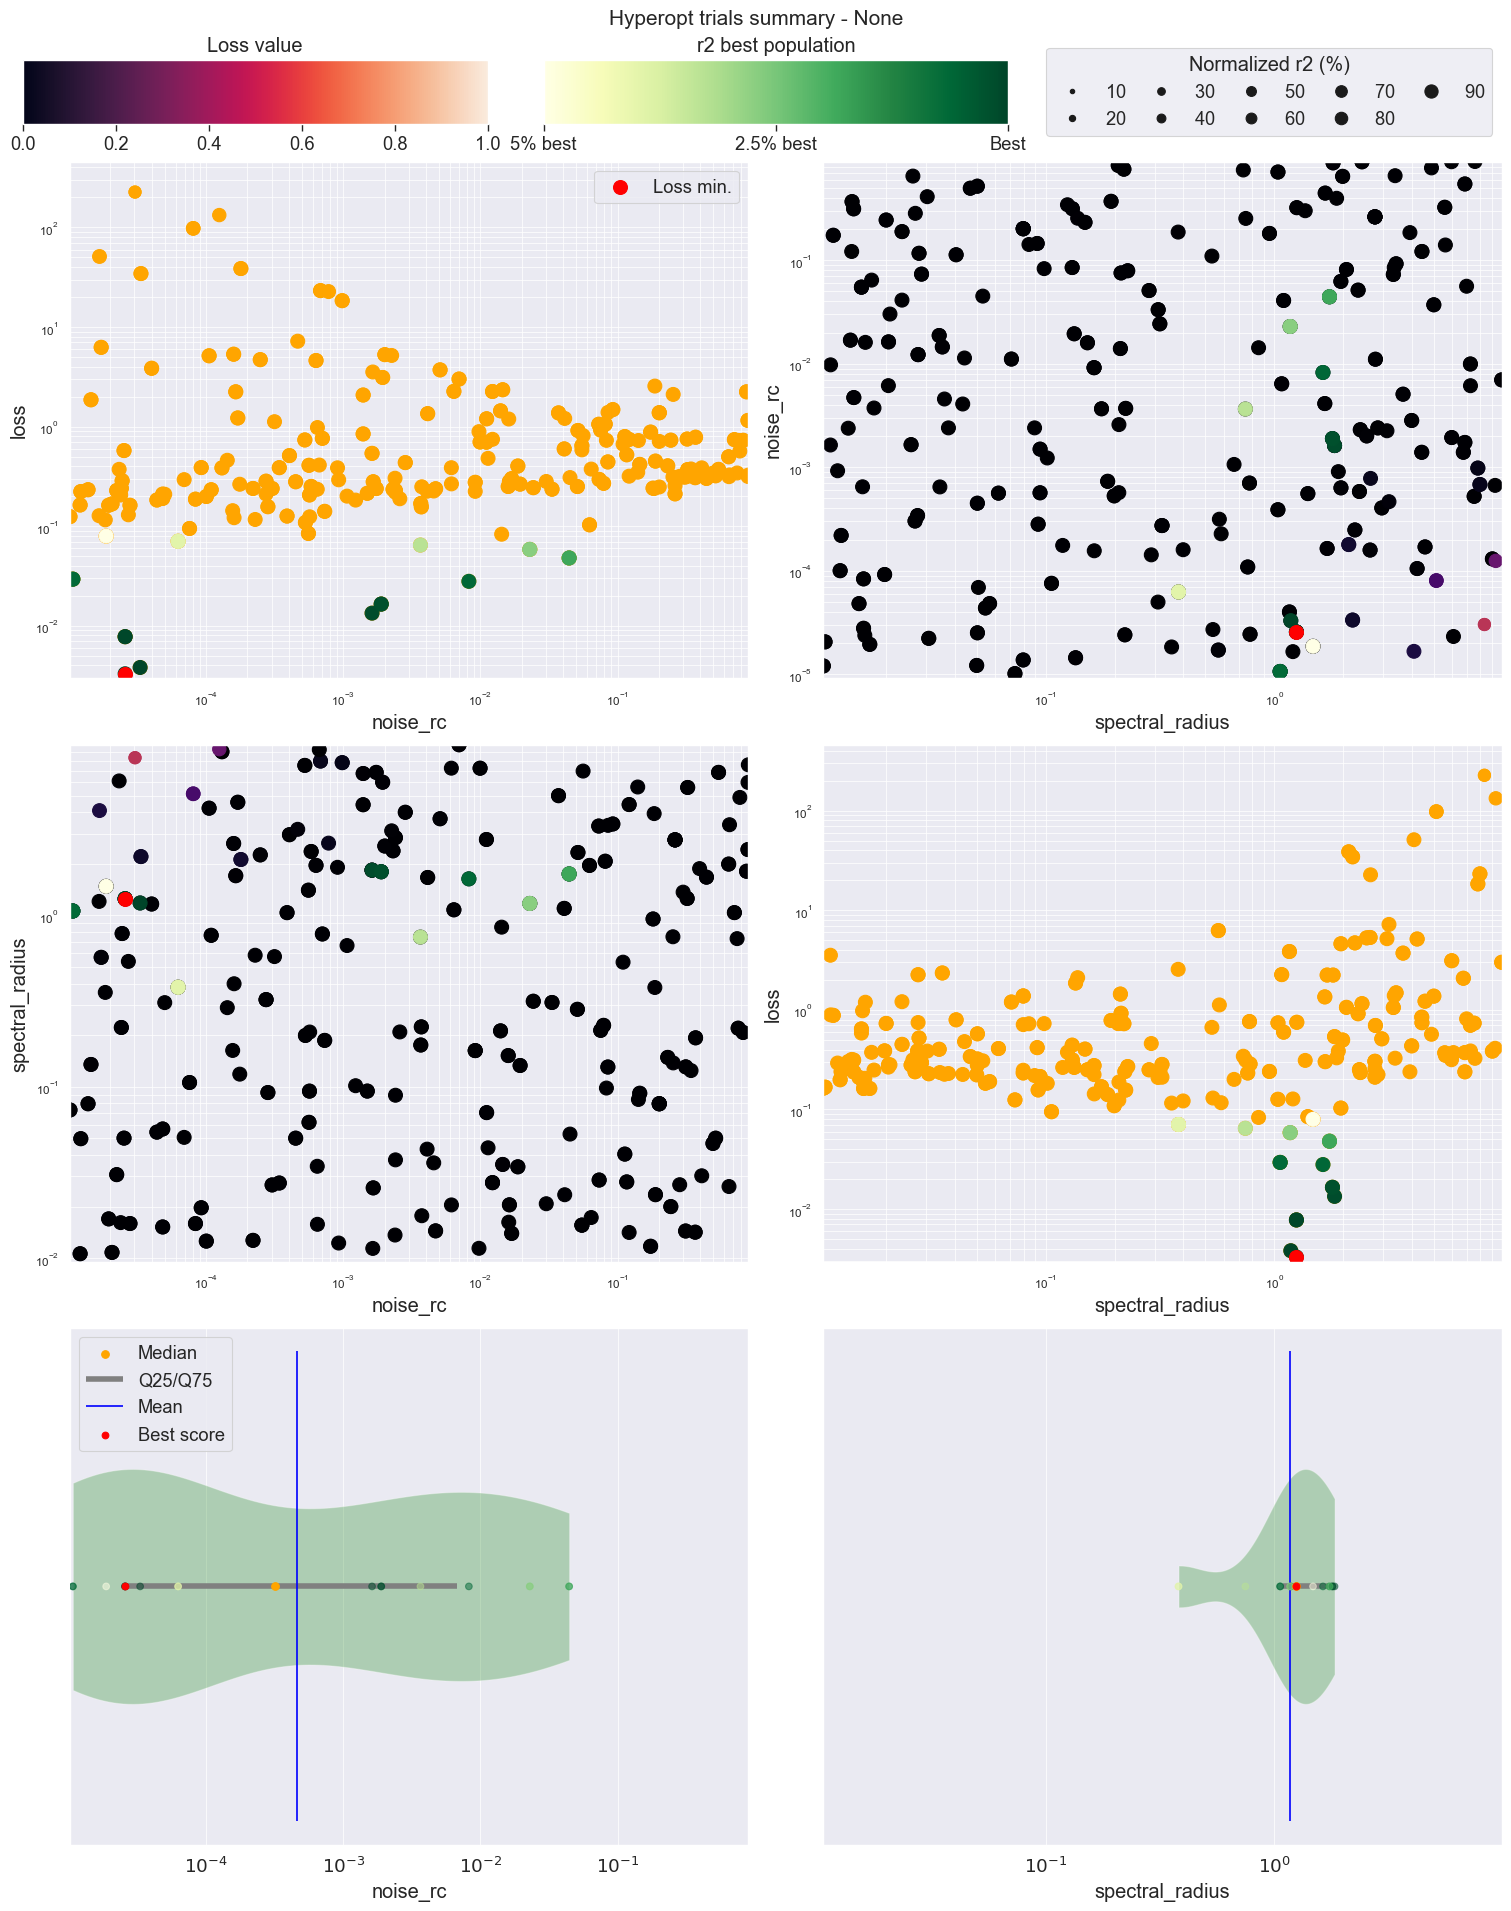

In [229]:
from reservoirpy.hyper import plot_hyperopt_report

fig = plot_hyperopt_report(hyperopt_config["exp"], ("noise_rc", "spectral_radius"), metric="r2")

In [232]:
#最適化されたパラメータを出力する。
best

({'cell_number': 0,
  'connectivity': 0.10407566959031667,
  'input_connectivity': 0,
  'input_scaling': 0.9697295578201843,
  'leak_rate': 0.17113764962939737,
  'noise_rc': 3.297333463106559e-05,
  'regularization': 5.602814683095597e-09,
  'seed': 0,
  'spectral_radius': 1.182082887824895},
 <hyperopt.base.Trials at 0x177466070>)

・各パラメータの探索範囲は？

$10 ^{−3.42} \approx 0.000376493580679246$

$ 3.297333463106559e-05 = 0.00003297333463106559$

In [237]:
def plot_mackey_glass2(X, Y_pred, sample, tau):

    fig = plt.figure(figsize=(13, 5))
    N = sample

    ax = plt.subplot((121))
    t = np.linspace(0, N, N)
    for i in range(N-1):
        ax.plot(t[i:i+2], X[i:i+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Timeseries - {N} timesteps")
    plt.xlabel("$t$")
    plt.ylabel("$P(t)$")

    ax2 = plt.subplot((122))
    ax2.margins(0.05)
    for i in range(N-1):
        ax2.plot(X[i:i+2], X[i+tau:i+tau+2], color=plt.cm.magma(255*i//N), lw=1.0)

    plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
    plt.xlabel("$P(t-\\tau)$")
    plt.ylabel("$P(t)$")

    plt.tight_layout()
    plt.show()

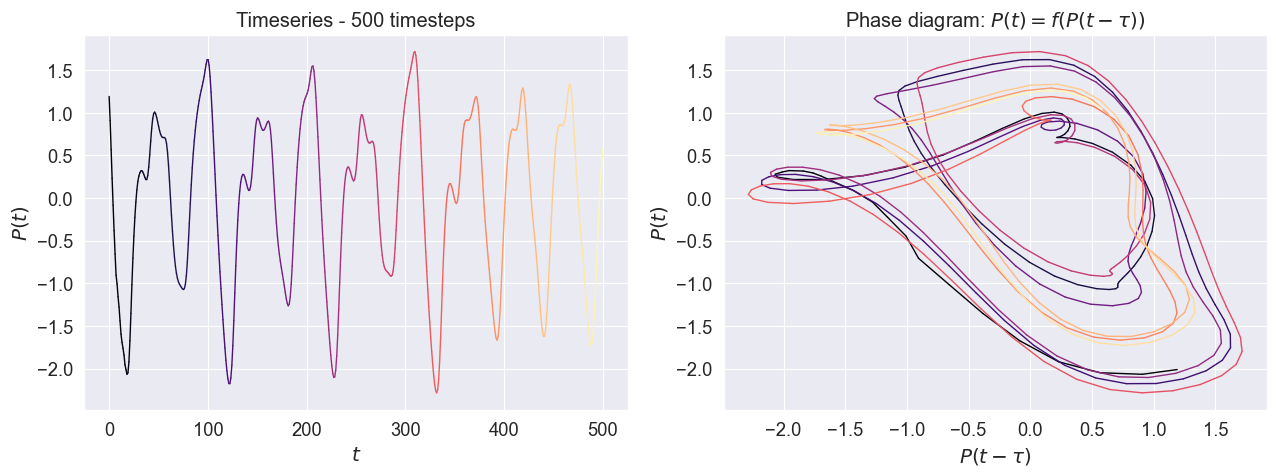

In [265]:
plot_mackey_glass2(X, Y_pred1,500, tau)